<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones y definiciones

In [ ]:
!pip install --upgrade torch torchvision

## 1.1 Librerías y parámetros

In [ ]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [ ]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms

if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

## 1.2 Arquitectura de AllConvNet

In [ ]:
class AllConvNet(nn.Module):
    def __init__(self, input_size, n_classes=10, **kwargs):
        super(AllConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_size, 96, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(96)
        self.conv2 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(96)
        self.conv3 = nn.Conv2d(96, 96, 3, padding=1, stride=2)
        self.bn3 = nn.BatchNorm2d(96)
        self.conv4 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(192)
        self.conv5 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(192)
        self.conv6 = nn.Conv2d(192, 192, 3, padding=1, stride=2)
        self.bn6 = nn.BatchNorm2d(192)
        self.conv7 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 1)
        self.bn8 = nn.BatchNorm2d(192)

        self.class_conv = nn.Conv2d(192, n_classes, 1)

    def forward(self, x):
        x_drop = F.dropout(x, .2)
        conv1_out = F.relu(self.bn1(self.conv1(x_drop)))
        conv2_out = F.relu(self.bn2(self.conv2(conv1_out)))
        conv3_out = F.relu(self.bn3(self.conv3(conv2_out)))
        conv3_out_drop = F.dropout(conv3_out, .5)
        conv4_out = F.relu(self.bn4(self.conv4(conv3_out_drop)))
        conv5_out = F.relu(self.bn5(self.conv5(conv4_out)))
        conv6_out = F.relu(self.bn6(self.conv6(conv5_out)))
        conv6_out_drop = F.dropout(conv6_out, .5)
        conv7_out = F.relu(self.bn7(self.conv7(conv6_out_drop)))
        conv8_out = F.relu(self.bn8(self.conv8(conv7_out)))

        class_out = F.relu(self.class_conv(conv8_out))
        pool_out = F.adaptive_avg_pool2d(class_out, 1)
        pool_out.squeeze_(-1)
        pool_out.squeeze_(-1)
        return pool_out


## 2. Transformacion y carga de datos

In [ ]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive');

Mounted at /content/gdrive


In [ ]:
class NormalizeNegativeImages(object):

    def __call__(self, item):
        min_value_pixel = torch.min(item)
        if min_value_pixel < 0:
            item -= min_value_pixel
            item /= torch.max(item)
        return item

In [ ]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()
trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

# Data normal (32x32)

transform_train = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages(),
     transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip()
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages()
])

#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_test8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
])

transform_train8x8 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip()
])

# Crearemos transformaciones sin randomizar nada para la resta de imágenes.

transform_train_no_random = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(train_mean, train_std),
     NormalizeNegativeImages()
])

transform_train8x8_no_random = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
    NormalizeNegativeImages(),
    transforms.Resize((8,8)),
    transforms.Resize((32,32))
])

100%|██████████| 170498071/170498071 [00:13<00:00, 12922170.17it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [ ]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader_blur = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test8x8),
    batch_size=test_batch_size, shuffle=True, **kwargs)

# Data sin random ni data augmentation para mostrar imágenes

train_loader_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_test),
    batch_size=train_batch_size, shuffle=False, **kwargs)

train_loader_blur_no_random = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8_no_random),
    batch_size=train_batch_size, shuffle=False, **kwargs)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


<class 'torch.Tensor'>


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


<class 'torch.Tensor'>


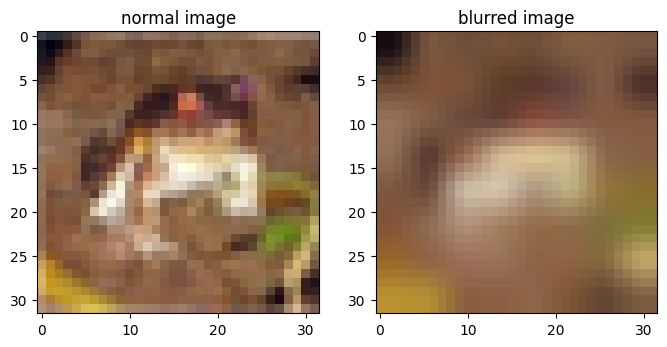

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
loaders = [train_loader_no_random, train_loader_blur_no_random]
label = ['normal image', 'blurred image']

for ax_index, loader in enumerate(loaders):
  for batch_data, batch_labels in loader:
    print(type(batch_data[0]))
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    ax[ax_index].imshow(first_image)
    ax[ax_index].set_title(label[ax_index])
    break

plt.show()

## 3. Entrenamiento

In [ ]:
criterion = nn.CrossEntropyLoss()

### 3.1 Funciones auxiliares


In [ ]:
# Se definen funciones auxiliares

def initialize_model():

    '''
    Initialize a simple AllConvNet(3) and returns the model and all the
    needed information to train it.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
        model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300],
                gamma=0.1)

    return model, optimizer, criterion, scheduler


def pretty_print(text: str, char='*'):

    '''
    Prints in a prettier way with more space. You can change the asterisks
    if something else is prefered.
    '''

    n_char = len(text)
    print(
    f'''
    {char * n_char}
    {text}
    {char * n_char}
    ''')


def load_pretrained_model(drive_path=None):

    '''
    Reads the google drive path and load the model into an AllConvNet(3). It loads
    the optimizer as well. If no path is given, the function instanciates an
    AllConvNet(3) and the necessary classes for the training and testing.
    '''

    global cuda
    global criterion

    model = AllConvNet(3)

    if cuda:
      model.cuda()

    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    if drive_path is None:
      model_data = {
      'pretrained_epochs': 0,
      'model_state_dict': -1,
      'optimizer_state_dict': -1,
      'final_accuracy': 0,
      'training_data_dict': {},
      'test_data_dict': {}}

    else:
      model_data = torch.load(drive_path)
      model_state_dict = model_data['model_state_dict']
      opt_state_dict = model_data['optimizer_state_dict']
      model.load_state_dict(model_state_dict)
      optimizer.load_state_dict(opt_state_dict)

    scheduler = optim.lr_scheduler.MultiStepLR(
                optimizer, milestones=[200, 250, 300], gamma=0.1)

    return_dict = {'model': model,
                   'model_data': model_data,
                   'optimizer': optimizer,
                   'scheduler': scheduler}

    return return_dict


def save_training_data(save_dict: dict, acc: int, current_epoch: int,
                       total_epochs: int, save_every=10, altered=False):

    '''
    If the current epoch is a multiple of the a determined number, or is the last
    epoch, the function takes an existing dictionary containing the epochs as
    keys and the accuracy as value, and adds the acc of the current epoch.
    '''

    data_type = 'Normal'
    if altered:
      data_type = 'Altered'

    if current_epoch % save_every == 0 or current_epoch == total_epochs:
      round_acc = round(acc.item(), 2)
      save_dict[f'{current_epoch}'] = round_acc
      pretty_print(f'{data_type} Data Saved: ({current_epoch}, {round_acc})', char='-')
    return save_dict


def save_model(pretrained_epochs, model_state_dict, optimizer_state_dict,
               final_accuracy, training_data_dict, test_data_dict,
               checkpt_path):

    '''
    Saves the AllConvNet model with all the imporatant information in the given
    drive path.
    '''

    checkpoint = {
      'pretrained_epochs': pretrained_epochs,
      'model_state_dict': model_state_dict,
      'optimizer_state_dict': optimizer_state_dict,
      'final_accuracy': round(final_accuracy, 2),
      'training_data_dict': training_data_dict,
      'test_data_dict': test_data_dict}

    torch.save(checkpoint, checkpt_path)


def save_plot(path: str, training_data: dict, altered_test_data: dict,
              altered_begin: int, blur=False):

    '''
    Generates a graph of epochs vs accuracies by using the keys and values stored
    in a dictionary. Then, the plot is save into the given drive path.
    '''

    epocas = list(training_data.keys())
    accuracies = list(training_data.values())

    title_text = f'Epochs vs Accuracies (Trained with HF images since epoch {altered_begin} for 40 epochs)'
    train_stuff = 'High Frecuency'

    if blur:
        title_text = f'Epochs vs Accuracies (Trained with blurred images since epoch {altered_begin} for 40 epochs)'
        train_stuff = 'Blurred'

    ax = plt.figure(figsize=(12,6))
    plt.plot(epocas, accuracies, label=f'Trained with {train_stuff} Images')
    plt.grid()
    plt.title(title_text)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracies')

    last_acc, last_ep = accuracies[-1], epocas[-1]
    text_upper_left = f'Last {train_stuff} epoch: {last_ep}\nLast {train_stuff} acc: {last_acc:.2f}'
    plt.text(0.02, 0.77, text_upper_left, transform=plt.gca().transAxes,
            bbox=dict(facecolor='lightgray', edgecolor='lightgray',
                      boxstyle='round,pad=0.5', alpha=0.5))

    # Añadir los cuadros de texto sobre épocas múltiplos de 40.

    for ep, acc in zip(epocas, accuracies):
        if int(ep) % 40 == 0:
            text = f'Epoch: {ep}\nAcc: {acc:.2f}'
            plt.annotate(text, (ep, acc), textcoords="offset points", xytext=(0,-8),
                         ha='center', va='bottom', bbox=dict(facecolor='lightgray',
                         edgecolor='lightgray', boxstyle='round,pad=0.5', alpha=0.5))

    # Plotear el modelo entrenado con imágenes normales.

    std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
    normal_image_training_path = std_text + '/allconv_noblur_checkpts/checkpoint_epoch_360.pt'
    normal_images_data = load_pretrained_model(normal_image_training_path)
    model_data_normal = normal_images_data['model_data']
    train_data_normal = model_data_normal['training_data_dict']

    epochs_normal = list(train_data_normal.keys())
    accs_normal = list(train_data_normal.values())
    plot_length = len(epocas)
    plt.plot(epochs_normal[:plot_length], accs_normal[:plot_length],
              color='lightgreen', linestyle='--', marker='o',
              label='Normal images training')

    # Plotear accuaracy del modelo para clasificar el altered loader

    altered_epochs_test = list(altered_test_data.keys())
    altered_epochs_acc = list(altered_test_data.values())
    plt.plot(altered_epochs_test, altered_epochs_acc,
             color='lightcoral', linestyle='--', marker='o',
             label=f'Test with {train_stuff} Images')


    plt.scatter(epocas, accuracies, color='orange')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path)

In [ ]:
def train(epoch: int, loader: torch.utils.data.DataLoader,
          model: AllConvNet, optimizer):

    global criterion
    global cuda

    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(loader.dataset),
              100. * batch_idx / len(loader), loss.item()))


def test(epoch: int, best_loss: int, best_epoch: int,
         test_loader: torch.utils.data.DataLoader, model: AllConvNet,
         show_altered=False):

    global criterion
    global cuda

    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
        acc = 100 * correct / len(test_loader.dataset)

    test_loss /= len(test_loader.dataset)

    altered_text = 'Normal'
    if show_altered:
        altered_text = 'Altered'

    print(
        '\n{} Test set: Average loss: {:.4f}, Accuracy: {} ({:.0f}%)\n'.format(
            altered_text, test_loss, acc, 100. * correct /
            len(test_loader.dataset)))


    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss

    return best_loss, best_epoch, acc

### 3.2 Definición del modelo

In [ ]:
def begin_model_easy(normal_loader: torch.utils.data.DataLoader,
                     altered_loader: torch.utils.data.DataLoader,
                     normal_test: torch.utils.data.DataLoader,
                     altered_test: torch.utils.data.DataLoader,
                     normal_init=0, altered_epochs=40, after_altered=160,
                     model_path=None):

  '''
  Trains the model by using the two given loaders (altered and normal), in the
  periods indicated. If no model path is given, then an AllConvNet(3) is
  instanciated. Parameters related to the number of epochs to train with each
  dataset are set to run as they are in Achille et al. experiment.
  '''

  criterion = nn.CrossEntropyLoss()
  loader_type = torch.utils.data.dataloader.DataLoader
  best_loss = float("inf")
  best_epoch = -1
  num_parameters_not_ok = (normal_init < 0 or altered_epochs < 0 or after_altered < 0)
  loaders_not_ok = (altered_loader is loader_type or normal_loader is loader_type)

  if num_parameters_not_ok or loaders_not_ok:
    raise Exception("There are Inconsistencies in the parameters")

  else:
    packed_data = load_pretrained_model(drive_path=model_path)
    model = packed_data['model']
    model_data = packed_data['model_data']
    scheduler = packed_data['scheduler']
    optimizer = packed_data['optimizer']
    training_data_dict = model_data['training_data_dict']
    test_data_dict = model_data.get('test_data_dict', {})
    pretrained_epochs = model_data['pretrained_epochs']
    orig_acc = model_data['final_accuracy']
    total_epochs = pretrained_epochs + normal_init + altered_epochs + after_altered
    training_begins_from = pretrained_epochs

    if training_begins_from == 0:
      training_begins_from = -1

    if normal_init == 0:

      pretty_print(f'Begin training with altered images')
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')
      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')
      for epoch in range(pretrained_epochs + altered_epochs + 1,
                         pretrained_epochs + altered_epochs + after_altered + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

    elif normal_init != 0:

      pretty_print("Begin training with normal images")
      pretty_print(f"Accuracy before training: {orig_acc}", ' ')

      for epoch in range(training_begins_from + 1,
                         pretrained_epochs + normal_init + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print("Begin training with altered images")

      for epoch in range(pretrained_epochs + normal_init + 1,
                         pretrained_epochs + normal_init + altered_epochs + 1):
        scheduler.step()
        train(epoch, altered_loader, model, optimizer)

        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)

        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)

        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

      pretty_print('Altered image training finished. Training with normal images')

      for epoch in range(pretrained_epochs + normal_init + altered_epochs + 1,
                         total_epochs + 1):
        scheduler.step()
        train(epoch, normal_loader, model, optimizer)
        best_loss, best_epoch, acc = test(epoch, best_loss, best_epoch,
                                          normal_test, model)
        alt_best_loss, alt_best_epoch, alt_acc = test(epoch, best_loss,
                                                      best_epoch, altered_test,
                                                      model)
        training_data_dict = save_training_data(save_dict=training_data_dict,
                                                acc=acc, current_epoch=epoch,
                                                total_epochs=total_epochs)

        test_data_dict = save_training_data(save_dict=test_data_dict,
                                            acc=alt_acc, current_epoch=epoch,
                                            total_epochs=total_epochs,
                                            altered=True)

  pretty_print(f'final accuracy: {acc.item()}')

  dict_return = {'model': model,
                 'optimizer': optimizer,
                 'final_accuracy': round(acc.item(), 2),
                 'training_data_dict': training_data_dict,
                 'test_data_dict': test_data_dict,
                 'model_data': model_data}

  return dict_return

# Experimento 1 de Achille et al.

Vamos a entrenar con blur por $t_0$ epocas, con $t_0\in \{0, 20, 40, ... , 140\}$ y sucesivamente entrenamos por $160$ epocas sin blur.

Para ahorrar calculos,
* primero entrenamos modelo con blur por $140$ epocas y con un checkpoint cada $20$ epocas,
* sucesivamente entrenamos desde cada checkpoint por $160$ epocas sin blur, (se podra' hacer en paralelo?).



## 4. Entrenar modelos

En primer lugar, entrenamos el modelo que tiene las primeras 40 épocas con blur, y las 120 restantes sin blur. Despues de eso, se entrenarán con blur los modelos normales preentrenados, extraidos de MyDrive.

### 4.1 modelo partiendo en 0

In [ ]:
# Entrenamos modelo que empieza con 40 épocas blur y sigue con 120 normales
#PROXIMO CODIGO A EJECUTAR
std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
whole_data = begin_model_easy(normal_loader=train_loader,
                              altered_loader=train_loader_blur,
                              normal_test=test_loader,
                              altered_test=test_loader_blur)

model_data = whole_data['model_data']
model = whole_data['model']
final_accuracy = whole_data['final_accuracy']
optimizer = whole_data['optimizer']
training_data_dict = whole_data['training_data_dict']
test_data_dict = whole_data['test_data_dict']
pretrained_epochs = model_data['pretrained_epochs']

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"

save_model(pretrained_epochs=pretrained_epochs,
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(final_accuracy, 2),
           training_data_dict=training_data_dict,
           test_data_dict=test_data_dict,
           checkpt_path=checkpoint_save_path)


    **********************************
    Begin training with altered images
    **********************************
    

                               
    Accuracy before training: 0
                               
    


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for

Train epoch: 0 [0/50000 (0%)]	Loss: 2.305534
Train epoch: 0 [3200/50000 (6%)]	Loss: 2.303848
Train epoch: 0 [6400/50000 (13%)]	Loss: 2.300708
Train epoch: 0 [9600/50000 (19%)]	Loss: 2.305184
Train epoch: 0 [12800/50000 (26%)]	Loss: 2.293713
Train epoch: 0 [16000/50000 (32%)]	Loss: 2.299305
Train epoch: 0 [19200/50000 (38%)]	Loss: 2.307136
Train epoch: 0 [22400/50000 (45%)]	Loss: 2.303616
Train epoch: 0 [25600/50000 (51%)]	Loss: 2.301422
Train epoch: 0 [28800/50000 (58%)]	Loss: 2.305568
Train epoch: 0 [32000/50000 (64%)]	Loss: 2.300459
Train epoch: 0 [35200/50000 (70%)]	Loss: 2.298089
Train epoch: 0 [38400/50000 (77%)]	Loss: 2.303315
Train epoch: 0 [41600/50000 (83%)]	Loss: 2.304363
Train epoch: 0 [44800/50000 (90%)]	Loss: 2.303545
Train epoch: 0 [48000/50000 (96%)]	Loss: 2.300589

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    ----------------------------
    Normal Data Saved: (0, 10.0)
    ----------------------------
    

    -----------------------------
    Altered Data Saved: (0, 10.0)
    -----------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 1 [0/50000 (0%)]	Loss: 2.303844
Train epoch: 1 [3200/50000 (6%)]	Loss: 2.303416
Train epoch: 1 [6400/50000 (13%)]	Loss: 2.303267
Train epoch: 1 [9600/50000 (19%)]	Loss: 2.302592
Train epoch: 1 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 1 [16000/50000 (32%)]	Loss: 2.302603
Train epoch: 1 [19200/50000 (38%)]	Loss: 2.302581
Train epoch: 1 [22400/50000 (45%)]	Loss: 2.302596
Train epoch: 1 [25600/50000 (51%)]	Loss: 2.302585
Train epoch: 1 [28800/50000 (58%)]	Loss: 2.302586
Train epoch: 1 [32000/50000 (64%)]	Loss: 2.302585
Train epoch: 1 [35200/50000 (70%)]	Loss: 2.302592
Train epoch: 1 [38400/50000 (77%)]	Loss: 2.302581
Train epoch: 1 [41600/50000 (83%)]	Loss: 2.302577
Train epoch: 1 [44800/50000 (90%)]	Loss: 2.302501
Train epoch: 1 [48000/50000 (96%)]	Loss: 2.302666

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 2 [0/50000 (0%)]	Loss: 2.302078
Train epoch: 2 [3200/50000 (6%)]	Loss: 2.302730
Train epoch: 2 [6400/50000 (13%)]	Loss: 2.301646
Train epoch: 2 [9600/50000 (19%)]	Loss: 2.303118
Train epoch: 2 [12800/50000 (26%)]	Loss: 2.302661
Train epoch: 2 [16000/50000 (32%)]	Loss: 2.302268
Train epoch: 2 [19200/50000 (38%)]	Loss: 2.302741
Train epoch: 2 [22400/50000 (45%)]	Loss: 2.303669
Train epoch: 2 [25600/50000 (51%)]	Loss: 2.302045
Train epoch: 2 [28800/50000 (58%)]	Loss: 2.303153
Train epoch: 2 [32000/50000 (64%)]	Loss: 2.302609
Train epoch: 2 [35200/50000 (70%)]	Loss: 2.301540
Train epoch: 2 [38400/50000 (77%)]	Loss: 2.302600
Train epoch: 2 [41600/50000 (83%)]	Loss: 2.302580
Train epoch: 2 [44800/50000 (90%)]	Loss: 2.302578
Train epoch: 2 [48000/50000 (96%)]	Loss: 2.302218

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 3 [0/50000 (0%)]	Loss: 2.302886
Train epoch: 3 [3200/50000 (6%)]	Loss: 2.302224
Train epoch: 3 [6400/50000 (13%)]	Loss: 2.303151
Train epoch: 3 [9600/50000 (19%)]	Loss: 2.302169
Train epoch: 3 [12800/50000 (26%)]	Loss: 2.303895
Train epoch: 3 [16000/50000 (32%)]	Loss: 2.302580
Train epoch: 3 [19200/50000 (38%)]	Loss: 2.302596
Train epoch: 3 [22400/50000 (45%)]	Loss: 2.302606
Train epoch: 3 [25600/50000 (51%)]	Loss: 2.302586
Train epoch: 3 [28800/50000 (58%)]	Loss: 2.302351
Train epoch: 3 [32000/50000 (64%)]	Loss: 2.302143
Train epoch: 3 [35200/50000 (70%)]	Loss: 2.302577
Train epoch: 3 [38400/50000 (77%)]	Loss: 2.302604
Train epoch: 3 [41600/50000 (83%)]	Loss: 2.302659
Train epoch: 3 [44800/50000 (90%)]	Loss: 2.302643
Train epoch: 3 [48000/50000 (96%)]	Loss: 2.302633

Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.020000457763672 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 4 [0/50000 (0%)]	Loss: 2.302605
Train epoch: 4 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 4 [6400/50000 (13%)]	Loss: 2.302500
Train epoch: 4 [9600/50000 (19%)]	Loss: 2.304066
Train epoch: 4 [12800/50000 (26%)]	Loss: 2.303947
Train epoch: 4 [16000/50000 (32%)]	Loss: 2.303140
Train epoch: 4 [19200/50000 (38%)]	Loss: 2.302625
Train epoch: 4 [22400/50000 (45%)]	Loss: 2.302388
Train epoch: 4 [25600/50000 (51%)]	Loss: 2.301100
Train epoch: 4 [28800/50000 (58%)]	Loss: 2.302736
Train epoch: 4 [32000/50000 (64%)]	Loss: 2.300581
Train epoch: 4 [35200/50000 (70%)]	Loss: 2.302683
Train epoch: 4 [38400/50000 (77%)]	Loss: 2.303005
Train epoch: 4 [41600/50000 (83%)]	Loss: 2.302767
Train epoch: 4 [44800/50000 (90%)]	Loss: 2.302575
Train epoch: 4 [48000/50000 (96%)]	Loss: 2.302575

Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.229999542236328 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 5 [0/50000 (0%)]	Loss: 2.302594
Train epoch: 5 [3200/50000 (6%)]	Loss: 2.302206
Train epoch: 5 [6400/50000 (13%)]	Loss: 2.303463
Train epoch: 5 [9600/50000 (19%)]	Loss: 2.301873
Train epoch: 5 [12800/50000 (26%)]	Loss: 2.302582
Train epoch: 5 [16000/50000 (32%)]	Loss: 2.302548
Train epoch: 5 [19200/50000 (38%)]	Loss: 2.303074
Train epoch: 5 [22400/50000 (45%)]	Loss: 2.302218
Train epoch: 5 [25600/50000 (51%)]	Loss: 2.303404
Train epoch: 5 [28800/50000 (58%)]	Loss: 2.301302
Train epoch: 5 [32000/50000 (64%)]	Loss: 2.302689
Train epoch: 5 [35200/50000 (70%)]	Loss: 2.301671
Train epoch: 5 [38400/50000 (77%)]	Loss: 2.301394
Train epoch: 5 [41600/50000 (83%)]	Loss: 2.302358
Train epoch: 5 [44800/50000 (90%)]	Loss: 2.302438
Train epoch: 5 [48000/50000 (96%)]	Loss: 2.302964

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 6 [0/50000 (0%)]	Loss: 2.302829
Train epoch: 6 [3200/50000 (6%)]	Loss: 2.304173
Train epoch: 6 [6400/50000 (13%)]	Loss: 2.303659
Train epoch: 6 [9600/50000 (19%)]	Loss: 2.302633
Train epoch: 6 [12800/50000 (26%)]	Loss: 2.302376
Train epoch: 6 [16000/50000 (32%)]	Loss: 2.301583
Train epoch: 6 [19200/50000 (38%)]	Loss: 2.302299
Train epoch: 6 [22400/50000 (45%)]	Loss: 2.302088
Train epoch: 6 [25600/50000 (51%)]	Loss: 2.302315
Train epoch: 6 [28800/50000 (58%)]	Loss: 2.302536
Train epoch: 6 [32000/50000 (64%)]	Loss: 2.302634
Train epoch: 6 [35200/50000 (70%)]	Loss: 2.302606
Train epoch: 6 [38400/50000 (77%)]	Loss: 2.302626
Train epoch: 6 [41600/50000 (83%)]	Loss: 2.302625
Train epoch: 6 [44800/50000 (90%)]	Loss: 2.302909
Train epoch: 6 [48000/50000 (96%)]	Loss: 2.302615

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 7 [0/50000 (0%)]	Loss: 2.302586
Train epoch: 7 [3200/50000 (6%)]	Loss: 2.302865
Train epoch: 7 [6400/50000 (13%)]	Loss: 2.302589
Train epoch: 7 [9600/50000 (19%)]	Loss: 2.303335
Train epoch: 7 [12800/50000 (26%)]	Loss: 2.302565
Train epoch: 7 [16000/50000 (32%)]	Loss: 2.302489
Train epoch: 7 [19200/50000 (38%)]	Loss: 2.302599
Train epoch: 7 [22400/50000 (45%)]	Loss: 2.302320
Train epoch: 7 [25600/50000 (51%)]	Loss: 2.302807
Train epoch: 7 [28800/50000 (58%)]	Loss: 2.302357
Train epoch: 7 [32000/50000 (64%)]	Loss: 2.302709
Train epoch: 7 [35200/50000 (70%)]	Loss: 2.302559
Train epoch: 7 [38400/50000 (77%)]	Loss: 2.302804
Train epoch: 7 [41600/50000 (83%)]	Loss: 2.302424
Train epoch: 7 [44800/50000 (90%)]	Loss: 2.302594
Train epoch: 7 [48000/50000 (96%)]	Loss: 2.302569

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 8 [0/50000 (0%)]	Loss: 2.303004
Train epoch: 8 [3200/50000 (6%)]	Loss: 2.302085
Train epoch: 8 [6400/50000 (13%)]	Loss: 2.302617
Train epoch: 8 [9600/50000 (19%)]	Loss: 2.302214
Train epoch: 8 [12800/50000 (26%)]	Loss: 2.302012
Train epoch: 8 [16000/50000 (32%)]	Loss: 2.302660
Train epoch: 8 [19200/50000 (38%)]	Loss: 2.302626
Train epoch: 8 [22400/50000 (45%)]	Loss: 2.302672
Train epoch: 8 [25600/50000 (51%)]	Loss: 2.303016
Train epoch: 8 [28800/50000 (58%)]	Loss: 2.302231
Train epoch: 8 [32000/50000 (64%)]	Loss: 2.302839
Train epoch: 8 [35200/50000 (70%)]	Loss: 2.302794
Train epoch: 8 [38400/50000 (77%)]	Loss: 2.302629
Train epoch: 8 [41600/50000 (83%)]	Loss: 2.302546
Train epoch: 8 [44800/50000 (90%)]	Loss: 2.302590
Train epoch: 8 [48000/50000 (96%)]	Loss: 2.302612

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 9 [0/50000 (0%)]	Loss: 2.302443
Train epoch: 9 [3200/50000 (6%)]	Loss: 2.303482
Train epoch: 9 [6400/50000 (13%)]	Loss: 2.302608
Train epoch: 9 [9600/50000 (19%)]	Loss: 2.302394
Train epoch: 9 [12800/50000 (26%)]	Loss: 2.303247
Train epoch: 9 [16000/50000 (32%)]	Loss: 2.302602
Train epoch: 9 [19200/50000 (38%)]	Loss: 2.302583
Train epoch: 9 [22400/50000 (45%)]	Loss: 2.302524
Train epoch: 9 [25600/50000 (51%)]	Loss: 2.302327
Train epoch: 9 [28800/50000 (58%)]	Loss: 2.302597
Train epoch: 9 [32000/50000 (64%)]	Loss: 2.302576
Train epoch: 9 [35200/50000 (70%)]	Loss: 2.302553
Train epoch: 9 [38400/50000 (77%)]	Loss: 2.302643
Train epoch: 9 [41600/50000 (83%)]	Loss: 2.303113
Train epoch: 9 [44800/50000 (90%)]	Loss: 2.302175
Train epoch: 9 [48000/50000 (96%)]	Loss: 2.301006

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 10 [0/50000 (0%)]	Loss: 2.302713
Train epoch: 10 [3200/50000 (6%)]	Loss: 2.299818
Train epoch: 10 [6400/50000 (13%)]	Loss: 2.298889
Train epoch: 10 [9600/50000 (19%)]	Loss: 2.302860
Train epoch: 10 [12800/50000 (26%)]	Loss: 2.302819
Train epoch: 10 [16000/50000 (32%)]	Loss: 2.302787
Train epoch: 10 [19200/50000 (38%)]	Loss: 2.302745
Train epoch: 10 [22400/50000 (45%)]	Loss: 2.303287
Train epoch: 10 [25600/50000 (51%)]	Loss: 2.302522
Train epoch: 10 [28800/50000 (58%)]	Loss: 2.302451
Train epoch: 10 [32000/50000 (64%)]	Loss: 2.302480
Train epoch: 10 [35200/50000 (70%)]	Loss: 2.302620
Train epoch: 10 [38400/50000 (77%)]	Loss: 2.302717
Train epoch: 10 [41600/50000 (83%)]	Loss: 2.302565
Train epoch: 10 [44800/50000 (90%)]	Loss: 2.302186
Train epoch: 10 [48000/50000 (96%)]	Loss: 2.302093

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)


    -----------------------------
    Normal Data Saved: (10, 10.0)
    -----------------------------
    

    ------------------------------
    Altered Data Saved: (10, 10.0)
    ------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 11 [0/50000 (0%)]	Loss: 2.301902
Train epoch: 11 [3200/50000 (6%)]	Loss: 2.303009
Train epoch: 11 [6400/50000 (13%)]	Loss: 2.302306
Train epoch: 11 [9600/50000 (19%)]	Loss: 2.302590
Train epoch: 11 [12800/50000 (26%)]	Loss: 2.302583
Train epoch: 11 [16000/50000 (32%)]	Loss: 2.302177
Train epoch: 11 [19200/50000 (38%)]	Loss: 2.302307
Train epoch: 11 [22400/50000 (45%)]	Loss: 2.302272
Train epoch: 11 [25600/50000 (51%)]	Loss: 2.302120
Train epoch: 11 [28800/50000 (58%)]	Loss: 2.303494
Train epoch: 11 [32000/50000 (64%)]	Loss: 2.303135
Train epoch: 11 [35200/50000 (70%)]	Loss: 2.302228
Train epoch: 11 [38400/50000 (77%)]	Loss: 2.302410
Train epoch: 11 [41600/50000 (83%)]	Loss: 2.302495
Train epoch: 11 [44800/50000 (90%)]	Loss: 2.303206
Train epoch: 11 [48000/50000 (96%)]	Loss: 2.302731

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 12 [0/50000 (0%)]	Loss: 2.303194
Train epoch: 12 [3200/50000 (6%)]	Loss: 2.302717
Train epoch: 12 [6400/50000 (13%)]	Loss: 2.302579
Train epoch: 12 [9600/50000 (19%)]	Loss: 2.301709
Train epoch: 12 [12800/50000 (26%)]	Loss: 2.302606
Train epoch: 12 [16000/50000 (32%)]	Loss: 2.302804
Train epoch: 12 [19200/50000 (38%)]	Loss: 2.302027
Train epoch: 12 [22400/50000 (45%)]	Loss: 2.301374
Train epoch: 12 [25600/50000 (51%)]	Loss: 2.302929
Train epoch: 12 [28800/50000 (58%)]	Loss: 2.302963
Train epoch: 12 [32000/50000 (64%)]	Loss: 2.302967
Train epoch: 12 [35200/50000 (70%)]	Loss: 2.302204
Train epoch: 12 [38400/50000 (77%)]	Loss: 2.303583
Train epoch: 12 [41600/50000 (83%)]	Loss: 2.302841
Train epoch: 12 [44800/50000 (90%)]	Loss: 2.302577
Train epoch: 12 [48000/50000 (96%)]	Loss: 2.302648

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 13 [0/50000 (0%)]	Loss: 2.302537
Train epoch: 13 [3200/50000 (6%)]	Loss: 2.302263
Train epoch: 13 [6400/50000 (13%)]	Loss: 2.301341
Train epoch: 13 [9600/50000 (19%)]	Loss: 2.300930
Train epoch: 13 [12800/50000 (26%)]	Loss: 2.303566
Train epoch: 13 [16000/50000 (32%)]	Loss: 2.303840
Train epoch: 13 [19200/50000 (38%)]	Loss: 2.303829
Train epoch: 13 [22400/50000 (45%)]	Loss: 2.303971
Train epoch: 13 [25600/50000 (51%)]	Loss: 2.301694
Train epoch: 13 [28800/50000 (58%)]	Loss: 2.302628
Train epoch: 13 [32000/50000 (64%)]	Loss: 2.301730
Train epoch: 13 [35200/50000 (70%)]	Loss: 2.302514
Train epoch: 13 [38400/50000 (77%)]	Loss: 2.302182
Train epoch: 13 [41600/50000 (83%)]	Loss: 2.302534
Train epoch: 13 [44800/50000 (90%)]	Loss: 2.302556
Train epoch: 13 [48000/50000 (96%)]	Loss: 2.302318

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 14 [0/50000 (0%)]	Loss: 2.302560
Train epoch: 14 [3200/50000 (6%)]	Loss: 2.302583
Train epoch: 14 [6400/50000 (13%)]	Loss: 2.302510
Train epoch: 14 [9600/50000 (19%)]	Loss: 2.301356
Train epoch: 14 [12800/50000 (26%)]	Loss: 2.304621
Train epoch: 14 [16000/50000 (32%)]	Loss: 2.301939
Train epoch: 14 [19200/50000 (38%)]	Loss: 2.302731
Train epoch: 14 [22400/50000 (45%)]	Loss: 2.303015
Train epoch: 14 [25600/50000 (51%)]	Loss: 2.302656
Train epoch: 14 [28800/50000 (58%)]	Loss: 2.302610
Train epoch: 14 [32000/50000 (64%)]	Loss: 2.301951
Train epoch: 14 [35200/50000 (70%)]	Loss: 2.302438
Train epoch: 14 [38400/50000 (77%)]	Loss: 2.302247
Train epoch: 14 [41600/50000 (83%)]	Loss: 2.302734
Train epoch: 14 [44800/50000 (90%)]	Loss: 2.302426
Train epoch: 14 [48000/50000 (96%)]	Loss: 2.303258

Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0187, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 15 [0/50000 (0%)]	Loss: 2.302690
Train epoch: 15 [3200/50000 (6%)]	Loss: 2.302577
Train epoch: 15 [6400/50000 (13%)]	Loss: 2.302060
Train epoch: 15 [9600/50000 (19%)]	Loss: 2.303282
Train epoch: 15 [12800/50000 (26%)]	Loss: 2.302144
Train epoch: 15 [16000/50000 (32%)]	Loss: 2.302394
Train epoch: 15 [19200/50000 (38%)]	Loss: 2.303372
Train epoch: 15 [22400/50000 (45%)]	Loss: 2.302719
Train epoch: 15 [25600/50000 (51%)]	Loss: 2.303494
Train epoch: 15 [28800/50000 (58%)]	Loss: 2.302285
Train epoch: 15 [32000/50000 (64%)]	Loss: 2.302256
Train epoch: 15 [35200/50000 (70%)]	Loss: 2.303186
Train epoch: 15 [38400/50000 (77%)]	Loss: 2.302205
Train epoch: 15 [41600/50000 (83%)]	Loss: 2.301396
Train epoch: 15 [44800/50000 (90%)]	Loss: 2.301304
Train epoch: 15 [48000/50000 (96%)]	Loss: 2.301390

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 16 [0/50000 (0%)]	Loss: 2.302148
Train epoch: 16 [3200/50000 (6%)]	Loss: 2.299724
Train epoch: 16 [6400/50000 (13%)]	Loss: 2.302432
Train epoch: 16 [9600/50000 (19%)]	Loss: 2.304357
Train epoch: 16 [12800/50000 (26%)]	Loss: 2.302499
Train epoch: 16 [16000/50000 (32%)]	Loss: 2.304038
Train epoch: 16 [19200/50000 (38%)]	Loss: 2.303108
Train epoch: 16 [22400/50000 (45%)]	Loss: 2.302852
Train epoch: 16 [25600/50000 (51%)]	Loss: 2.303321
Train epoch: 16 [28800/50000 (58%)]	Loss: 2.303363
Train epoch: 16 [32000/50000 (64%)]	Loss: 2.302343
Train epoch: 16 [35200/50000 (70%)]	Loss: 2.305081
Train epoch: 16 [38400/50000 (77%)]	Loss: 2.302676
Train epoch: 16 [41600/50000 (83%)]	Loss: 2.302649
Train epoch: 16 [44800/50000 (90%)]	Loss: 2.301904
Train epoch: 16 [48000/50000 (96%)]	Loss: 2.301786

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 17 [0/50000 (0%)]	Loss: 2.302017
Train epoch: 17 [3200/50000 (6%)]	Loss: 2.301681
Train epoch: 17 [6400/50000 (13%)]	Loss: 2.301642
Train epoch: 17 [9600/50000 (19%)]	Loss: 2.302345
Train epoch: 17 [12800/50000 (26%)]	Loss: 2.301384
Train epoch: 17 [16000/50000 (32%)]	Loss: 2.302286
Train epoch: 17 [19200/50000 (38%)]	Loss: 2.299293
Train epoch: 17 [22400/50000 (45%)]	Loss: 2.304219
Train epoch: 17 [25600/50000 (51%)]	Loss: 2.301803
Train epoch: 17 [28800/50000 (58%)]	Loss: 2.301995
Train epoch: 17 [32000/50000 (64%)]	Loss: 2.303450
Train epoch: 17 [35200/50000 (70%)]	Loss: 2.302588
Train epoch: 17 [38400/50000 (77%)]	Loss: 2.301888
Train epoch: 17 [41600/50000 (83%)]	Loss: 2.302039
Train epoch: 17 [44800/50000 (90%)]	Loss: 2.303140
Train epoch: 17 [48000/50000 (96%)]	Loss: 2.301495

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 18 [0/50000 (0%)]	Loss: 2.303684
Train epoch: 18 [3200/50000 (6%)]	Loss: 2.303512
Train epoch: 18 [6400/50000 (13%)]	Loss: 2.302633
Train epoch: 18 [9600/50000 (19%)]	Loss: 2.299144
Train epoch: 18 [12800/50000 (26%)]	Loss: 2.302757
Train epoch: 18 [16000/50000 (32%)]	Loss: 2.302594
Train epoch: 18 [19200/50000 (38%)]	Loss: 2.301521
Train epoch: 18 [22400/50000 (45%)]	Loss: 2.300183
Train epoch: 18 [25600/50000 (51%)]	Loss: 2.304634
Train epoch: 18 [28800/50000 (58%)]	Loss: 2.300857
Train epoch: 18 [32000/50000 (64%)]	Loss: 2.301198
Train epoch: 18 [35200/50000 (70%)]	Loss: 2.302499
Train epoch: 18 [38400/50000 (77%)]	Loss: 2.303288
Train epoch: 18 [41600/50000 (83%)]	Loss: 2.300117
Train epoch: 18 [44800/50000 (90%)]	Loss: 2.299787
Train epoch: 18 [48000/50000 (96%)]	Loss: 2.301340

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 19 [0/50000 (0%)]	Loss: 2.301835
Train epoch: 19 [3200/50000 (6%)]	Loss: 2.299469
Train epoch: 19 [6400/50000 (13%)]	Loss: 2.303482
Train epoch: 19 [9600/50000 (19%)]	Loss: 2.301561
Train epoch: 19 [12800/50000 (26%)]	Loss: 2.304939
Train epoch: 19 [16000/50000 (32%)]	Loss: 2.304502
Train epoch: 19 [19200/50000 (38%)]	Loss: 2.301374
Train epoch: 19 [22400/50000 (45%)]	Loss: 2.301622
Train epoch: 19 [25600/50000 (51%)]	Loss: 2.302940
Train epoch: 19 [28800/50000 (58%)]	Loss: 2.303628
Train epoch: 19 [32000/50000 (64%)]	Loss: 2.302310
Train epoch: 19 [35200/50000 (70%)]	Loss: 2.298854
Train epoch: 19 [38400/50000 (77%)]	Loss: 2.297722
Train epoch: 19 [41600/50000 (83%)]	Loss: 2.301186
Train epoch: 19 [44800/50000 (90%)]	Loss: 2.301502
Train epoch: 19 [48000/50000 (96%)]	Loss: 2.298732

Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.0 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 20 [0/50000 (0%)]	Loss: 2.304579
Train epoch: 20 [3200/50000 (6%)]	Loss: 2.305908
Train epoch: 20 [6400/50000 (13%)]	Loss: 2.302149
Train epoch: 20 [9600/50000 (19%)]	Loss: 2.298195
Train epoch: 20 [12800/50000 (26%)]	Loss: 2.301139
Train epoch: 20 [16000/50000 (32%)]	Loss: 2.301798
Train epoch: 20 [19200/50000 (38%)]	Loss: 2.302298
Train epoch: 20 [22400/50000 (45%)]	Loss: 2.303146
Train epoch: 20 [25600/50000 (51%)]	Loss: 2.304076
Train epoch: 20 [28800/50000 (58%)]	Loss: 2.297605
Train epoch: 20 [32000/50000 (64%)]	Loss: 2.300490
Train epoch: 20 [35200/50000 (70%)]	Loss: 2.302751
Train epoch: 20 [38400/50000 (77%)]	Loss: 2.278373
Train epoch: 20 [41600/50000 (83%)]	Loss: 2.299246
Train epoch: 20 [44800/50000 (90%)]	Loss: 2.302078
Train epoch: 20 [48000/50000 (96%)]	Loss: 2.301894

Test set: Average loss: 0.0186, Accuracy: 10.010000228881836 (10%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 10.020000457763672 (10%)


    ------------------------------
    Normal Data Saved: (20, 10.01)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (20, 10.02)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 21 [0/50000 (0%)]	Loss: 2.305066
Train epoch: 21 [3200/50000 (6%)]	Loss: 2.304776
Train epoch: 21 [6400/50000 (13%)]	Loss: 2.297121
Train epoch: 21 [9600/50000 (19%)]	Loss: 2.295743
Train epoch: 21 [12800/50000 (26%)]	Loss: 2.300778
Train epoch: 21 [16000/50000 (32%)]	Loss: 2.279380
Train epoch: 21 [19200/50000 (38%)]	Loss: 2.295969
Train epoch: 21 [22400/50000 (45%)]	Loss: 2.312565
Train epoch: 21 [25600/50000 (51%)]	Loss: 2.316892
Train epoch: 21 [28800/50000 (58%)]	Loss: 2.268206
Train epoch: 21 [32000/50000 (64%)]	Loss: 2.262421
Train epoch: 21 [35200/50000 (70%)]	Loss: 2.322567
Train epoch: 21 [38400/50000 (77%)]	Loss: 2.244486
Train epoch: 21 [41600/50000 (83%)]	Loss: 2.290372
Train epoch: 21 [44800/50000 (90%)]	Loss: 2.253055
Train epoch: 21 [48000/50000 (96%)]	Loss: 2.297650

Test set: Average loss: 0.0185, Accuracy: 12.380000114440918 (12%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 12.880000114440918 (13%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 22 [0/50000 (0%)]	Loss: 2.256958
Train epoch: 22 [3200/50000 (6%)]	Loss: 2.209581
Train epoch: 22 [6400/50000 (13%)]	Loss: 2.242279
Train epoch: 22 [9600/50000 (19%)]	Loss: 2.261526
Train epoch: 22 [12800/50000 (26%)]	Loss: 2.286712
Train epoch: 22 [16000/50000 (32%)]	Loss: 2.239591
Train epoch: 22 [19200/50000 (38%)]	Loss: 2.241596
Train epoch: 22 [22400/50000 (45%)]	Loss: 2.293864
Train epoch: 22 [25600/50000 (51%)]	Loss: 2.279661
Train epoch: 22 [28800/50000 (58%)]	Loss: 2.269452
Train epoch: 22 [32000/50000 (64%)]	Loss: 2.217890
Train epoch: 22 [35200/50000 (70%)]	Loss: 2.275155
Train epoch: 22 [38400/50000 (77%)]	Loss: 2.256625
Train epoch: 22 [41600/50000 (83%)]	Loss: 2.239166
Train epoch: 22 [44800/50000 (90%)]	Loss: 2.278318
Train epoch: 22 [48000/50000 (96%)]	Loss: 2.228820

Test set: Average loss: 0.0184, Accuracy: 16.020000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.040000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 23 [0/50000 (0%)]	Loss: 2.315328
Train epoch: 23 [3200/50000 (6%)]	Loss: 2.267748
Train epoch: 23 [6400/50000 (13%)]	Loss: 2.275513
Train epoch: 23 [9600/50000 (19%)]	Loss: 2.224712
Train epoch: 23 [12800/50000 (26%)]	Loss: 2.253469
Train epoch: 23 [16000/50000 (32%)]	Loss: 2.247569
Train epoch: 23 [19200/50000 (38%)]	Loss: 2.324184
Train epoch: 23 [22400/50000 (45%)]	Loss: 2.287031
Train epoch: 23 [25600/50000 (51%)]	Loss: 2.191730
Train epoch: 23 [28800/50000 (58%)]	Loss: 2.272974
Train epoch: 23 [32000/50000 (64%)]	Loss: 2.310565
Train epoch: 23 [35200/50000 (70%)]	Loss: 2.249145
Train epoch: 23 [38400/50000 (77%)]	Loss: 2.297312
Train epoch: 23 [41600/50000 (83%)]	Loss: 2.286705
Train epoch: 23 [44800/50000 (90%)]	Loss: 2.285458
Train epoch: 23 [48000/50000 (96%)]	Loss: 2.337902

Test set: Average loss: 0.0184, Accuracy: 16.270000457763672 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 24 [0/50000 (0%)]	Loss: 2.265142
Train epoch: 24 [3200/50000 (6%)]	Loss: 2.203150
Train epoch: 24 [6400/50000 (13%)]	Loss: 2.315995
Train epoch: 24 [9600/50000 (19%)]	Loss: 2.185413
Train epoch: 24 [12800/50000 (26%)]	Loss: 2.287704
Train epoch: 24 [16000/50000 (32%)]	Loss: 2.299430
Train epoch: 24 [19200/50000 (38%)]	Loss: 2.315761
Train epoch: 24 [22400/50000 (45%)]	Loss: 2.297742
Train epoch: 24 [25600/50000 (51%)]	Loss: 2.240301
Train epoch: 24 [28800/50000 (58%)]	Loss: 2.285787
Train epoch: 24 [32000/50000 (64%)]	Loss: 2.288674
Train epoch: 24 [35200/50000 (70%)]	Loss: 2.232620
Train epoch: 24 [38400/50000 (77%)]	Loss: 2.273678
Train epoch: 24 [41600/50000 (83%)]	Loss: 2.141613
Train epoch: 24 [44800/50000 (90%)]	Loss: 2.247686
Train epoch: 24 [48000/50000 (96%)]	Loss: 2.281358

Test set: Average loss: 0.0184, Accuracy: 16.479999542236328 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0184, Accuracy: 16.389999389648438 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 25 [0/50000 (0%)]	Loss: 2.253134
Train epoch: 25 [3200/50000 (6%)]	Loss: 2.173755
Train epoch: 25 [6400/50000 (13%)]	Loss: 2.257622
Train epoch: 25 [9600/50000 (19%)]	Loss: 2.243479
Train epoch: 25 [12800/50000 (26%)]	Loss: 2.225289
Train epoch: 25 [16000/50000 (32%)]	Loss: 2.318657
Train epoch: 25 [19200/50000 (38%)]	Loss: 2.256166
Train epoch: 25 [22400/50000 (45%)]	Loss: 2.277700
Train epoch: 25 [25600/50000 (51%)]	Loss: 2.270860
Train epoch: 25 [28800/50000 (58%)]	Loss: 2.280378
Train epoch: 25 [32000/50000 (64%)]	Loss: 2.336103
Train epoch: 25 [35200/50000 (70%)]	Loss: 2.237112
Train epoch: 25 [38400/50000 (77%)]	Loss: 2.289189
Train epoch: 25 [41600/50000 (83%)]	Loss: 2.243399
Train epoch: 25 [44800/50000 (90%)]	Loss: 2.230118
Train epoch: 25 [48000/50000 (96%)]	Loss: 2.282423

Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 16.290000915527344 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 26 [0/50000 (0%)]	Loss: 2.275882
Train epoch: 26 [3200/50000 (6%)]	Loss: 2.306963
Train epoch: 26 [6400/50000 (13%)]	Loss: 2.254330
Train epoch: 26 [9600/50000 (19%)]	Loss: 2.283095
Train epoch: 26 [12800/50000 (26%)]	Loss: 2.224737
Train epoch: 26 [16000/50000 (32%)]	Loss: 2.254452
Train epoch: 26 [19200/50000 (38%)]	Loss: 2.212121
Train epoch: 26 [22400/50000 (45%)]	Loss: 2.266133
Train epoch: 26 [25600/50000 (51%)]	Loss: 2.190460
Train epoch: 26 [28800/50000 (58%)]	Loss: 2.282112
Train epoch: 26 [32000/50000 (64%)]	Loss: 2.245266
Train epoch: 26 [35200/50000 (70%)]	Loss: 2.274454
Train epoch: 26 [38400/50000 (77%)]	Loss: 2.228856
Train epoch: 26 [41600/50000 (83%)]	Loss: 2.349108
Train epoch: 26 [44800/50000 (90%)]	Loss: 2.292487
Train epoch: 26 [48000/50000 (96%)]	Loss: 2.259048

Test set: Average loss: 0.0183, Accuracy: 14.15999984741211 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0183, Accuracy: 14.319999694824219 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 27 [0/50000 (0%)]	Loss: 2.198513
Train epoch: 27 [3200/50000 (6%)]	Loss: 2.286674
Train epoch: 27 [6400/50000 (13%)]	Loss: 2.262738
Train epoch: 27 [9600/50000 (19%)]	Loss: 2.267883
Train epoch: 27 [12800/50000 (26%)]	Loss: 2.235715
Train epoch: 27 [16000/50000 (32%)]	Loss: 2.280241
Train epoch: 27 [19200/50000 (38%)]	Loss: 2.239127
Train epoch: 27 [22400/50000 (45%)]	Loss: 2.215285
Train epoch: 27 [25600/50000 (51%)]	Loss: 2.214750
Train epoch: 27 [28800/50000 (58%)]	Loss: 2.293761
Train epoch: 27 [32000/50000 (64%)]	Loss: 2.273378
Train epoch: 27 [35200/50000 (70%)]	Loss: 2.246890
Train epoch: 27 [38400/50000 (77%)]	Loss: 2.200220
Train epoch: 27 [41600/50000 (83%)]	Loss: 2.138424
Train epoch: 27 [44800/50000 (90%)]	Loss: 2.145403
Train epoch: 27 [48000/50000 (96%)]	Loss: 2.214803

Test set: Average loss: 0.0185, Accuracy: 14.100000381469727 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 13.829999923706055 (14%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 28 [0/50000 (0%)]	Loss: 2.350950
Train epoch: 28 [3200/50000 (6%)]	Loss: 2.291544
Train epoch: 28 [6400/50000 (13%)]	Loss: 2.249242
Train epoch: 28 [9600/50000 (19%)]	Loss: 2.232388
Train epoch: 28 [12800/50000 (26%)]	Loss: 2.218634
Train epoch: 28 [16000/50000 (32%)]	Loss: 2.354853
Train epoch: 28 [19200/50000 (38%)]	Loss: 2.232694
Train epoch: 28 [22400/50000 (45%)]	Loss: 2.268696
Train epoch: 28 [25600/50000 (51%)]	Loss: 2.271336
Train epoch: 28 [28800/50000 (58%)]	Loss: 2.278816
Train epoch: 28 [32000/50000 (64%)]	Loss: 2.325250
Train epoch: 28 [35200/50000 (70%)]	Loss: 2.208811
Train epoch: 28 [38400/50000 (77%)]	Loss: 2.218919
Train epoch: 28 [41600/50000 (83%)]	Loss: 2.201980
Train epoch: 28 [44800/50000 (90%)]	Loss: 2.334724
Train epoch: 28 [48000/50000 (96%)]	Loss: 2.218386

Test set: Average loss: 0.0180, Accuracy: 16.09000015258789 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 15.899999618530273 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 29 [0/50000 (0%)]	Loss: 2.181071
Train epoch: 29 [3200/50000 (6%)]	Loss: 2.263653
Train epoch: 29 [6400/50000 (13%)]	Loss: 2.146491
Train epoch: 29 [9600/50000 (19%)]	Loss: 2.213193
Train epoch: 29 [12800/50000 (26%)]	Loss: 2.180495
Train epoch: 29 [16000/50000 (32%)]	Loss: 2.208576
Train epoch: 29 [19200/50000 (38%)]	Loss: 2.310227
Train epoch: 29 [22400/50000 (45%)]	Loss: 2.166306
Train epoch: 29 [25600/50000 (51%)]	Loss: 2.270818
Train epoch: 29 [28800/50000 (58%)]	Loss: 2.182894
Train epoch: 29 [32000/50000 (64%)]	Loss: 2.277817
Train epoch: 29 [35200/50000 (70%)]	Loss: 2.220995
Train epoch: 29 [38400/50000 (77%)]	Loss: 2.242125
Train epoch: 29 [41600/50000 (83%)]	Loss: 2.220538
Train epoch: 29 [44800/50000 (90%)]	Loss: 2.227439
Train epoch: 29 [48000/50000 (96%)]	Loss: 2.224482

Test set: Average loss: 0.0182, Accuracy: 16.010000228881836 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0182, Accuracy: 15.5 (16%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 30 [0/50000 (0%)]	Loss: 2.286914
Train epoch: 30 [3200/50000 (6%)]	Loss: 2.194202
Train epoch: 30 [6400/50000 (13%)]	Loss: 2.188122
Train epoch: 30 [9600/50000 (19%)]	Loss: 2.199097
Train epoch: 30 [12800/50000 (26%)]	Loss: 2.279699
Train epoch: 30 [16000/50000 (32%)]	Loss: 2.254191
Train epoch: 30 [19200/50000 (38%)]	Loss: 2.303706
Train epoch: 30 [22400/50000 (45%)]	Loss: 2.068370
Train epoch: 30 [25600/50000 (51%)]	Loss: 2.144275
Train epoch: 30 [28800/50000 (58%)]	Loss: 2.335772
Train epoch: 30 [32000/50000 (64%)]	Loss: 2.382573
Train epoch: 30 [35200/50000 (70%)]	Loss: 2.237658
Train epoch: 30 [38400/50000 (77%)]	Loss: 2.185682
Train epoch: 30 [41600/50000 (83%)]	Loss: 2.279679
Train epoch: 30 [44800/50000 (90%)]	Loss: 2.145926
Train epoch: 30 [48000/50000 (96%)]	Loss: 2.201326

Test set: Average loss: 0.0178, Accuracy: 19.290000915527344 (19%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0179, Accuracy: 18.739999771118164 (19%)


    ------------------------------
    Normal Data Saved: (30, 19.29)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (30, 18.74)
    -------------------------------
    


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 31 [0/50000 (0%)]	Loss: 2.260337
Train epoch: 31 [3200/50000 (6%)]	Loss: 2.174154
Train epoch: 31 [6400/50000 (13%)]	Loss: 2.149717
Train epoch: 31 [9600/50000 (19%)]	Loss: 2.144910
Train epoch: 31 [12800/50000 (26%)]	Loss: 2.150896
Train epoch: 31 [16000/50000 (32%)]	Loss: 2.200761
Train epoch: 31 [19200/50000 (38%)]	Loss: 2.141160
Train epoch: 31 [22400/50000 (45%)]	Loss: 2.276514
Train epoch: 31 [25600/50000 (51%)]	Loss: 2.206331
Train epoch: 31 [28800/50000 (58%)]	Loss: 2.205575
Train epoch: 31 [32000/50000 (64%)]	Loss: 2.226479
Train epoch: 31 [35200/50000 (70%)]	Loss: 2.151966
Train epoch: 31 [38400/50000 (77%)]	Loss: 2.269119
Train epoch: 31 [41600/50000 (83%)]	Loss: 2.308760
Train epoch: 31 [44800/50000 (90%)]	Loss: 2.141594
Train epoch: 31 [48000/50000 (96%)]	Loss: 2.228616

Test set: Average loss: 0.0177, Accuracy: 20.190000534057617 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0177, Accuracy: 20.25 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 32 [0/50000 (0%)]	Loss: 2.145839
Train epoch: 32 [3200/50000 (6%)]	Loss: 2.021578
Train epoch: 32 [6400/50000 (13%)]	Loss: 2.249963
Train epoch: 32 [9600/50000 (19%)]	Loss: 2.114193
Train epoch: 32 [12800/50000 (26%)]	Loss: 2.385502
Train epoch: 32 [16000/50000 (32%)]	Loss: 2.066377
Train epoch: 32 [19200/50000 (38%)]	Loss: 2.219976
Train epoch: 32 [22400/50000 (45%)]	Loss: 2.226633
Train epoch: 32 [25600/50000 (51%)]	Loss: 2.164470
Train epoch: 32 [28800/50000 (58%)]	Loss: 2.283122
Train epoch: 32 [32000/50000 (64%)]	Loss: 2.258421
Train epoch: 32 [35200/50000 (70%)]	Loss: 2.092194
Train epoch: 32 [38400/50000 (77%)]	Loss: 2.280818
Train epoch: 32 [41600/50000 (83%)]	Loss: 2.268154
Train epoch: 32 [44800/50000 (90%)]	Loss: 2.167001
Train epoch: 32 [48000/50000 (96%)]	Loss: 2.148643


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0175, Accuracy: 21.200000762939453 (21%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0174, Accuracy: 22.1299991607666 (22%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 33 [0/50000 (0%)]	Loss: 2.270180
Train epoch: 33 [3200/50000 (6%)]	Loss: 2.193165
Train epoch: 33 [6400/50000 (13%)]	Loss: 2.165754
Train epoch: 33 [9600/50000 (19%)]	Loss: 2.130493
Train epoch: 33 [12800/50000 (26%)]	Loss: 2.150285
Train epoch: 33 [16000/50000 (32%)]	Loss: 2.116478
Train epoch: 33 [19200/50000 (38%)]	Loss: 2.221677
Train epoch: 33 [22400/50000 (45%)]	Loss: 2.206341
Train epoch: 33 [25600/50000 (51%)]	Loss: 2.279270
Train epoch: 33 [28800/50000 (58%)]	Loss: 2.317562
Train epoch: 33 [32000/50000 (64%)]	Loss: 2.042765
Train epoch: 33 [35200/50000 (70%)]	Loss: 2.094787
Train epoch: 33 [38400/50000 (77%)]	Loss: 2.197670
Train epoch: 33 [41600/50000 (83%)]	Loss: 2.070244
Train epoch: 33 [44800/50000 (90%)]	Loss: 2.095807
Train epoch: 33 [48000/50000 (96%)]	Loss: 2.116057


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process



Test set: Average loss: 0.0172, Accuracy: 23.81999969482422 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/pytho


Test set: Average loss: 0.0173, Accuracy: 24.479999542236328 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 34 [0/50000 (0%)]	Loss: 2.247402


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b13840e4dc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Train epoch: 34 [3200/50000 (6%)]	Loss: 2.144421
Train epoch: 34 [6400/50000 (13%)]	Loss: 2.165229
Train epoch: 34 [9600/50000 (19%)]	Loss: 1.958287
Train epoch: 34 [12800/50000 (26%)]	Loss: 2.184411
Train epoch: 34 [16000/50000 (32%)]	Loss: 2.491221
Train epoch: 34 [19200/50000 (38%)]	Loss: 2.043581
Train epoch: 34 [22400/50000 (45%)]	Loss: 2.037881
Train epoch: 34 [25600/50000 (51%)]	Loss: 2.122978
Train epoch: 34 [28800/50000 (58%)]	Loss: 2.210660
Train epoch: 34 [32000/50000 (64%)]	Loss: 1.768192
Train epoch: 34 [35200/50000 (70%)]	Loss: 2.034808
Train epoch: 34 [38400/50000 (77%)]	Loss: 2.320360
Train epoch: 34 [41600/50000 (83%)]	Loss: 2.112471
Train epoch: 34 [44800/50000 (90%)]	Loss: 2.161278
Train epoch: 34 [48000/50000 (96%)]	Loss: 2.191360

Test set: Average loss: 0.0175, Accuracy: 20.1299991607666 (20%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 22.68000030517578 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 35 [0/50000 (0%)]	Loss: 2.202195
Train epoch: 35 [3200/50000 (6%)]	Loss: 2.080833
Train epoch: 35 [6400/50000 (13%)]	Loss: 1.949169
Train epoch: 35 [9600/50000 (19%)]	Loss: 2.122751
Train epoch: 35 [12800/50000 (26%)]	Loss: 2.324156
Train epoch: 35 [16000/50000 (32%)]	Loss: 2.408347
Train epoch: 35 [19200/50000 (38%)]	Loss: 2.073927
Train epoch: 35 [22400/50000 (45%)]	Loss: 2.293384
Train epoch: 35 [25600/50000 (51%)]	Loss: 2.008331
Train epoch: 35 [28800/50000 (58%)]	Loss: 2.167643
Train epoch: 35 [32000/50000 (64%)]	Loss: 2.003362
Train epoch: 35 [35200/50000 (70%)]	Loss: 2.103984
Train epoch: 35 [38400/50000 (77%)]	Loss: 2.124394
Train epoch: 35 [41600/50000 (83%)]	Loss: 2.152463
Train epoch: 35 [44800/50000 (90%)]	Loss: 2.025123
Train epoch: 35 [48000/50000 (96%)]	Loss: 2.045748

Test set: Average loss: 0.0172, Accuracy: 23.1299991607666 (23%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0170, Accuracy: 24.579999923706055 (25%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 36 [0/50000 (0%)]	Loss: 2.056049
Train epoch: 36 [3200/50000 (6%)]	Loss: 2.060730
Train epoch: 36 [6400/50000 (13%)]	Loss: 2.254744
Train epoch: 36 [9600/50000 (19%)]	Loss: 2.274864
Train epoch: 36 [12800/50000 (26%)]	Loss: 2.135492
Train epoch: 36 [16000/50000 (32%)]	Loss: 2.001626
Train epoch: 36 [19200/50000 (38%)]	Loss: 2.058037
Train epoch: 36 [22400/50000 (45%)]	Loss: 2.120387
Train epoch: 36 [25600/50000 (51%)]	Loss: 2.361912
Train epoch: 36 [28800/50000 (58%)]	Loss: 1.932730
Train epoch: 36 [32000/50000 (64%)]	Loss: 2.143200
Train epoch: 36 [35200/50000 (70%)]	Loss: 2.312156
Train epoch: 36 [38400/50000 (77%)]	Loss: 2.061001
Train epoch: 36 [41600/50000 (83%)]	Loss: 2.244887
Train epoch: 36 [44800/50000 (90%)]	Loss: 2.017293
Train epoch: 36 [48000/50000 (96%)]	Loss: 2.126634

Test set: Average loss: 0.0167, Accuracy: 26.209999084472656 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0171, Accuracy: 24.209999084472656 (24%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 37 [0/50000 (0%)]	Loss: 2.186435
Train epoch: 37 [3200/50000 (6%)]	Loss: 1.983034
Train epoch: 37 [6400/50000 (13%)]	Loss: 2.044355
Train epoch: 37 [9600/50000 (19%)]	Loss: 2.029046
Train epoch: 37 [12800/50000 (26%)]	Loss: 1.925409
Train epoch: 37 [16000/50000 (32%)]	Loss: 2.060874
Train epoch: 37 [19200/50000 (38%)]	Loss: 2.116326
Train epoch: 37 [22400/50000 (45%)]	Loss: 2.123951
Train epoch: 37 [25600/50000 (51%)]	Loss: 1.943763
Train epoch: 37 [28800/50000 (58%)]	Loss: 1.981682
Train epoch: 37 [32000/50000 (64%)]	Loss: 2.117209
Train epoch: 37 [35200/50000 (70%)]	Loss: 2.210354
Train epoch: 37 [38400/50000 (77%)]	Loss: 2.085171
Train epoch: 37 [41600/50000 (83%)]	Loss: 2.147672
Train epoch: 37 [44800/50000 (90%)]	Loss: 1.867360
Train epoch: 37 [48000/50000 (96%)]	Loss: 2.040286

Test set: Average loss: 0.0165, Accuracy: 26.65999984741211 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.690000534057617 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 38 [0/50000 (0%)]	Loss: 2.210702
Train epoch: 38 [3200/50000 (6%)]	Loss: 2.154965
Train epoch: 38 [6400/50000 (13%)]	Loss: 2.064740
Train epoch: 38 [9600/50000 (19%)]	Loss: 2.045591
Train epoch: 38 [12800/50000 (26%)]	Loss: 2.129293
Train epoch: 38 [16000/50000 (32%)]	Loss: 2.053431
Train epoch: 38 [19200/50000 (38%)]	Loss: 1.762435
Train epoch: 38 [22400/50000 (45%)]	Loss: 1.967469
Train epoch: 38 [25600/50000 (51%)]	Loss: 2.081023
Train epoch: 38 [28800/50000 (58%)]	Loss: 1.931754
Train epoch: 38 [32000/50000 (64%)]	Loss: 2.174847
Train epoch: 38 [35200/50000 (70%)]	Loss: 2.054370
Train epoch: 38 [38400/50000 (77%)]	Loss: 1.869906
Train epoch: 38 [41600/50000 (83%)]	Loss: 1.933490
Train epoch: 38 [44800/50000 (90%)]	Loss: 1.854827
Train epoch: 38 [48000/50000 (96%)]	Loss: 1.940477

Test set: Average loss: 0.0168, Accuracy: 26.440000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 26.670000076293945 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 39 [0/50000 (0%)]	Loss: 2.037960
Train epoch: 39 [3200/50000 (6%)]	Loss: 1.950773
Train epoch: 39 [6400/50000 (13%)]	Loss: 1.878545
Train epoch: 39 [9600/50000 (19%)]	Loss: 1.936309
Train epoch: 39 [12800/50000 (26%)]	Loss: 2.047919
Train epoch: 39 [16000/50000 (32%)]	Loss: 2.012864
Train epoch: 39 [19200/50000 (38%)]	Loss: 2.010761
Train epoch: 39 [22400/50000 (45%)]	Loss: 1.835323
Train epoch: 39 [25600/50000 (51%)]	Loss: 1.935709
Train epoch: 39 [28800/50000 (58%)]	Loss: 2.127905
Train epoch: 39 [32000/50000 (64%)]	Loss: 2.020986
Train epoch: 39 [35200/50000 (70%)]	Loss: 1.985352
Train epoch: 39 [38400/50000 (77%)]	Loss: 2.048892
Train epoch: 39 [41600/50000 (83%)]	Loss: 2.405068
Train epoch: 39 [44800/50000 (90%)]	Loss: 2.221590
Train epoch: 39 [48000/50000 (96%)]	Loss: 2.016824

Test set: Average loss: 0.0167, Accuracy: 25.940000534057617 (26%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0166, Accuracy: 27.360000610351562 (27%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train epoch: 40 [0/50000 (0%)]	Loss: 1.896039
Train epoch: 40 [3200/50000 (6%)]	Loss: 2.041813
Train epoch: 40 [6400/50000 (13%)]	Loss: 1.958848
Train epoch: 40 [9600/50000 (19%)]	Loss: 1.967800
Train epoch: 40 [12800/50000 (26%)]	Loss: 1.924135
Train epoch: 40 [16000/50000 (32%)]	Loss: 1.953838
Train epoch: 40 [19200/50000 (38%)]	Loss: 1.944696
Train epoch: 40 [22400/50000 (45%)]	Loss: 1.838530
Train epoch: 40 [25600/50000 (51%)]	Loss: 1.919537
Train epoch: 40 [28800/50000 (58%)]	Loss: 1.997083
Train epoch: 40 [32000/50000 (64%)]	Loss: 1.868392
Train epoch: 40 [35200/50000 (70%)]	Loss: 1.790776
Train epoch: 40 [38400/50000 (77%)]	Loss: 2.050985
Train epoch: 40 [41600/50000 (83%)]	Loss: 1.930524
Train epoch: 40 [44800/50000 (90%)]	Loss: 1.651660
Train epoch: 40 [48000/50000 (96%)]	Loss: 2.206197

Test set: Average loss: 0.0149, Accuracy: 30.799999237060547 (31%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0150, Accuracy: 30.270000457763672 (30%)


    -----------------------------
    Normal Data Saved: (40, 30.8)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (40, 30.27)
    -------------------------------
    

    ************************************************************
    Altered image training finished. Training with normal images
    ************************************************************
    
Train epoch: 41 [0/50000 (0%)]	Loss: 1.930308
Train epoch: 41 [3200/50000 (6%)]	Loss: 1.928162
Train epoch: 41 [6400/50000 (13%)]	Loss: 1.770876
Train epoch: 41 [9600/50000 (19%)]	Loss: 1.501683
Train epoch: 41 [12800/50000 (26%)]	Loss: 1.949388
Train epoch: 41 [16000/50000 (32%)]	Loss: 1.692738
Train epoch: 41 [19200/50000 (38%)]	Loss: 1.944155
Train epoch: 41 [22400/50000 (45%)]	Loss: 1.696042
Train epoch: 41 [25600/50000 (51%)]	Loss: 1.886105
Train epoch: 41 [28800/50000 (58%)]	Loss: 1.873917
Train e

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0147, Accuracy: 32.869998931884766 (33%)

Train epoch: 42 [0/50000 (0%)]	Loss: 1.739443
Train epoch: 42 [3200/50000 (6%)]	Loss: 1.943343
Train epoch: 42 [6400/50000 (13%)]	Loss: 1.410221
Train epoch: 42 [9600/50000 (19%)]	Loss: 1.678498
Train epoch: 42 [12800/50000 (26%)]	Loss: 1.856954
Train epoch: 42 [16000/50000 (32%)]	Loss: 1.381845
Train epoch: 42 [19200/50000 (38%)]	Loss: 1.784866
Train epoch: 42 [22400/50000 (45%)]	Loss: 1.636333
Train epoch: 42 [25600/50000 (51%)]	Loss: 1.412814
Train epoch: 42 [28800/50000 (58%)]	Loss: 1.688502
Train epoch: 42 [32000/50000 (64%)]	Loss: 1.572509
Train epoch: 42 [35200/50000 (70%)]	Loss: 1.855588
Train epoch: 42 [38400/50000 (77%)]	Loss: 1.796850
Train epoch: 42 [41600/50000 (83%)]	Loss: 1.590210
Train epoch: 42 [44800/50000 (90%)]	Loss: 1.728197
Train epoch: 42 [48000/50000 (96%)]	Loss: 1.669622

Test set: Average loss: 0.0138, Accuracy: 35.56999969482422 (36%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0153, Accuracy: 29.75 (30%)

Train epoch: 43 [0/50000 (0%)]	Loss: 1.755803
Train epoch: 43 [3200/50000 (6%)]	Loss: 1.902104
Train epoch: 43 [6400/50000 (13%)]	Loss: 1.688259
Train epoch: 43 [9600/50000 (19%)]	Loss: 1.431762
Train epoch: 43 [12800/50000 (26%)]	Loss: 1.864127
Train epoch: 43 [16000/50000 (32%)]	Loss: 1.799208
Train epoch: 43 [19200/50000 (38%)]	Loss: 1.896222
Train epoch: 43 [22400/50000 (45%)]	Loss: 1.487558
Train epoch: 43 [25600/50000 (51%)]	Loss: 2.016139
Train epoch: 43 [28800/50000 (58%)]	Loss: 1.704229
Train epoch: 43 [32000/50000 (64%)]	Loss: 1.822633
Train epoch: 43 [35200/50000 (70%)]	Loss: 1.768621
Train epoch: 43 [38400/50000 (77%)]	Loss: 1.728201
Train epoch: 43 [41600/50000 (83%)]	Loss: 1.553080
Train epoch: 43 [44800/50000 (90%)]	Loss: 1.576107
Train epoch: 43 [48000/50000 (96%)]	Loss: 1.759948

Test set: Average loss: 0.0138, Accuracy: 35.38999938964844 (35%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0149, Accuracy: 30.790000915527344 (31%)

Train epoch: 44 [0/50000 (0%)]	Loss: 1.473113
Train epoch: 44 [3200/50000 (6%)]	Loss: 1.489468
Train epoch: 44 [6400/50000 (13%)]	Loss: 1.605119
Train epoch: 44 [9600/50000 (19%)]	Loss: 1.619811
Train epoch: 44 [12800/50000 (26%)]	Loss: 1.541613
Train epoch: 44 [16000/50000 (32%)]	Loss: 1.786336
Train epoch: 44 [19200/50000 (38%)]	Loss: 1.591039
Train epoch: 44 [22400/50000 (45%)]	Loss: 1.587899
Train epoch: 44 [25600/50000 (51%)]	Loss: 1.779958
Train epoch: 44 [28800/50000 (58%)]	Loss: 1.563137
Train epoch: 44 [32000/50000 (64%)]	Loss: 1.647558
Train epoch: 44 [35200/50000 (70%)]	Loss: 1.923447
Train epoch: 44 [38400/50000 (77%)]	Loss: 1.451775
Train epoch: 44 [41600/50000 (83%)]	Loss: 1.657666
Train epoch: 44 [44800/50000 (90%)]	Loss: 1.664712
Train epoch: 44 [48000/50000 (96%)]	Loss: 1.698228

Test set: Average loss: 0.0136, Accuracy: 37.099998474121094 (37%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0152, Accuracy: 30.719999313354492 (31%)

Train epoch: 45 [0/50000 (0%)]	Loss: 1.568667
Train epoch: 45 [3200/50000 (6%)]	Loss: 1.601003
Train epoch: 45 [6400/50000 (13%)]	Loss: 2.003807
Train epoch: 45 [9600/50000 (19%)]	Loss: 1.326202
Train epoch: 45 [12800/50000 (26%)]	Loss: 1.588193
Train epoch: 45 [16000/50000 (32%)]	Loss: 1.842926
Train epoch: 45 [19200/50000 (38%)]	Loss: 1.633787
Train epoch: 45 [22400/50000 (45%)]	Loss: 1.620205
Train epoch: 45 [25600/50000 (51%)]	Loss: 1.387267
Train epoch: 45 [28800/50000 (58%)]	Loss: 1.720873
Train epoch: 45 [32000/50000 (64%)]	Loss: 1.601108
Train epoch: 45 [35200/50000 (70%)]	Loss: 1.560083
Train epoch: 45 [38400/50000 (77%)]	Loss: 1.818433
Train epoch: 45 [41600/50000 (83%)]	Loss: 1.732225
Train epoch: 45 [44800/50000 (90%)]	Loss: 1.719114
Train epoch: 45 [48000/50000 (96%)]	Loss: 1.846761

Test set: Average loss: 0.0134, Accuracy: 37.66999816894531 (38%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0159, Accuracy: 29.299999237060547 (29%)

Train epoch: 46 [0/50000 (0%)]	Loss: 1.682719
Train epoch: 46 [3200/50000 (6%)]	Loss: 1.815367
Train epoch: 46 [6400/50000 (13%)]	Loss: 1.635220
Train epoch: 46 [9600/50000 (19%)]	Loss: 1.598010
Train epoch: 46 [12800/50000 (26%)]	Loss: 1.745298
Train epoch: 46 [16000/50000 (32%)]	Loss: 1.872205
Train epoch: 46 [19200/50000 (38%)]	Loss: 1.328155
Train epoch: 46 [22400/50000 (45%)]	Loss: 1.315272
Train epoch: 46 [25600/50000 (51%)]	Loss: 1.346368
Train epoch: 46 [28800/50000 (58%)]	Loss: 1.418558
Train epoch: 46 [32000/50000 (64%)]	Loss: 1.527417
Train epoch: 46 [35200/50000 (70%)]	Loss: 1.279931
Train epoch: 46 [38400/50000 (77%)]	Loss: 1.720122
Train epoch: 46 [41600/50000 (83%)]	Loss: 1.481836
Train epoch: 46 [44800/50000 (90%)]	Loss: 1.325125
Train epoch: 46 [48000/50000 (96%)]	Loss: 1.610656

Test set: Average loss: 0.0128, Accuracy: 40.279998779296875 (40%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0155, Accuracy: 30.709999084472656 (31%)

Train epoch: 47 [0/50000 (0%)]	Loss: 1.837680
Train epoch: 47 [3200/50000 (6%)]	Loss: 1.928723
Train epoch: 47 [6400/50000 (13%)]	Loss: 1.537274
Train epoch: 47 [9600/50000 (19%)]	Loss: 1.737554
Train epoch: 47 [12800/50000 (26%)]	Loss: 1.399249
Train epoch: 47 [16000/50000 (32%)]	Loss: 1.890657
Train epoch: 47 [19200/50000 (38%)]	Loss: 1.407552
Train epoch: 47 [22400/50000 (45%)]	Loss: 1.763655
Train epoch: 47 [25600/50000 (51%)]	Loss: 1.801207
Train epoch: 47 [28800/50000 (58%)]	Loss: 1.945352
Train epoch: 47 [32000/50000 (64%)]	Loss: 1.627568
Train epoch: 47 [35200/50000 (70%)]	Loss: 1.589786
Train epoch: 47 [38400/50000 (77%)]	Loss: 1.492307
Train epoch: 47 [41600/50000 (83%)]	Loss: 1.734079
Train epoch: 47 [44800/50000 (90%)]	Loss: 1.586294
Train epoch: 47 [48000/50000 (96%)]	Loss: 1.789924

Test set: Average loss: 0.0127, Accuracy: 41.060001373291016 (41%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0161, Accuracy: 28.799999237060547 (29%)

Train epoch: 48 [0/50000 (0%)]	Loss: 1.520045
Train epoch: 48 [3200/50000 (6%)]	Loss: 1.569174
Train epoch: 48 [6400/50000 (13%)]	Loss: 1.598027
Train epoch: 48 [9600/50000 (19%)]	Loss: 1.324590
Train epoch: 48 [12800/50000 (26%)]	Loss: 1.606353
Train epoch: 48 [16000/50000 (32%)]	Loss: 1.567225
Train epoch: 48 [19200/50000 (38%)]	Loss: 1.581138
Train epoch: 48 [22400/50000 (45%)]	Loss: 1.557933
Train epoch: 48 [25600/50000 (51%)]	Loss: 1.574453
Train epoch: 48 [28800/50000 (58%)]	Loss: 1.396949
Train epoch: 48 [32000/50000 (64%)]	Loss: 1.338004
Train epoch: 48 [35200/50000 (70%)]	Loss: 1.490610
Train epoch: 48 [38400/50000 (77%)]	Loss: 1.651969
Train epoch: 48 [41600/50000 (83%)]	Loss: 1.450186
Train epoch: 48 [44800/50000 (90%)]	Loss: 1.369267
Train epoch: 48 [48000/50000 (96%)]	Loss: 1.644778

Test set: Average loss: 0.0125, Accuracy: 41.61000061035156 (42%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 22.65999984741211 (23%)

Train epoch: 49 [0/50000 (0%)]	Loss: 1.577915
Train epoch: 49 [3200/50000 (6%)]	Loss: 1.431750
Train epoch: 49 [6400/50000 (13%)]	Loss: 1.755601
Train epoch: 49 [9600/50000 (19%)]	Loss: 1.830788
Train epoch: 49 [12800/50000 (26%)]	Loss: 1.660633
Train epoch: 49 [16000/50000 (32%)]	Loss: 1.707280
Train epoch: 49 [19200/50000 (38%)]	Loss: 1.645941
Train epoch: 49 [22400/50000 (45%)]	Loss: 2.188106
Train epoch: 49 [25600/50000 (51%)]	Loss: 1.451509
Train epoch: 49 [28800/50000 (58%)]	Loss: 1.588551
Train epoch: 49 [32000/50000 (64%)]	Loss: 1.423199
Train epoch: 49 [35200/50000 (70%)]	Loss: 1.607038
Train epoch: 49 [38400/50000 (77%)]	Loss: 1.666610
Train epoch: 49 [41600/50000 (83%)]	Loss: 1.556235
Train epoch: 49 [44800/50000 (90%)]	Loss: 1.583129
Train epoch: 49 [48000/50000 (96%)]	Loss: 1.625082

Test set: Average loss: 0.0123, Accuracy: 42.86000061035156 (43%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0181, Accuracy: 26.079999923706055 (26%)

Train epoch: 50 [0/50000 (0%)]	Loss: 1.760679
Train epoch: 50 [3200/50000 (6%)]	Loss: 1.220115
Train epoch: 50 [6400/50000 (13%)]	Loss: 1.580130
Train epoch: 50 [9600/50000 (19%)]	Loss: 1.621820
Train epoch: 50 [12800/50000 (26%)]	Loss: 1.451228
Train epoch: 50 [16000/50000 (32%)]	Loss: 1.833388
Train epoch: 50 [19200/50000 (38%)]	Loss: 1.758572
Train epoch: 50 [22400/50000 (45%)]	Loss: 1.667359
Train epoch: 50 [25600/50000 (51%)]	Loss: 1.345502
Train epoch: 50 [28800/50000 (58%)]	Loss: 1.653273
Train epoch: 50 [32000/50000 (64%)]	Loss: 1.321803
Train epoch: 50 [35200/50000 (70%)]	Loss: 1.678301
Train epoch: 50 [38400/50000 (77%)]	Loss: 1.583003
Train epoch: 50 [41600/50000 (83%)]	Loss: 1.403717
Train epoch: 50 [44800/50000 (90%)]	Loss: 1.664753
Train epoch: 50 [48000/50000 (96%)]	Loss: 1.463562

Test set: Average loss: 0.0121, Accuracy: 43.939998626708984 (44%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 25.81999969482422 (26%)


    ------------------------------
    Normal Data Saved: (50, 43.94)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (50, 25.82)
    -------------------------------
    
Train epoch: 51 [0/50000 (0%)]	Loss: 1.591546
Train epoch: 51 [3200/50000 (6%)]	Loss: 1.467857
Train epoch: 51 [6400/50000 (13%)]	Loss: 1.449756
Train epoch: 51 [9600/50000 (19%)]	Loss: 1.315702
Train epoch: 51 [12800/50000 (26%)]	Loss: 1.554382
Train epoch: 51 [16000/50000 (32%)]	Loss: 1.480917
Train epoch: 51 [19200/50000 (38%)]	Loss: 1.349736
Train epoch: 51 [22400/50000 (45%)]	Loss: 1.354863
Train epoch: 51 [25600/50000 (51%)]	Loss: 1.515240
Train epoch: 51 [28800/50000 (58%)]	Loss: 1.635567
Train epoch: 51 [32000/50000 (64%)]	Loss: 1.738121
Train epoch: 51 [35200/50000 (70%)]	Loss: 1.383530
Train epoch: 51 [38400/50000 (77%)]	Loss: 1.436460
Train epoch: 51 [41600/50000 (83%)]	Loss: 1.499802
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.790000915527344 (29%)

Train epoch: 52 [0/50000 (0%)]	Loss: 1.456498
Train epoch: 52 [3200/50000 (6%)]	Loss: 1.591151
Train epoch: 52 [6400/50000 (13%)]	Loss: 1.518736
Train epoch: 52 [9600/50000 (19%)]	Loss: 1.500432
Train epoch: 52 [12800/50000 (26%)]	Loss: 1.361019
Train epoch: 52 [16000/50000 (32%)]	Loss: 1.557459
Train epoch: 52 [19200/50000 (38%)]	Loss: 1.399901
Train epoch: 52 [22400/50000 (45%)]	Loss: 1.539916
Train epoch: 52 [25600/50000 (51%)]	Loss: 1.526806
Train epoch: 52 [28800/50000 (58%)]	Loss: 1.709426
Train epoch: 52 [32000/50000 (64%)]	Loss: 1.575178
Train epoch: 52 [35200/50000 (70%)]	Loss: 1.463089
Train epoch: 52 [38400/50000 (77%)]	Loss: 1.348587
Train epoch: 52 [41600/50000 (83%)]	Loss: 1.362093
Train epoch: 52 [44800/50000 (90%)]	Loss: 1.681693
Train epoch: 52 [48000/50000 (96%)]	Loss: 1.624408

Test set: Average loss: 0.0117, Accuracy: 46.04999923706055 (46%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0192, Accuracy: 24.850000381469727 (25%)

Train epoch: 53 [0/50000 (0%)]	Loss: 1.665563
Train epoch: 53 [3200/50000 (6%)]	Loss: 1.681675
Train epoch: 53 [6400/50000 (13%)]	Loss: 1.432105
Train epoch: 53 [9600/50000 (19%)]	Loss: 1.254035
Train epoch: 53 [12800/50000 (26%)]	Loss: 1.451267
Train epoch: 53 [16000/50000 (32%)]	Loss: 1.538679
Train epoch: 53 [19200/50000 (38%)]	Loss: 1.359154
Train epoch: 53 [22400/50000 (45%)]	Loss: 1.377268
Train epoch: 53 [25600/50000 (51%)]	Loss: 1.379731
Train epoch: 53 [28800/50000 (58%)]	Loss: 1.370694
Train epoch: 53 [32000/50000 (64%)]	Loss: 1.449276
Train epoch: 53 [35200/50000 (70%)]	Loss: 1.687567
Train epoch: 53 [38400/50000 (77%)]	Loss: 1.333971
Train epoch: 53 [41600/50000 (83%)]	Loss: 1.540642
Train epoch: 53 [44800/50000 (90%)]	Loss: 1.733480
Train epoch: 53 [48000/50000 (96%)]	Loss: 1.662717

Test set: Average loss: 0.0116, Accuracy: 47.0 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 28.729999542236328 (29%)

Train epoch: 54 [0/50000 (0%)]	Loss: 1.260212
Train epoch: 54 [3200/50000 (6%)]	Loss: 1.393878
Train epoch: 54 [6400/50000 (13%)]	Loss: 1.424635
Train epoch: 54 [9600/50000 (19%)]	Loss: 1.360294
Train epoch: 54 [12800/50000 (26%)]	Loss: 1.531604
Train epoch: 54 [16000/50000 (32%)]	Loss: 1.215989
Train epoch: 54 [19200/50000 (38%)]	Loss: 1.355720
Train epoch: 54 [22400/50000 (45%)]	Loss: 1.645485
Train epoch: 54 [25600/50000 (51%)]	Loss: 1.410360
Train epoch: 54 [28800/50000 (58%)]	Loss: 1.792610
Train epoch: 54 [32000/50000 (64%)]	Loss: 1.557132
Train epoch: 54 [35200/50000 (70%)]	Loss: 1.486928
Train epoch: 54 [38400/50000 (77%)]	Loss: 1.499813
Train epoch: 54 [41600/50000 (83%)]	Loss: 1.275685
Train epoch: 54 [44800/50000 (90%)]	Loss: 1.607658
Train epoch: 54 [48000/50000 (96%)]	Loss: 1.242466

Test set: Average loss: 0.0116, Accuracy: 46.83000183105469 (47%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 24.030000686645508 (24%)

Train epoch: 55 [0/50000 (0%)]	Loss: 1.450119
Train epoch: 55 [3200/50000 (6%)]	Loss: 1.286123
Train epoch: 55 [6400/50000 (13%)]	Loss: 1.514125
Train epoch: 55 [9600/50000 (19%)]	Loss: 1.741400
Train epoch: 55 [12800/50000 (26%)]	Loss: 1.716202
Train epoch: 55 [16000/50000 (32%)]	Loss: 1.704438
Train epoch: 55 [19200/50000 (38%)]	Loss: 1.218495
Train epoch: 55 [22400/50000 (45%)]	Loss: 1.219026
Train epoch: 55 [25600/50000 (51%)]	Loss: 1.460025
Train epoch: 55 [28800/50000 (58%)]	Loss: 1.665055
Train epoch: 55 [32000/50000 (64%)]	Loss: 1.912415
Train epoch: 55 [35200/50000 (70%)]	Loss: 1.485642
Train epoch: 55 [38400/50000 (77%)]	Loss: 1.280581
Train epoch: 55 [41600/50000 (83%)]	Loss: 1.251115
Train epoch: 55 [44800/50000 (90%)]	Loss: 1.525428
Train epoch: 55 [48000/50000 (96%)]	Loss: 1.605380

Test set: Average loss: 0.0114, Accuracy: 47.779998779296875 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0178, Accuracy: 30.719999313354492 (31%)

Train epoch: 56 [0/50000 (0%)]	Loss: 1.205192
Train epoch: 56 [3200/50000 (6%)]	Loss: 1.710051
Train epoch: 56 [6400/50000 (13%)]	Loss: 1.434284
Train epoch: 56 [9600/50000 (19%)]	Loss: 1.317747
Train epoch: 56 [12800/50000 (26%)]	Loss: 1.398058
Train epoch: 56 [16000/50000 (32%)]	Loss: 1.655817
Train epoch: 56 [19200/50000 (38%)]	Loss: 1.372965
Train epoch: 56 [22400/50000 (45%)]	Loss: 1.508326
Train epoch: 56 [25600/50000 (51%)]	Loss: 1.436584
Train epoch: 56 [28800/50000 (58%)]	Loss: 1.419494
Train epoch: 56 [32000/50000 (64%)]	Loss: 1.438469
Train epoch: 56 [35200/50000 (70%)]	Loss: 1.555675
Train epoch: 56 [38400/50000 (77%)]	Loss: 1.603658
Train epoch: 56 [41600/50000 (83%)]	Loss: 1.372432
Train epoch: 56 [44800/50000 (90%)]	Loss: 1.696531
Train epoch: 56 [48000/50000 (96%)]	Loss: 1.297774

Test set: Average loss: 0.0113, Accuracy: 48.900001525878906 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0176, Accuracy: 28.520000457763672 (29%)

Train epoch: 57 [0/50000 (0%)]	Loss: 0.936324
Train epoch: 57 [3200/50000 (6%)]	Loss: 1.350486
Train epoch: 57 [6400/50000 (13%)]	Loss: 1.535995
Train epoch: 57 [9600/50000 (19%)]	Loss: 1.333186
Train epoch: 57 [12800/50000 (26%)]	Loss: 1.813676
Train epoch: 57 [16000/50000 (32%)]	Loss: 1.494304
Train epoch: 57 [19200/50000 (38%)]	Loss: 1.463346
Train epoch: 57 [22400/50000 (45%)]	Loss: 1.576647
Train epoch: 57 [25600/50000 (51%)]	Loss: 1.539001
Train epoch: 57 [28800/50000 (58%)]	Loss: 1.242933
Train epoch: 57 [32000/50000 (64%)]	Loss: 1.232692
Train epoch: 57 [35200/50000 (70%)]	Loss: 1.381694
Train epoch: 57 [38400/50000 (77%)]	Loss: 1.340890
Train epoch: 57 [41600/50000 (83%)]	Loss: 1.403486
Train epoch: 57 [44800/50000 (90%)]	Loss: 1.424822
Train epoch: 57 [48000/50000 (96%)]	Loss: 1.277406

Test set: Average loss: 0.0114, Accuracy: 49.040000915527344 (49%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0198, Accuracy: 28.690000534057617 (29%)

Train epoch: 58 [0/50000 (0%)]	Loss: 1.214834
Train epoch: 58 [3200/50000 (6%)]	Loss: 1.399671
Train epoch: 58 [6400/50000 (13%)]	Loss: 1.522124
Train epoch: 58 [9600/50000 (19%)]	Loss: 1.516140
Train epoch: 58 [12800/50000 (26%)]	Loss: 1.263353
Train epoch: 58 [16000/50000 (32%)]	Loss: 1.277264
Train epoch: 58 [19200/50000 (38%)]	Loss: 1.699362
Train epoch: 58 [22400/50000 (45%)]	Loss: 1.258902
Train epoch: 58 [25600/50000 (51%)]	Loss: 1.662809
Train epoch: 58 [28800/50000 (58%)]	Loss: 1.280194
Train epoch: 58 [32000/50000 (64%)]	Loss: 1.091498
Train epoch: 58 [35200/50000 (70%)]	Loss: 1.444335
Train epoch: 58 [38400/50000 (77%)]	Loss: 1.446506
Train epoch: 58 [41600/50000 (83%)]	Loss: 1.255852
Train epoch: 58 [44800/50000 (90%)]	Loss: 1.362009
Train epoch: 58 [48000/50000 (96%)]	Loss: 1.723635

Test set: Average loss: 0.0115, Accuracy: 47.560001373291016 (48%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0186, Accuracy: 27.31999969482422 (27%)

Train epoch: 59 [0/50000 (0%)]	Loss: 1.166606
Train epoch: 59 [3200/50000 (6%)]	Loss: 1.517288
Train epoch: 59 [6400/50000 (13%)]	Loss: 1.286626
Train epoch: 59 [9600/50000 (19%)]	Loss: 1.647039
Train epoch: 59 [12800/50000 (26%)]	Loss: 1.576657
Train epoch: 59 [16000/50000 (32%)]	Loss: 1.787858
Train epoch: 59 [19200/50000 (38%)]	Loss: 1.343642
Train epoch: 59 [22400/50000 (45%)]	Loss: 1.569350
Train epoch: 59 [25600/50000 (51%)]	Loss: 1.192599
Train epoch: 59 [28800/50000 (58%)]	Loss: 1.342617
Train epoch: 59 [32000/50000 (64%)]	Loss: 1.103921
Train epoch: 59 [35200/50000 (70%)]	Loss: 1.587169
Train epoch: 59 [38400/50000 (77%)]	Loss: 1.359156
Train epoch: 59 [41600/50000 (83%)]	Loss: 1.411143
Train epoch: 59 [44800/50000 (90%)]	Loss: 1.704050
Train epoch: 59 [48000/50000 (96%)]	Loss: 1.505783

Test set: Average loss: 0.0111, Accuracy: 49.650001525878906 (50%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 27.760000228881836 (28%)

Train epoch: 60 [0/50000 (0%)]	Loss: 1.407966
Train epoch: 60 [3200/50000 (6%)]	Loss: 1.429052
Train epoch: 60 [6400/50000 (13%)]	Loss: 1.334848
Train epoch: 60 [9600/50000 (19%)]	Loss: 1.597838
Train epoch: 60 [12800/50000 (26%)]	Loss: 1.303291
Train epoch: 60 [16000/50000 (32%)]	Loss: 1.478592
Train epoch: 60 [19200/50000 (38%)]	Loss: 1.399713
Train epoch: 60 [22400/50000 (45%)]	Loss: 1.497832
Train epoch: 60 [25600/50000 (51%)]	Loss: 1.287397
Train epoch: 60 [28800/50000 (58%)]	Loss: 1.424970
Train epoch: 60 [32000/50000 (64%)]	Loss: 1.251999
Train epoch: 60 [35200/50000 (70%)]	Loss: 1.558955
Train epoch: 60 [38400/50000 (77%)]	Loss: 1.660473
Train epoch: 60 [41600/50000 (83%)]	Loss: 1.215414
Train epoch: 60 [44800/50000 (90%)]	Loss: 1.242074
Train epoch: 60 [48000/50000 (96%)]	Loss: 1.174528

Test set: Average loss: 0.0108, Accuracy: 51.04999923706055 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 29.610000610351562 (30%)


    ------------------------------
    Normal Data Saved: (60, 51.05)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (60, 29.61)
    -------------------------------
    
Train epoch: 61 [0/50000 (0%)]	Loss: 1.488911
Train epoch: 61 [3200/50000 (6%)]	Loss: 1.546842
Train epoch: 61 [6400/50000 (13%)]	Loss: 1.352172
Train epoch: 61 [9600/50000 (19%)]	Loss: 1.295735
Train epoch: 61 [12800/50000 (26%)]	Loss: 1.139879
Train epoch: 61 [16000/50000 (32%)]	Loss: 1.315855
Train epoch: 61 [19200/50000 (38%)]	Loss: 1.205236
Train epoch: 61 [22400/50000 (45%)]	Loss: 1.382732
Train epoch: 61 [25600/50000 (51%)]	Loss: 1.252928
Train epoch: 61 [28800/50000 (58%)]	Loss: 1.193107
Train epoch: 61 [32000/50000 (64%)]	Loss: 1.450284
Train epoch: 61 [35200/50000 (70%)]	Loss: 1.483397
Train epoch: 61 [38400/50000 (77%)]	Loss: 1.681728
Train epoch: 61 [41600/50000 (83%)]	Loss: 1.283861
T

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0185, Accuracy: 29.31999969482422 (29%)

Train epoch: 62 [0/50000 (0%)]	Loss: 1.026681
Train epoch: 62 [3200/50000 (6%)]	Loss: 1.790473
Train epoch: 62 [6400/50000 (13%)]	Loss: 1.462484
Train epoch: 62 [9600/50000 (19%)]	Loss: 1.363422
Train epoch: 62 [12800/50000 (26%)]	Loss: 1.308119
Train epoch: 62 [16000/50000 (32%)]	Loss: 1.479619
Train epoch: 62 [19200/50000 (38%)]	Loss: 1.122597
Train epoch: 62 [22400/50000 (45%)]	Loss: 1.283056
Train epoch: 62 [25600/50000 (51%)]	Loss: 1.450518
Train epoch: 62 [28800/50000 (58%)]	Loss: 1.359610
Train epoch: 62 [32000/50000 (64%)]	Loss: 1.618858
Train epoch: 62 [35200/50000 (70%)]	Loss: 1.297942
Train epoch: 62 [38400/50000 (77%)]	Loss: 1.194139
Train epoch: 62 [41600/50000 (83%)]	Loss: 1.629660
Train epoch: 62 [44800/50000 (90%)]	Loss: 1.353395
Train epoch: 62 [48000/50000 (96%)]	Loss: 1.158432

Test set: Average loss: 0.0107, Accuracy: 51.380001068115234 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0173, Accuracy: 28.5 (28%)

Train epoch: 63 [0/50000 (0%)]	Loss: 1.420838
Train epoch: 63 [3200/50000 (6%)]	Loss: 1.252427
Train epoch: 63 [6400/50000 (13%)]	Loss: 1.601872
Train epoch: 63 [9600/50000 (19%)]	Loss: 1.382109
Train epoch: 63 [12800/50000 (26%)]	Loss: 1.055697
Train epoch: 63 [16000/50000 (32%)]	Loss: 1.173626
Train epoch: 63 [19200/50000 (38%)]	Loss: 1.124617
Train epoch: 63 [22400/50000 (45%)]	Loss: 1.276381
Train epoch: 63 [25600/50000 (51%)]	Loss: 1.239162
Train epoch: 63 [28800/50000 (58%)]	Loss: 1.049841
Train epoch: 63 [32000/50000 (64%)]	Loss: 1.196411
Train epoch: 63 [35200/50000 (70%)]	Loss: 1.060338
Train epoch: 63 [38400/50000 (77%)]	Loss: 1.320092
Train epoch: 63 [41600/50000 (83%)]	Loss: 1.416686
Train epoch: 63 [44800/50000 (90%)]	Loss: 1.192188
Train epoch: 63 [48000/50000 (96%)]	Loss: 1.475080

Test set: Average loss: 0.0110, Accuracy: 50.650001525878906 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 30.059999465942383 (30%)

Train epoch: 64 [0/50000 (0%)]	Loss: 1.680603
Train epoch: 64 [3200/50000 (6%)]	Loss: 1.455052
Train epoch: 64 [6400/50000 (13%)]	Loss: 1.207271
Train epoch: 64 [9600/50000 (19%)]	Loss: 0.962692
Train epoch: 64 [12800/50000 (26%)]	Loss: 1.368132
Train epoch: 64 [16000/50000 (32%)]	Loss: 0.954969
Train epoch: 64 [19200/50000 (38%)]	Loss: 1.271566
Train epoch: 64 [22400/50000 (45%)]	Loss: 1.288354
Train epoch: 64 [25600/50000 (51%)]	Loss: 1.583724
Train epoch: 64 [28800/50000 (58%)]	Loss: 1.420086
Train epoch: 64 [32000/50000 (64%)]	Loss: 1.303952
Train epoch: 64 [35200/50000 (70%)]	Loss: 1.707264
Train epoch: 64 [38400/50000 (77%)]	Loss: 1.137472
Train epoch: 64 [41600/50000 (83%)]	Loss: 1.338083
Train epoch: 64 [44800/50000 (90%)]	Loss: 1.098015
Train epoch: 64 [48000/50000 (96%)]	Loss: 1.528230

Test set: Average loss: 0.0110, Accuracy: 51.45000076293945 (51%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0202, Accuracy: 29.90999984741211 (30%)

Train epoch: 65 [0/50000 (0%)]	Loss: 1.355689
Train epoch: 65 [3200/50000 (6%)]	Loss: 1.309651
Train epoch: 65 [6400/50000 (13%)]	Loss: 1.500743
Train epoch: 65 [9600/50000 (19%)]	Loss: 1.330391
Train epoch: 65 [12800/50000 (26%)]	Loss: 1.148303
Train epoch: 65 [16000/50000 (32%)]	Loss: 1.434889
Train epoch: 65 [19200/50000 (38%)]	Loss: 1.278921
Train epoch: 65 [22400/50000 (45%)]	Loss: 1.451354
Train epoch: 65 [25600/50000 (51%)]	Loss: 1.122508
Train epoch: 65 [28800/50000 (58%)]	Loss: 1.240837
Train epoch: 65 [32000/50000 (64%)]	Loss: 0.977463
Train epoch: 65 [35200/50000 (70%)]	Loss: 1.268886
Train epoch: 65 [38400/50000 (77%)]	Loss: 1.324146
Train epoch: 65 [41600/50000 (83%)]	Loss: 1.368804
Train epoch: 65 [44800/50000 (90%)]	Loss: 1.293388
Train epoch: 65 [48000/50000 (96%)]	Loss: 1.557467

Test set: Average loss: 0.0102, Accuracy: 53.25 (53%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0190, Accuracy: 28.979999542236328 (29%)

Train epoch: 66 [0/50000 (0%)]	Loss: 1.257591
Train epoch: 66 [3200/50000 (6%)]	Loss: 1.490004
Train epoch: 66 [6400/50000 (13%)]	Loss: 1.499533
Train epoch: 66 [9600/50000 (19%)]	Loss: 1.565662
Train epoch: 66 [12800/50000 (26%)]	Loss: 1.257671
Train epoch: 66 [16000/50000 (32%)]	Loss: 1.314833
Train epoch: 66 [19200/50000 (38%)]	Loss: 1.405255
Train epoch: 66 [22400/50000 (45%)]	Loss: 1.514634
Train epoch: 66 [25600/50000 (51%)]	Loss: 1.337884
Train epoch: 66 [28800/50000 (58%)]	Loss: 1.293590
Train epoch: 66 [32000/50000 (64%)]	Loss: 1.651360
Train epoch: 66 [35200/50000 (70%)]	Loss: 1.327817
Train epoch: 66 [38400/50000 (77%)]	Loss: 1.452145
Train epoch: 66 [41600/50000 (83%)]	Loss: 1.344405
Train epoch: 66 [44800/50000 (90%)]	Loss: 1.461779
Train epoch: 66 [48000/50000 (96%)]	Loss: 1.079357

Test set: Average loss: 0.0103, Accuracy: 54.060001373291016 (54%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0188, Accuracy: 30.579999923706055 (31%)

Train epoch: 67 [0/50000 (0%)]	Loss: 1.283540
Train epoch: 67 [3200/50000 (6%)]	Loss: 1.486325
Train epoch: 67 [6400/50000 (13%)]	Loss: 0.930679
Train epoch: 67 [9600/50000 (19%)]	Loss: 1.050463
Train epoch: 67 [12800/50000 (26%)]	Loss: 1.387820
Train epoch: 67 [16000/50000 (32%)]	Loss: 1.380611
Train epoch: 67 [19200/50000 (38%)]	Loss: 1.533707
Train epoch: 67 [22400/50000 (45%)]	Loss: 1.191135
Train epoch: 67 [25600/50000 (51%)]	Loss: 1.293950
Train epoch: 67 [28800/50000 (58%)]	Loss: 0.943415
Train epoch: 67 [32000/50000 (64%)]	Loss: 1.378723
Train epoch: 67 [35200/50000 (70%)]	Loss: 1.332026
Train epoch: 67 [38400/50000 (77%)]	Loss: 1.128751
Train epoch: 67 [41600/50000 (83%)]	Loss: 1.260357
Train epoch: 67 [44800/50000 (90%)]	Loss: 1.140249
Train epoch: 67 [48000/50000 (96%)]	Loss: 1.076110

Test set: Average loss: 0.0102, Accuracy: 55.099998474121094 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 28.600000381469727 (29%)

Train epoch: 68 [0/50000 (0%)]	Loss: 1.656002
Train epoch: 68 [3200/50000 (6%)]	Loss: 1.788058
Train epoch: 68 [6400/50000 (13%)]	Loss: 1.521349
Train epoch: 68 [9600/50000 (19%)]	Loss: 1.306299
Train epoch: 68 [12800/50000 (26%)]	Loss: 1.017549
Train epoch: 68 [16000/50000 (32%)]	Loss: 1.532371
Train epoch: 68 [19200/50000 (38%)]	Loss: 1.199243
Train epoch: 68 [22400/50000 (45%)]	Loss: 1.247017
Train epoch: 68 [25600/50000 (51%)]	Loss: 1.208642
Train epoch: 68 [28800/50000 (58%)]	Loss: 1.339437
Train epoch: 68 [32000/50000 (64%)]	Loss: 1.374749
Train epoch: 68 [35200/50000 (70%)]	Loss: 1.058455
Train epoch: 68 [38400/50000 (77%)]	Loss: 1.198769
Train epoch: 68 [41600/50000 (83%)]	Loss: 1.491985
Train epoch: 68 [44800/50000 (90%)]	Loss: 1.241775
Train epoch: 68 [48000/50000 (96%)]	Loss: 1.368436

Test set: Average loss: 0.0099, Accuracy: 55.33000183105469 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0189, Accuracy: 31.1299991607666 (31%)

Train epoch: 69 [0/50000 (0%)]	Loss: 1.069287
Train epoch: 69 [3200/50000 (6%)]	Loss: 1.179369
Train epoch: 69 [6400/50000 (13%)]	Loss: 0.914787
Train epoch: 69 [9600/50000 (19%)]	Loss: 1.444230
Train epoch: 69 [12800/50000 (26%)]	Loss: 1.404727
Train epoch: 69 [16000/50000 (32%)]	Loss: 1.499176
Train epoch: 69 [19200/50000 (38%)]	Loss: 1.073999
Train epoch: 69 [22400/50000 (45%)]	Loss: 1.343054
Train epoch: 69 [25600/50000 (51%)]	Loss: 1.094171
Train epoch: 69 [28800/50000 (58%)]	Loss: 1.452888
Train epoch: 69 [32000/50000 (64%)]	Loss: 1.413100
Train epoch: 69 [35200/50000 (70%)]	Loss: 1.292145
Train epoch: 69 [38400/50000 (77%)]	Loss: 1.254799
Train epoch: 69 [41600/50000 (83%)]	Loss: 1.073585
Train epoch: 69 [44800/50000 (90%)]	Loss: 1.326038
Train epoch: 69 [48000/50000 (96%)]	Loss: 0.983773

Test set: Average loss: 0.0100, Accuracy: 55.369998931884766 (55%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 29.06999969482422 (29%)

Train epoch: 70 [0/50000 (0%)]	Loss: 1.580366
Train epoch: 70 [3200/50000 (6%)]	Loss: 1.189629
Train epoch: 70 [6400/50000 (13%)]	Loss: 1.508196
Train epoch: 70 [9600/50000 (19%)]	Loss: 1.449956
Train epoch: 70 [12800/50000 (26%)]	Loss: 1.129334
Train epoch: 70 [16000/50000 (32%)]	Loss: 1.210455
Train epoch: 70 [19200/50000 (38%)]	Loss: 0.992051
Train epoch: 70 [22400/50000 (45%)]	Loss: 1.382060
Train epoch: 70 [25600/50000 (51%)]	Loss: 1.098718
Train epoch: 70 [28800/50000 (58%)]	Loss: 1.129170
Train epoch: 70 [32000/50000 (64%)]	Loss: 1.230648
Train epoch: 70 [35200/50000 (70%)]	Loss: 1.088786
Train epoch: 70 [38400/50000 (77%)]	Loss: 1.228346
Train epoch: 70 [41600/50000 (83%)]	Loss: 1.676543
Train epoch: 70 [44800/50000 (90%)]	Loss: 1.284893
Train epoch: 70 [48000/50000 (96%)]	Loss: 1.204715

Test set: Average loss: 0.0098, Accuracy: 56.29999923706055 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0196, Accuracy: 28.889999389648438 (29%)


    -----------------------------
    Normal Data Saved: (70, 56.3)
    -----------------------------
    

    -------------------------------
    Altered Data Saved: (70, 28.89)
    -------------------------------
    
Train epoch: 71 [0/50000 (0%)]	Loss: 1.314232
Train epoch: 71 [3200/50000 (6%)]	Loss: 1.223285
Train epoch: 71 [6400/50000 (13%)]	Loss: 1.265379
Train epoch: 71 [9600/50000 (19%)]	Loss: 1.045533
Train epoch: 71 [12800/50000 (26%)]	Loss: 1.405371
Train epoch: 71 [16000/50000 (32%)]	Loss: 1.153769
Train epoch: 71 [19200/50000 (38%)]	Loss: 1.294393
Train epoch: 71 [22400/50000 (45%)]	Loss: 1.098598
Train epoch: 71 [25600/50000 (51%)]	Loss: 1.317992
Train epoch: 71 [28800/50000 (58%)]	Loss: 1.323855
Train epoch: 71 [32000/50000 (64%)]	Loss: 1.044723
Train epoch: 71 [35200/50000 (70%)]	Loss: 1.370032
Train epoch: 71 [38400/50000 (77%)]	Loss: 1.355311
Train epoch: 71 [41600/50000 (83%)]	Loss: 1.283135
Trai

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0199, Accuracy: 29.8799991607666 (30%)

Train epoch: 72 [0/50000 (0%)]	Loss: 1.463974
Train epoch: 72 [3200/50000 (6%)]	Loss: 1.281016
Train epoch: 72 [6400/50000 (13%)]	Loss: 1.009506
Train epoch: 72 [9600/50000 (19%)]	Loss: 1.136252
Train epoch: 72 [12800/50000 (26%)]	Loss: 1.307036
Train epoch: 72 [16000/50000 (32%)]	Loss: 1.043894
Train epoch: 72 [19200/50000 (38%)]	Loss: 1.431753
Train epoch: 72 [22400/50000 (45%)]	Loss: 1.151889
Train epoch: 72 [25600/50000 (51%)]	Loss: 1.058833
Train epoch: 72 [28800/50000 (58%)]	Loss: 1.308774
Train epoch: 72 [32000/50000 (64%)]	Loss: 1.553004
Train epoch: 72 [35200/50000 (70%)]	Loss: 1.349134
Train epoch: 72 [38400/50000 (77%)]	Loss: 1.306604
Train epoch: 72 [41600/50000 (83%)]	Loss: 1.213589
Train epoch: 72 [44800/50000 (90%)]	Loss: 1.073020
Train epoch: 72 [48000/50000 (96%)]	Loss: 1.165176

Test set: Average loss: 0.0096, Accuracy: 57.40999984741211 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0206, Accuracy: 28.770000457763672 (29%)

Train epoch: 73 [0/50000 (0%)]	Loss: 1.109109
Train epoch: 73 [3200/50000 (6%)]	Loss: 1.291797
Train epoch: 73 [6400/50000 (13%)]	Loss: 0.899129
Train epoch: 73 [9600/50000 (19%)]	Loss: 1.001614
Train epoch: 73 [12800/50000 (26%)]	Loss: 0.900079
Train epoch: 73 [16000/50000 (32%)]	Loss: 1.020352
Train epoch: 73 [19200/50000 (38%)]	Loss: 1.214885
Train epoch: 73 [22400/50000 (45%)]	Loss: 1.028936
Train epoch: 73 [25600/50000 (51%)]	Loss: 1.309884
Train epoch: 73 [28800/50000 (58%)]	Loss: 1.205426
Train epoch: 73 [32000/50000 (64%)]	Loss: 1.474443
Train epoch: 73 [35200/50000 (70%)]	Loss: 1.166765
Train epoch: 73 [38400/50000 (77%)]	Loss: 1.156705
Train epoch: 73 [41600/50000 (83%)]	Loss: 1.191215
Train epoch: 73 [44800/50000 (90%)]	Loss: 0.868185
Train epoch: 73 [48000/50000 (96%)]	Loss: 1.426708

Test set: Average loss: 0.0097, Accuracy: 56.93000030517578 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.06999969482422 (28%)

Train epoch: 74 [0/50000 (0%)]	Loss: 1.342878
Train epoch: 74 [3200/50000 (6%)]	Loss: 1.187459
Train epoch: 74 [6400/50000 (13%)]	Loss: 1.057336
Train epoch: 74 [9600/50000 (19%)]	Loss: 1.051549
Train epoch: 74 [12800/50000 (26%)]	Loss: 1.218683
Train epoch: 74 [16000/50000 (32%)]	Loss: 1.279341
Train epoch: 74 [19200/50000 (38%)]	Loss: 1.196590
Train epoch: 74 [22400/50000 (45%)]	Loss: 1.258121
Train epoch: 74 [25600/50000 (51%)]	Loss: 1.267416
Train epoch: 74 [28800/50000 (58%)]	Loss: 0.911984
Train epoch: 74 [32000/50000 (64%)]	Loss: 1.383528
Train epoch: 74 [35200/50000 (70%)]	Loss: 1.380146
Train epoch: 74 [38400/50000 (77%)]	Loss: 1.216093
Train epoch: 74 [41600/50000 (83%)]	Loss: 1.371877
Train epoch: 74 [44800/50000 (90%)]	Loss: 1.040135
Train epoch: 74 [48000/50000 (96%)]	Loss: 1.234653

Test set: Average loss: 0.0099, Accuracy: 55.959999084472656 (56%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 26.010000228881836 (26%)

Train epoch: 75 [0/50000 (0%)]	Loss: 1.114378
Train epoch: 75 [3200/50000 (6%)]	Loss: 1.143732
Train epoch: 75 [6400/50000 (13%)]	Loss: 1.433837
Train epoch: 75 [9600/50000 (19%)]	Loss: 0.876279
Train epoch: 75 [12800/50000 (26%)]	Loss: 1.050487
Train epoch: 75 [16000/50000 (32%)]	Loss: 0.881431
Train epoch: 75 [19200/50000 (38%)]	Loss: 1.247247
Train epoch: 75 [22400/50000 (45%)]	Loss: 1.189286
Train epoch: 75 [25600/50000 (51%)]	Loss: 1.337717
Train epoch: 75 [28800/50000 (58%)]	Loss: 1.165954
Train epoch: 75 [32000/50000 (64%)]	Loss: 1.286485
Train epoch: 75 [35200/50000 (70%)]	Loss: 1.302503
Train epoch: 75 [38400/50000 (77%)]	Loss: 1.131425
Train epoch: 75 [41600/50000 (83%)]	Loss: 0.737080
Train epoch: 75 [44800/50000 (90%)]	Loss: 1.040442
Train epoch: 75 [48000/50000 (96%)]	Loss: 0.975930

Test set: Average loss: 0.0094, Accuracy: 58.689998626708984 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0200, Accuracy: 29.850000381469727 (30%)

Train epoch: 76 [0/50000 (0%)]	Loss: 1.309006
Train epoch: 76 [3200/50000 (6%)]	Loss: 1.098471
Train epoch: 76 [6400/50000 (13%)]	Loss: 1.114545
Train epoch: 76 [9600/50000 (19%)]	Loss: 1.086923
Train epoch: 76 [12800/50000 (26%)]	Loss: 1.338894
Train epoch: 76 [16000/50000 (32%)]	Loss: 1.121438
Train epoch: 76 [19200/50000 (38%)]	Loss: 0.908370
Train epoch: 76 [22400/50000 (45%)]	Loss: 1.242428
Train epoch: 76 [25600/50000 (51%)]	Loss: 0.976757
Train epoch: 76 [28800/50000 (58%)]	Loss: 1.064669
Train epoch: 76 [32000/50000 (64%)]	Loss: 1.187445
Train epoch: 76 [35200/50000 (70%)]	Loss: 1.611075
Train epoch: 76 [38400/50000 (77%)]	Loss: 1.276418
Train epoch: 76 [41600/50000 (83%)]	Loss: 1.395596
Train epoch: 76 [44800/50000 (90%)]	Loss: 0.727908
Train epoch: 76 [48000/50000 (96%)]	Loss: 0.939395

Test set: Average loss: 0.0096, Accuracy: 57.209999084472656 (57%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.979999542236328 (27%)

Train epoch: 77 [0/50000 (0%)]	Loss: 1.114655
Train epoch: 77 [3200/50000 (6%)]	Loss: 1.079567
Train epoch: 77 [6400/50000 (13%)]	Loss: 1.192690
Train epoch: 77 [9600/50000 (19%)]	Loss: 1.045756
Train epoch: 77 [12800/50000 (26%)]	Loss: 1.240802
Train epoch: 77 [16000/50000 (32%)]	Loss: 0.948794
Train epoch: 77 [19200/50000 (38%)]	Loss: 0.936408
Train epoch: 77 [22400/50000 (45%)]	Loss: 1.172785
Train epoch: 77 [25600/50000 (51%)]	Loss: 1.039767
Train epoch: 77 [28800/50000 (58%)]	Loss: 0.882530
Train epoch: 77 [32000/50000 (64%)]	Loss: 1.099155
Train epoch: 77 [35200/50000 (70%)]	Loss: 1.499569
Train epoch: 77 [38400/50000 (77%)]	Loss: 1.515120
Train epoch: 77 [41600/50000 (83%)]	Loss: 1.009822
Train epoch: 77 [44800/50000 (90%)]	Loss: 0.940671
Train epoch: 77 [48000/50000 (96%)]	Loss: 0.970700

Test set: Average loss: 0.0094, Accuracy: 58.59000015258789 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0201, Accuracy: 28.3799991607666 (28%)

Train epoch: 78 [0/50000 (0%)]	Loss: 1.200266
Train epoch: 78 [3200/50000 (6%)]	Loss: 1.368864
Train epoch: 78 [6400/50000 (13%)]	Loss: 1.241883
Train epoch: 78 [9600/50000 (19%)]	Loss: 1.197077
Train epoch: 78 [12800/50000 (26%)]	Loss: 1.198873
Train epoch: 78 [16000/50000 (32%)]	Loss: 1.033880
Train epoch: 78 [19200/50000 (38%)]	Loss: 1.350131
Train epoch: 78 [22400/50000 (45%)]	Loss: 0.958565
Train epoch: 78 [25600/50000 (51%)]	Loss: 1.222423
Train epoch: 78 [28800/50000 (58%)]	Loss: 0.973871
Train epoch: 78 [32000/50000 (64%)]	Loss: 1.082978
Train epoch: 78 [35200/50000 (70%)]	Loss: 1.330956
Train epoch: 78 [38400/50000 (77%)]	Loss: 1.043587
Train epoch: 78 [41600/50000 (83%)]	Loss: 1.314351
Train epoch: 78 [44800/50000 (90%)]	Loss: 1.069680
Train epoch: 78 [48000/50000 (96%)]	Loss: 0.971944

Test set: Average loss: 0.0091, Accuracy: 59.20000076293945 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0191, Accuracy: 29.239999771118164 (29%)

Train epoch: 79 [0/50000 (0%)]	Loss: 1.125338
Train epoch: 79 [3200/50000 (6%)]	Loss: 1.127994
Train epoch: 79 [6400/50000 (13%)]	Loss: 1.480558
Train epoch: 79 [9600/50000 (19%)]	Loss: 0.956726
Train epoch: 79 [12800/50000 (26%)]	Loss: 1.294962
Train epoch: 79 [16000/50000 (32%)]	Loss: 0.900085
Train epoch: 79 [19200/50000 (38%)]	Loss: 1.114774
Train epoch: 79 [22400/50000 (45%)]	Loss: 0.927897
Train epoch: 79 [25600/50000 (51%)]	Loss: 1.376860
Train epoch: 79 [28800/50000 (58%)]	Loss: 1.333746
Train epoch: 79 [32000/50000 (64%)]	Loss: 1.219951
Train epoch: 79 [35200/50000 (70%)]	Loss: 1.076931
Train epoch: 79 [38400/50000 (77%)]	Loss: 0.922168
Train epoch: 79 [41600/50000 (83%)]	Loss: 1.208145
Train epoch: 79 [44800/50000 (90%)]	Loss: 0.921672
Train epoch: 79 [48000/50000 (96%)]	Loss: 1.159438

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 25.06999969482422 (25%)

Train epoch: 80 [0/50000 (0%)]	Loss: 0.932306
Train epoch: 80 [3200/50000 (6%)]	Loss: 1.498075
Train epoch: 80 [6400/50000 (13%)]	Loss: 1.037683
Train epoch: 80 [9600/50000 (19%)]	Loss: 1.611078
Train epoch: 80 [12800/50000 (26%)]	Loss: 1.323106
Train epoch: 80 [16000/50000 (32%)]	Loss: 1.328897
Train epoch: 80 [19200/50000 (38%)]	Loss: 1.173634
Train epoch: 80 [22400/50000 (45%)]	Loss: 1.042115
Train epoch: 80 [25600/50000 (51%)]	Loss: 1.338544
Train epoch: 80 [28800/50000 (58%)]	Loss: 1.013508
Train epoch: 80 [32000/50000 (64%)]	Loss: 1.180773
Train epoch: 80 [35200/50000 (70%)]	Loss: 1.144233
Train epoch: 80 [38400/50000 (77%)]	Loss: 0.928961
Train epoch: 80 [41600/50000 (83%)]	Loss: 1.404821
Train epoch: 80 [44800/50000 (90%)]	Loss: 0.893769
Train epoch: 80 [48000/50000 (96%)]	Loss: 1.157266

Test set: Average loss: 0.0092, Accuracy: 59.459999084472656 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0211, Accuracy: 27.8700008392334 (28%)


    ------------------------------
    Normal Data Saved: (80, 59.46)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (80, 27.87)
    -------------------------------
    
Train epoch: 81 [0/50000 (0%)]	Loss: 1.475764
Train epoch: 81 [3200/50000 (6%)]	Loss: 1.408584
Train epoch: 81 [6400/50000 (13%)]	Loss: 0.906816
Train epoch: 81 [9600/50000 (19%)]	Loss: 1.148102
Train epoch: 81 [12800/50000 (26%)]	Loss: 1.086700
Train epoch: 81 [16000/50000 (32%)]	Loss: 0.836785
Train epoch: 81 [19200/50000 (38%)]	Loss: 1.142461
Train epoch: 81 [22400/50000 (45%)]	Loss: 1.443330
Train epoch: 81 [25600/50000 (51%)]	Loss: 1.015030
Train epoch: 81 [28800/50000 (58%)]	Loss: 1.027721
Train epoch: 81 [32000/50000 (64%)]	Loss: 1.190567
Train epoch: 81 [35200/50000 (70%)]	Loss: 1.258974
Train epoch: 81 [38400/50000 (77%)]	Loss: 0.829321
Train epoch: 81 [41600/50000 (83%)]	Loss: 1.158118
Tra

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0225, Accuracy: 28.100000381469727 (28%)

Train epoch: 82 [0/50000 (0%)]	Loss: 0.944037
Train epoch: 82 [3200/50000 (6%)]	Loss: 1.181903
Train epoch: 82 [6400/50000 (13%)]	Loss: 1.410206
Train epoch: 82 [9600/50000 (19%)]	Loss: 1.125581
Train epoch: 82 [12800/50000 (26%)]	Loss: 0.806181
Train epoch: 82 [16000/50000 (32%)]	Loss: 1.079743
Train epoch: 82 [19200/50000 (38%)]	Loss: 1.190538
Train epoch: 82 [22400/50000 (45%)]	Loss: 0.636918
Train epoch: 82 [25600/50000 (51%)]	Loss: 0.826674
Train epoch: 82 [28800/50000 (58%)]	Loss: 0.959233
Train epoch: 82 [32000/50000 (64%)]	Loss: 0.731246
Train epoch: 82 [35200/50000 (70%)]	Loss: 0.906478
Train epoch: 82 [38400/50000 (77%)]	Loss: 0.785832
Train epoch: 82 [41600/50000 (83%)]	Loss: 1.112202
Train epoch: 82 [44800/50000 (90%)]	Loss: 0.967359
Train epoch: 82 [48000/50000 (96%)]	Loss: 1.042387

Test set: Average loss: 0.0089, Accuracy: 59.68000030517578 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 24.290000915527344 (24%)

Train epoch: 83 [0/50000 (0%)]	Loss: 1.213610
Train epoch: 83 [3200/50000 (6%)]	Loss: 1.118042
Train epoch: 83 [6400/50000 (13%)]	Loss: 0.940879
Train epoch: 83 [9600/50000 (19%)]	Loss: 0.970463
Train epoch: 83 [12800/50000 (26%)]	Loss: 0.882617
Train epoch: 83 [16000/50000 (32%)]	Loss: 0.781389
Train epoch: 83 [19200/50000 (38%)]	Loss: 0.993395
Train epoch: 83 [22400/50000 (45%)]	Loss: 0.903547
Train epoch: 83 [25600/50000 (51%)]	Loss: 1.161132
Train epoch: 83 [28800/50000 (58%)]	Loss: 0.921546
Train epoch: 83 [32000/50000 (64%)]	Loss: 1.185112
Train epoch: 83 [35200/50000 (70%)]	Loss: 1.527052
Train epoch: 83 [38400/50000 (77%)]	Loss: 1.245624
Train epoch: 83 [41600/50000 (83%)]	Loss: 1.069856
Train epoch: 83 [44800/50000 (90%)]	Loss: 1.276610
Train epoch: 83 [48000/50000 (96%)]	Loss: 1.254901

Test set: Average loss: 0.0091, Accuracy: 59.060001373291016 (59%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0227, Accuracy: 27.809999465942383 (28%)

Train epoch: 84 [0/50000 (0%)]	Loss: 0.960331
Train epoch: 84 [3200/50000 (6%)]	Loss: 1.082520
Train epoch: 84 [6400/50000 (13%)]	Loss: 0.843254
Train epoch: 84 [9600/50000 (19%)]	Loss: 0.655465
Train epoch: 84 [12800/50000 (26%)]	Loss: 1.158652
Train epoch: 84 [16000/50000 (32%)]	Loss: 1.348517
Train epoch: 84 [19200/50000 (38%)]	Loss: 0.923540
Train epoch: 84 [22400/50000 (45%)]	Loss: 1.058442
Train epoch: 84 [25600/50000 (51%)]	Loss: 1.135602
Train epoch: 84 [28800/50000 (58%)]	Loss: 0.794995
Train epoch: 84 [32000/50000 (64%)]	Loss: 1.382831
Train epoch: 84 [35200/50000 (70%)]	Loss: 1.169810
Train epoch: 84 [38400/50000 (77%)]	Loss: 1.139927
Train epoch: 84 [41600/50000 (83%)]	Loss: 0.723460
Train epoch: 84 [44800/50000 (90%)]	Loss: 0.828930
Train epoch: 84 [48000/50000 (96%)]	Loss: 1.248194

Test set: Average loss: 0.0088, Accuracy: 61.45000076293945 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 29.09000015258789 (29%)

Train epoch: 85 [0/50000 (0%)]	Loss: 1.195832
Train epoch: 85 [3200/50000 (6%)]	Loss: 1.194862
Train epoch: 85 [6400/50000 (13%)]	Loss: 1.123518
Train epoch: 85 [9600/50000 (19%)]	Loss: 0.783772
Train epoch: 85 [12800/50000 (26%)]	Loss: 1.006690
Train epoch: 85 [16000/50000 (32%)]	Loss: 1.008350
Train epoch: 85 [19200/50000 (38%)]	Loss: 0.893361
Train epoch: 85 [22400/50000 (45%)]	Loss: 1.134703
Train epoch: 85 [25600/50000 (51%)]	Loss: 0.877441
Train epoch: 85 [28800/50000 (58%)]	Loss: 1.178901
Train epoch: 85 [32000/50000 (64%)]	Loss: 0.946910
Train epoch: 85 [35200/50000 (70%)]	Loss: 1.158757
Train epoch: 85 [38400/50000 (77%)]	Loss: 1.188949
Train epoch: 85 [41600/50000 (83%)]	Loss: 1.165851
Train epoch: 85 [44800/50000 (90%)]	Loss: 1.044882
Train epoch: 85 [48000/50000 (96%)]	Loss: 0.996267

Test set: Average loss: 0.0090, Accuracy: 59.790000915527344 (60%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0231, Accuracy: 26.3700008392334 (26%)

Train epoch: 86 [0/50000 (0%)]	Loss: 1.109045
Train epoch: 86 [3200/50000 (6%)]	Loss: 1.119823
Train epoch: 86 [6400/50000 (13%)]	Loss: 1.105280
Train epoch: 86 [9600/50000 (19%)]	Loss: 1.176355
Train epoch: 86 [12800/50000 (26%)]	Loss: 0.913889
Train epoch: 86 [16000/50000 (32%)]	Loss: 0.993943
Train epoch: 86 [19200/50000 (38%)]	Loss: 1.206970
Train epoch: 86 [22400/50000 (45%)]	Loss: 0.888936
Train epoch: 86 [25600/50000 (51%)]	Loss: 1.182517
Train epoch: 86 [28800/50000 (58%)]	Loss: 0.828192
Train epoch: 86 [32000/50000 (64%)]	Loss: 0.955655
Train epoch: 86 [35200/50000 (70%)]	Loss: 0.950979
Train epoch: 86 [38400/50000 (77%)]	Loss: 1.213928
Train epoch: 86 [41600/50000 (83%)]	Loss: 1.050757
Train epoch: 86 [44800/50000 (90%)]	Loss: 0.994851
Train epoch: 86 [48000/50000 (96%)]	Loss: 1.214050

Test set: Average loss: 0.0090, Accuracy: 60.810001373291016 (61%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 28.969999313354492 (29%)

Train epoch: 87 [0/50000 (0%)]	Loss: 1.498778
Train epoch: 87 [3200/50000 (6%)]	Loss: 1.076098
Train epoch: 87 [6400/50000 (13%)]	Loss: 1.188107
Train epoch: 87 [9600/50000 (19%)]	Loss: 0.959908
Train epoch: 87 [12800/50000 (26%)]	Loss: 0.900674
Train epoch: 87 [16000/50000 (32%)]	Loss: 1.024112
Train epoch: 87 [19200/50000 (38%)]	Loss: 1.223631
Train epoch: 87 [22400/50000 (45%)]	Loss: 1.172856
Train epoch: 87 [25600/50000 (51%)]	Loss: 0.709096
Train epoch: 87 [28800/50000 (58%)]	Loss: 0.853384
Train epoch: 87 [32000/50000 (64%)]	Loss: 1.073833
Train epoch: 87 [35200/50000 (70%)]	Loss: 0.859192
Train epoch: 87 [38400/50000 (77%)]	Loss: 1.039966
Train epoch: 87 [41600/50000 (83%)]	Loss: 1.080775
Train epoch: 87 [44800/50000 (90%)]	Loss: 1.079581
Train epoch: 87 [48000/50000 (96%)]	Loss: 1.327291

Test set: Average loss: 0.0085, Accuracy: 62.43000030517578 (62%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 28.600000381469727 (29%)

Train epoch: 88 [0/50000 (0%)]	Loss: 0.844639
Train epoch: 88 [3200/50000 (6%)]	Loss: 1.008029
Train epoch: 88 [6400/50000 (13%)]	Loss: 1.017258
Train epoch: 88 [9600/50000 (19%)]	Loss: 1.074856
Train epoch: 88 [12800/50000 (26%)]	Loss: 1.148547
Train epoch: 88 [16000/50000 (32%)]	Loss: 1.124878
Train epoch: 88 [19200/50000 (38%)]	Loss: 1.026302
Train epoch: 88 [22400/50000 (45%)]	Loss: 0.708329
Train epoch: 88 [25600/50000 (51%)]	Loss: 1.077505
Train epoch: 88 [28800/50000 (58%)]	Loss: 1.231401
Train epoch: 88 [32000/50000 (64%)]	Loss: 0.775104
Train epoch: 88 [35200/50000 (70%)]	Loss: 0.685540
Train epoch: 88 [38400/50000 (77%)]	Loss: 1.059872
Train epoch: 88 [41600/50000 (83%)]	Loss: 1.113766
Train epoch: 88 [44800/50000 (90%)]	Loss: 1.050852
Train epoch: 88 [48000/50000 (96%)]	Loss: 0.808946

Test set: Average loss: 0.0082, Accuracy: 63.75 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0233, Accuracy: 28.559999465942383 (29%)

Train epoch: 89 [0/50000 (0%)]	Loss: 0.699772
Train epoch: 89 [3200/50000 (6%)]	Loss: 0.990086
Train epoch: 89 [6400/50000 (13%)]	Loss: 0.978717
Train epoch: 89 [9600/50000 (19%)]	Loss: 0.781877
Train epoch: 89 [12800/50000 (26%)]	Loss: 0.920019
Train epoch: 89 [16000/50000 (32%)]	Loss: 0.893550
Train epoch: 89 [19200/50000 (38%)]	Loss: 0.718572
Train epoch: 89 [22400/50000 (45%)]	Loss: 0.929918
Train epoch: 89 [25600/50000 (51%)]	Loss: 0.804579
Train epoch: 89 [28800/50000 (58%)]	Loss: 0.949718
Train epoch: 89 [32000/50000 (64%)]	Loss: 1.037378
Train epoch: 89 [35200/50000 (70%)]	Loss: 0.991751
Train epoch: 89 [38400/50000 (77%)]	Loss: 0.719013
Train epoch: 89 [41600/50000 (83%)]	Loss: 0.819103
Train epoch: 89 [44800/50000 (90%)]	Loss: 1.089659
Train epoch: 89 [48000/50000 (96%)]	Loss: 1.037673

Test set: Average loss: 0.0080, Accuracy: 64.44999694824219 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0219, Accuracy: 27.06999969482422 (27%)

Train epoch: 90 [0/50000 (0%)]	Loss: 0.716351
Train epoch: 90 [3200/50000 (6%)]	Loss: 1.205633
Train epoch: 90 [6400/50000 (13%)]	Loss: 1.074738
Train epoch: 90 [9600/50000 (19%)]	Loss: 1.158874
Train epoch: 90 [12800/50000 (26%)]	Loss: 0.918094
Train epoch: 90 [16000/50000 (32%)]	Loss: 1.079351
Train epoch: 90 [19200/50000 (38%)]	Loss: 0.851262
Train epoch: 90 [22400/50000 (45%)]	Loss: 0.920549
Train epoch: 90 [25600/50000 (51%)]	Loss: 0.962110
Train epoch: 90 [28800/50000 (58%)]	Loss: 0.904379
Train epoch: 90 [32000/50000 (64%)]	Loss: 0.881107
Train epoch: 90 [35200/50000 (70%)]	Loss: 1.118198
Train epoch: 90 [38400/50000 (77%)]	Loss: 0.790432
Train epoch: 90 [41600/50000 (83%)]	Loss: 1.355195
Train epoch: 90 [44800/50000 (90%)]	Loss: 0.770872
Train epoch: 90 [48000/50000 (96%)]	Loss: 1.148398

Test set: Average loss: 0.0083, Accuracy: 63.08000183105469 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.65999984741211 (28%)


    ------------------------------
    Normal Data Saved: (90, 63.08)
    ------------------------------
    

    -------------------------------
    Altered Data Saved: (90, 27.66)
    -------------------------------
    
Train epoch: 91 [0/50000 (0%)]	Loss: 1.374679
Train epoch: 91 [3200/50000 (6%)]	Loss: 0.742233
Train epoch: 91 [6400/50000 (13%)]	Loss: 1.029387
Train epoch: 91 [9600/50000 (19%)]	Loss: 1.087390
Train epoch: 91 [12800/50000 (26%)]	Loss: 1.134994
Train epoch: 91 [16000/50000 (32%)]	Loss: 1.187448
Train epoch: 91 [19200/50000 (38%)]	Loss: 0.725232
Train epoch: 91 [22400/50000 (45%)]	Loss: 1.324060
Train epoch: 91 [25600/50000 (51%)]	Loss: 1.058478
Train epoch: 91 [28800/50000 (58%)]	Loss: 0.868188
Train epoch: 91 [32000/50000 (64%)]	Loss: 1.164168
Train epoch: 91 [35200/50000 (70%)]	Loss: 0.822492
Train epoch: 91 [38400/50000 (77%)]	Loss: 1.109540
Train epoch: 91 [41600/50000 (83%)]	Loss: 1.016468
Tr

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 27.989999771118164 (28%)

Train epoch: 92 [0/50000 (0%)]	Loss: 0.816271
Train epoch: 92 [3200/50000 (6%)]	Loss: 1.333640
Train epoch: 92 [6400/50000 (13%)]	Loss: 1.120294
Train epoch: 92 [9600/50000 (19%)]	Loss: 0.775851
Train epoch: 92 [12800/50000 (26%)]	Loss: 0.978485
Train epoch: 92 [16000/50000 (32%)]	Loss: 0.694156
Train epoch: 92 [19200/50000 (38%)]	Loss: 0.894652
Train epoch: 92 [22400/50000 (45%)]	Loss: 1.618302
Train epoch: 92 [25600/50000 (51%)]	Loss: 1.354293
Train epoch: 92 [28800/50000 (58%)]	Loss: 0.951869
Train epoch: 92 [32000/50000 (64%)]	Loss: 0.737751
Train epoch: 92 [35200/50000 (70%)]	Loss: 1.079316
Train epoch: 92 [38400/50000 (77%)]	Loss: 1.060854
Train epoch: 92 [41600/50000 (83%)]	Loss: 0.765581
Train epoch: 92 [44800/50000 (90%)]	Loss: 0.665645
Train epoch: 92 [48000/50000 (96%)]	Loss: 0.717994

Test set: Average loss: 0.0079, Accuracy: 66.02999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 26.270000457763672 (26%)

Train epoch: 93 [0/50000 (0%)]	Loss: 1.242906
Train epoch: 93 [3200/50000 (6%)]	Loss: 0.922613
Train epoch: 93 [6400/50000 (13%)]	Loss: 1.172284
Train epoch: 93 [9600/50000 (19%)]	Loss: 0.846197
Train epoch: 93 [12800/50000 (26%)]	Loss: 1.365995
Train epoch: 93 [16000/50000 (32%)]	Loss: 1.137478
Train epoch: 93 [19200/50000 (38%)]	Loss: 0.835339
Train epoch: 93 [22400/50000 (45%)]	Loss: 0.838708
Train epoch: 93 [25600/50000 (51%)]	Loss: 1.055634
Train epoch: 93 [28800/50000 (58%)]	Loss: 1.212078
Train epoch: 93 [32000/50000 (64%)]	Loss: 1.392654
Train epoch: 93 [35200/50000 (70%)]	Loss: 1.030549
Train epoch: 93 [38400/50000 (77%)]	Loss: 0.891736
Train epoch: 93 [41600/50000 (83%)]	Loss: 0.687991
Train epoch: 93 [44800/50000 (90%)]	Loss: 0.936995
Train epoch: 93 [48000/50000 (96%)]	Loss: 0.888476

Test set: Average loss: 0.0082, Accuracy: 63.97999954223633 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 26.559999465942383 (27%)

Train epoch: 94 [0/50000 (0%)]	Loss: 1.011005
Train epoch: 94 [3200/50000 (6%)]	Loss: 0.766248
Train epoch: 94 [6400/50000 (13%)]	Loss: 0.632351
Train epoch: 94 [9600/50000 (19%)]	Loss: 0.956553
Train epoch: 94 [12800/50000 (26%)]	Loss: 1.120148
Train epoch: 94 [16000/50000 (32%)]	Loss: 1.077581
Train epoch: 94 [19200/50000 (38%)]	Loss: 0.969315
Train epoch: 94 [22400/50000 (45%)]	Loss: 0.892951
Train epoch: 94 [25600/50000 (51%)]	Loss: 1.094033
Train epoch: 94 [28800/50000 (58%)]	Loss: 1.029342
Train epoch: 94 [32000/50000 (64%)]	Loss: 0.858255
Train epoch: 94 [35200/50000 (70%)]	Loss: 0.672906
Train epoch: 94 [38400/50000 (77%)]	Loss: 0.728186
Train epoch: 94 [41600/50000 (83%)]	Loss: 1.158931
Train epoch: 94 [44800/50000 (90%)]	Loss: 0.889334
Train epoch: 94 [48000/50000 (96%)]	Loss: 0.963877

Test set: Average loss: 0.0080, Accuracy: 64.33000183105469 (64%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 26.670000076293945 (27%)

Train epoch: 95 [0/50000 (0%)]	Loss: 0.922535
Train epoch: 95 [3200/50000 (6%)]	Loss: 1.045042
Train epoch: 95 [6400/50000 (13%)]	Loss: 1.051922
Train epoch: 95 [9600/50000 (19%)]	Loss: 1.141800
Train epoch: 95 [12800/50000 (26%)]	Loss: 0.890852
Train epoch: 95 [16000/50000 (32%)]	Loss: 0.754731
Train epoch: 95 [19200/50000 (38%)]	Loss: 1.135253
Train epoch: 95 [22400/50000 (45%)]	Loss: 1.266261
Train epoch: 95 [25600/50000 (51%)]	Loss: 1.307614
Train epoch: 95 [28800/50000 (58%)]	Loss: 1.376772
Train epoch: 95 [32000/50000 (64%)]	Loss: 0.902331
Train epoch: 95 [35200/50000 (70%)]	Loss: 0.921154
Train epoch: 95 [38400/50000 (77%)]	Loss: 1.006453
Train epoch: 95 [41600/50000 (83%)]	Loss: 0.831780
Train epoch: 95 [44800/50000 (90%)]	Loss: 0.938633
Train epoch: 95 [48000/50000 (96%)]	Loss: 0.953875

Test set: Average loss: 0.0078, Accuracy: 66.0999984741211 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 26.440000534057617 (26%)

Train epoch: 96 [0/50000 (0%)]	Loss: 0.933973
Train epoch: 96 [3200/50000 (6%)]	Loss: 0.928554
Train epoch: 96 [6400/50000 (13%)]	Loss: 0.914597
Train epoch: 96 [9600/50000 (19%)]	Loss: 0.647123
Train epoch: 96 [12800/50000 (26%)]	Loss: 1.160950
Train epoch: 96 [16000/50000 (32%)]	Loss: 0.893788
Train epoch: 96 [19200/50000 (38%)]	Loss: 0.817777
Train epoch: 96 [22400/50000 (45%)]	Loss: 0.947906
Train epoch: 96 [25600/50000 (51%)]	Loss: 0.895682
Train epoch: 96 [28800/50000 (58%)]	Loss: 0.923272
Train epoch: 96 [32000/50000 (64%)]	Loss: 0.960796
Train epoch: 96 [35200/50000 (70%)]	Loss: 0.884132
Train epoch: 96 [38400/50000 (77%)]	Loss: 1.016640
Train epoch: 96 [41600/50000 (83%)]	Loss: 1.042431
Train epoch: 96 [44800/50000 (90%)]	Loss: 0.971457
Train epoch: 96 [48000/50000 (96%)]	Loss: 0.944907

Test set: Average loss: 0.0087, Accuracy: 62.91999816894531 (63%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0269, Accuracy: 25.280000686645508 (25%)

Train epoch: 97 [0/50000 (0%)]	Loss: 1.147822
Train epoch: 97 [3200/50000 (6%)]	Loss: 0.779636
Train epoch: 97 [6400/50000 (13%)]	Loss: 0.746868
Train epoch: 97 [9600/50000 (19%)]	Loss: 1.136276
Train epoch: 97 [12800/50000 (26%)]	Loss: 0.863053
Train epoch: 97 [16000/50000 (32%)]	Loss: 1.256307
Train epoch: 97 [19200/50000 (38%)]	Loss: 0.929319
Train epoch: 97 [22400/50000 (45%)]	Loss: 1.182776
Train epoch: 97 [25600/50000 (51%)]	Loss: 0.815308
Train epoch: 97 [28800/50000 (58%)]	Loss: 0.773612
Train epoch: 97 [32000/50000 (64%)]	Loss: 0.958226
Train epoch: 97 [35200/50000 (70%)]	Loss: 0.837999
Train epoch: 97 [38400/50000 (77%)]	Loss: 0.820060
Train epoch: 97 [41600/50000 (83%)]	Loss: 1.332036
Train epoch: 97 [44800/50000 (90%)]	Loss: 0.893483
Train epoch: 97 [48000/50000 (96%)]	Loss: 0.723883

Test set: Average loss: 0.0081, Accuracy: 65.05000305175781 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0235, Accuracy: 27.209999084472656 (27%)

Train epoch: 98 [0/50000 (0%)]	Loss: 1.221707
Train epoch: 98 [3200/50000 (6%)]	Loss: 0.981294
Train epoch: 98 [6400/50000 (13%)]	Loss: 0.710781
Train epoch: 98 [9600/50000 (19%)]	Loss: 1.266780
Train epoch: 98 [12800/50000 (26%)]	Loss: 0.826583
Train epoch: 98 [16000/50000 (32%)]	Loss: 0.708578
Train epoch: 98 [19200/50000 (38%)]	Loss: 0.777487
Train epoch: 98 [22400/50000 (45%)]	Loss: 1.050309
Train epoch: 98 [25600/50000 (51%)]	Loss: 0.767441
Train epoch: 98 [28800/50000 (58%)]	Loss: 0.949318
Train epoch: 98 [32000/50000 (64%)]	Loss: 0.975394
Train epoch: 98 [35200/50000 (70%)]	Loss: 1.062238
Train epoch: 98 [38400/50000 (77%)]	Loss: 1.011440
Train epoch: 98 [41600/50000 (83%)]	Loss: 1.164779
Train epoch: 98 [44800/50000 (90%)]	Loss: 1.178773
Train epoch: 98 [48000/50000 (96%)]	Loss: 1.410623

Test set: Average loss: 0.0078, Accuracy: 65.29000091552734 (65%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0244, Accuracy: 25.850000381469727 (26%)

Train epoch: 99 [0/50000 (0%)]	Loss: 0.877724
Train epoch: 99 [3200/50000 (6%)]	Loss: 1.003112
Train epoch: 99 [6400/50000 (13%)]	Loss: 0.995827
Train epoch: 99 [9600/50000 (19%)]	Loss: 1.271708
Train epoch: 99 [12800/50000 (26%)]	Loss: 1.256018
Train epoch: 99 [16000/50000 (32%)]	Loss: 1.306142
Train epoch: 99 [19200/50000 (38%)]	Loss: 0.670016
Train epoch: 99 [22400/50000 (45%)]	Loss: 0.725056
Train epoch: 99 [25600/50000 (51%)]	Loss: 1.001608
Train epoch: 99 [28800/50000 (58%)]	Loss: 0.859084
Train epoch: 99 [32000/50000 (64%)]	Loss: 1.071951
Train epoch: 99 [35200/50000 (70%)]	Loss: 0.878101
Train epoch: 99 [38400/50000 (77%)]	Loss: 0.757613
Train epoch: 99 [41600/50000 (83%)]	Loss: 1.021478
Train epoch: 99 [44800/50000 (90%)]	Loss: 0.646123
Train epoch: 99 [48000/50000 (96%)]	Loss: 1.183763

Test set: Average loss: 0.0076, Accuracy: 67.4000015258789 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0217, Accuracy: 28.59000015258789 (29%)

Train epoch: 100 [0/50000 (0%)]	Loss: 1.087676
Train epoch: 100 [3200/50000 (6%)]	Loss: 0.846726
Train epoch: 100 [6400/50000 (13%)]	Loss: 0.864852
Train epoch: 100 [9600/50000 (19%)]	Loss: 1.168283
Train epoch: 100 [12800/50000 (26%)]	Loss: 1.036033
Train epoch: 100 [16000/50000 (32%)]	Loss: 0.748856
Train epoch: 100 [19200/50000 (38%)]	Loss: 0.901631
Train epoch: 100 [22400/50000 (45%)]	Loss: 0.745870
Train epoch: 100 [25600/50000 (51%)]	Loss: 1.376499
Train epoch: 100 [28800/50000 (58%)]	Loss: 1.048284
Train epoch: 100 [32000/50000 (64%)]	Loss: 0.868406
Train epoch: 100 [35200/50000 (70%)]	Loss: 0.834058
Train epoch: 100 [38400/50000 (77%)]	Loss: 1.090018
Train epoch: 100 [41600/50000 (83%)]	Loss: 0.790811
Train epoch: 100 [44800/50000 (90%)]	Loss: 1.006637
Train epoch: 100 [48000/50000 (96%)]	Loss: 0.894698

Test set: Average loss: 0.0079, Accuracy: 66.05000305175781 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0213, Accuracy: 30.40999984741211 (30%)


    -------------------------------
    Normal Data Saved: (100, 66.05)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (100, 30.41)
    --------------------------------
    
Train epoch: 101 [0/50000 (0%)]	Loss: 1.005731
Train epoch: 101 [3200/50000 (6%)]	Loss: 0.810024
Train epoch: 101 [6400/50000 (13%)]	Loss: 1.068588
Train epoch: 101 [9600/50000 (19%)]	Loss: 1.184036
Train epoch: 101 [12800/50000 (26%)]	Loss: 0.870415
Train epoch: 101 [16000/50000 (32%)]	Loss: 1.567024
Train epoch: 101 [19200/50000 (38%)]	Loss: 0.618390
Train epoch: 101 [22400/50000 (45%)]	Loss: 0.843535
Train epoch: 101 [25600/50000 (51%)]	Loss: 0.717351
Train epoch: 101 [28800/50000 (58%)]	Loss: 0.964588
Train epoch: 101 [32000/50000 (64%)]	Loss: 0.825312
Train epoch: 101 [35200/50000 (70%)]	Loss: 0.939600
Train epoch: 101 [38400/50000 (77%)]	Loss: 0.591705
Train epoch: 101 [41600/50000 (83%

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0218, Accuracy: 28.010000228881836 (28%)

Train epoch: 102 [0/50000 (0%)]	Loss: 0.653809
Train epoch: 102 [3200/50000 (6%)]	Loss: 1.154137
Train epoch: 102 [6400/50000 (13%)]	Loss: 1.272024
Train epoch: 102 [9600/50000 (19%)]	Loss: 1.036980
Train epoch: 102 [12800/50000 (26%)]	Loss: 1.125951
Train epoch: 102 [16000/50000 (32%)]	Loss: 0.849824
Train epoch: 102 [19200/50000 (38%)]	Loss: 1.030701
Train epoch: 102 [22400/50000 (45%)]	Loss: 0.811831
Train epoch: 102 [25600/50000 (51%)]	Loss: 0.556200
Train epoch: 102 [28800/50000 (58%)]	Loss: 0.743728
Train epoch: 102 [32000/50000 (64%)]	Loss: 1.081961
Train epoch: 102 [35200/50000 (70%)]	Loss: 1.586650
Train epoch: 102 [38400/50000 (77%)]	Loss: 1.231479
Train epoch: 102 [41600/50000 (83%)]	Loss: 0.975089
Train epoch: 102 [44800/50000 (90%)]	Loss: 0.925301
Train epoch: 102 [48000/50000 (96%)]	Loss: 0.840479

Test set: Average loss: 0.0077, Accuracy: 66.27999877929688 (66%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 25.969999313354492 (26%)

Train epoch: 103 [0/50000 (0%)]	Loss: 0.971335
Train epoch: 103 [3200/50000 (6%)]	Loss: 0.739640
Train epoch: 103 [6400/50000 (13%)]	Loss: 0.715200
Train epoch: 103 [9600/50000 (19%)]	Loss: 1.002432
Train epoch: 103 [12800/50000 (26%)]	Loss: 1.064844
Train epoch: 103 [16000/50000 (32%)]	Loss: 0.802292
Train epoch: 103 [19200/50000 (38%)]	Loss: 0.731096
Train epoch: 103 [22400/50000 (45%)]	Loss: 0.654780
Train epoch: 103 [25600/50000 (51%)]	Loss: 0.823822
Train epoch: 103 [28800/50000 (58%)]	Loss: 0.946791
Train epoch: 103 [32000/50000 (64%)]	Loss: 0.804140
Train epoch: 103 [35200/50000 (70%)]	Loss: 0.922772
Train epoch: 103 [38400/50000 (77%)]	Loss: 1.063254
Train epoch: 103 [41600/50000 (83%)]	Loss: 0.814691
Train epoch: 103 [44800/50000 (90%)]	Loss: 0.861341
Train epoch: 103 [48000/50000 (96%)]	Loss: 0.803685

Test set: Average loss: 0.0077, Accuracy: 66.55999755859375 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 26.940000534057617 (27%)

Train epoch: 104 [0/50000 (0%)]	Loss: 0.818510
Train epoch: 104 [3200/50000 (6%)]	Loss: 0.741705
Train epoch: 104 [6400/50000 (13%)]	Loss: 0.879038
Train epoch: 104 [9600/50000 (19%)]	Loss: 1.213206
Train epoch: 104 [12800/50000 (26%)]	Loss: 1.047973
Train epoch: 104 [16000/50000 (32%)]	Loss: 0.788245
Train epoch: 104 [19200/50000 (38%)]	Loss: 0.719359
Train epoch: 104 [22400/50000 (45%)]	Loss: 0.881051
Train epoch: 104 [25600/50000 (51%)]	Loss: 0.830008
Train epoch: 104 [28800/50000 (58%)]	Loss: 0.925747
Train epoch: 104 [32000/50000 (64%)]	Loss: 0.767465
Train epoch: 104 [35200/50000 (70%)]	Loss: 1.124325
Train epoch: 104 [38400/50000 (77%)]	Loss: 0.896282
Train epoch: 104 [41600/50000 (83%)]	Loss: 0.853061
Train epoch: 104 [44800/50000 (90%)]	Loss: 0.941162
Train epoch: 104 [48000/50000 (96%)]	Loss: 0.936649

Test set: Average loss: 0.0075, Accuracy: 67.33999633789062 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 27.770000457763672 (28%)

Train epoch: 105 [0/50000 (0%)]	Loss: 0.786864
Train epoch: 105 [3200/50000 (6%)]	Loss: 1.186589
Train epoch: 105 [6400/50000 (13%)]	Loss: 0.801684
Train epoch: 105 [9600/50000 (19%)]	Loss: 1.042677
Train epoch: 105 [12800/50000 (26%)]	Loss: 0.812475
Train epoch: 105 [16000/50000 (32%)]	Loss: 1.027772
Train epoch: 105 [19200/50000 (38%)]	Loss: 1.027825
Train epoch: 105 [22400/50000 (45%)]	Loss: 0.834702
Train epoch: 105 [25600/50000 (51%)]	Loss: 0.960963
Train epoch: 105 [28800/50000 (58%)]	Loss: 0.668595
Train epoch: 105 [32000/50000 (64%)]	Loss: 0.586160
Train epoch: 105 [35200/50000 (70%)]	Loss: 0.997832
Train epoch: 105 [38400/50000 (77%)]	Loss: 0.680030
Train epoch: 105 [41600/50000 (83%)]	Loss: 0.794268
Train epoch: 105 [44800/50000 (90%)]	Loss: 0.827528
Train epoch: 105 [48000/50000 (96%)]	Loss: 0.581701

Test set: Average loss: 0.0074, Accuracy: 67.20999908447266 (67%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 27.040000915527344 (27%)

Train epoch: 106 [0/50000 (0%)]	Loss: 0.696493
Train epoch: 106 [3200/50000 (6%)]	Loss: 0.820587
Train epoch: 106 [6400/50000 (13%)]	Loss: 0.802954
Train epoch: 106 [9600/50000 (19%)]	Loss: 0.925917
Train epoch: 106 [12800/50000 (26%)]	Loss: 1.169959
Train epoch: 106 [16000/50000 (32%)]	Loss: 0.693148
Train epoch: 106 [19200/50000 (38%)]	Loss: 0.731306
Train epoch: 106 [22400/50000 (45%)]	Loss: 0.725018
Train epoch: 106 [25600/50000 (51%)]	Loss: 1.156638
Train epoch: 106 [28800/50000 (58%)]	Loss: 0.822573
Train epoch: 106 [32000/50000 (64%)]	Loss: 0.582172
Train epoch: 106 [35200/50000 (70%)]	Loss: 0.723656
Train epoch: 106 [38400/50000 (77%)]	Loss: 0.759028
Train epoch: 106 [41600/50000 (83%)]	Loss: 1.045296
Train epoch: 106 [44800/50000 (90%)]	Loss: 0.952625
Train epoch: 106 [48000/50000 (96%)]	Loss: 1.049603

Test set: Average loss: 0.0074, Accuracy: 67.91000366210938 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0212, Accuracy: 28.65999984741211 (29%)

Train epoch: 107 [0/50000 (0%)]	Loss: 0.809340
Train epoch: 107 [3200/50000 (6%)]	Loss: 0.830459
Train epoch: 107 [6400/50000 (13%)]	Loss: 0.755301
Train epoch: 107 [9600/50000 (19%)]	Loss: 0.859485
Train epoch: 107 [12800/50000 (26%)]	Loss: 0.686886
Train epoch: 107 [16000/50000 (32%)]	Loss: 1.137745
Train epoch: 107 [19200/50000 (38%)]	Loss: 0.833018
Train epoch: 107 [22400/50000 (45%)]	Loss: 0.891660
Train epoch: 107 [25600/50000 (51%)]	Loss: 0.935853
Train epoch: 107 [28800/50000 (58%)]	Loss: 1.111645
Train epoch: 107 [32000/50000 (64%)]	Loss: 0.991580
Train epoch: 107 [35200/50000 (70%)]	Loss: 1.165141
Train epoch: 107 [38400/50000 (77%)]	Loss: 0.762434
Train epoch: 107 [41600/50000 (83%)]	Loss: 0.752907
Train epoch: 107 [44800/50000 (90%)]	Loss: 0.625913
Train epoch: 107 [48000/50000 (96%)]	Loss: 0.815020

Test set: Average loss: 0.0072, Accuracy: 68.76000213623047 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 27.010000228881836 (27%)

Train epoch: 108 [0/50000 (0%)]	Loss: 0.979325
Train epoch: 108 [3200/50000 (6%)]	Loss: 1.236642
Train epoch: 108 [6400/50000 (13%)]	Loss: 0.715719
Train epoch: 108 [9600/50000 (19%)]	Loss: 0.701679
Train epoch: 108 [12800/50000 (26%)]	Loss: 0.904775
Train epoch: 108 [16000/50000 (32%)]	Loss: 0.981798
Train epoch: 108 [19200/50000 (38%)]	Loss: 0.578744
Train epoch: 108 [22400/50000 (45%)]	Loss: 1.066037
Train epoch: 108 [25600/50000 (51%)]	Loss: 0.823617
Train epoch: 108 [28800/50000 (58%)]	Loss: 1.079527
Train epoch: 108 [32000/50000 (64%)]	Loss: 1.092009
Train epoch: 108 [35200/50000 (70%)]	Loss: 1.108145
Train epoch: 108 [38400/50000 (77%)]	Loss: 0.938993
Train epoch: 108 [41600/50000 (83%)]	Loss: 0.657393
Train epoch: 108 [44800/50000 (90%)]	Loss: 0.660202
Train epoch: 108 [48000/50000 (96%)]	Loss: 1.099982

Test set: Average loss: 0.0073, Accuracy: 68.05000305175781 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0229, Accuracy: 28.329999923706055 (28%)

Train epoch: 109 [0/50000 (0%)]	Loss: 0.811145
Train epoch: 109 [3200/50000 (6%)]	Loss: 0.808607
Train epoch: 109 [6400/50000 (13%)]	Loss: 0.696021
Train epoch: 109 [9600/50000 (19%)]	Loss: 0.977683
Train epoch: 109 [12800/50000 (26%)]	Loss: 0.958100
Train epoch: 109 [16000/50000 (32%)]	Loss: 0.912174
Train epoch: 109 [19200/50000 (38%)]	Loss: 0.760503
Train epoch: 109 [22400/50000 (45%)]	Loss: 0.761224
Train epoch: 109 [25600/50000 (51%)]	Loss: 0.820964
Train epoch: 109 [28800/50000 (58%)]	Loss: 0.914285
Train epoch: 109 [32000/50000 (64%)]	Loss: 0.755074
Train epoch: 109 [35200/50000 (70%)]	Loss: 0.631707
Train epoch: 109 [38400/50000 (77%)]	Loss: 0.776884
Train epoch: 109 [41600/50000 (83%)]	Loss: 0.715028
Train epoch: 109 [44800/50000 (90%)]	Loss: 0.740241
Train epoch: 109 [48000/50000 (96%)]	Loss: 0.923240

Test set: Average loss: 0.0070, Accuracy: 69.41000366210938 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0222, Accuracy: 28.079999923706055 (28%)

Train epoch: 110 [0/50000 (0%)]	Loss: 1.099508
Train epoch: 110 [3200/50000 (6%)]	Loss: 0.954952
Train epoch: 110 [6400/50000 (13%)]	Loss: 0.667074
Train epoch: 110 [9600/50000 (19%)]	Loss: 0.458356
Train epoch: 110 [12800/50000 (26%)]	Loss: 1.107493
Train epoch: 110 [16000/50000 (32%)]	Loss: 0.995961
Train epoch: 110 [19200/50000 (38%)]	Loss: 0.698933
Train epoch: 110 [22400/50000 (45%)]	Loss: 0.665186
Train epoch: 110 [25600/50000 (51%)]	Loss: 0.980075
Train epoch: 110 [28800/50000 (58%)]	Loss: 0.907680
Train epoch: 110 [32000/50000 (64%)]	Loss: 0.818886
Train epoch: 110 [35200/50000 (70%)]	Loss: 0.890876
Train epoch: 110 [38400/50000 (77%)]	Loss: 0.901170
Train epoch: 110 [41600/50000 (83%)]	Loss: 0.927088
Train epoch: 110 [44800/50000 (90%)]	Loss: 0.944342
Train epoch: 110 [48000/50000 (96%)]	Loss: 1.115761

Test set: Average loss: 0.0071, Accuracy: 69.51000213623047 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 27.719999313354492 (28%)


    -------------------------------
    Normal Data Saved: (110, 69.51)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (110, 27.72)
    --------------------------------
    
Train epoch: 111 [0/50000 (0%)]	Loss: 0.877107
Train epoch: 111 [3200/50000 (6%)]	Loss: 0.797327
Train epoch: 111 [6400/50000 (13%)]	Loss: 0.754999
Train epoch: 111 [9600/50000 (19%)]	Loss: 0.605442
Train epoch: 111 [12800/50000 (26%)]	Loss: 0.991622
Train epoch: 111 [16000/50000 (32%)]	Loss: 0.931236
Train epoch: 111 [19200/50000 (38%)]	Loss: 1.133333
Train epoch: 111 [22400/50000 (45%)]	Loss: 0.716646
Train epoch: 111 [25600/50000 (51%)]	Loss: 0.765931
Train epoch: 111 [28800/50000 (58%)]	Loss: 0.846284
Train epoch: 111 [32000/50000 (64%)]	Loss: 0.380366
Train epoch: 111 [35200/50000 (70%)]	Loss: 0.569580
Train epoch: 111 [38400/50000 (77%)]	Loss: 0.744326
Train epoch: 111 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0226, Accuracy: 29.459999084472656 (29%)

Train epoch: 112 [0/50000 (0%)]	Loss: 1.115253
Train epoch: 112 [3200/50000 (6%)]	Loss: 1.215812
Train epoch: 112 [6400/50000 (13%)]	Loss: 0.772460
Train epoch: 112 [9600/50000 (19%)]	Loss: 1.026927
Train epoch: 112 [12800/50000 (26%)]	Loss: 0.469979
Train epoch: 112 [16000/50000 (32%)]	Loss: 0.926528
Train epoch: 112 [19200/50000 (38%)]	Loss: 0.585128
Train epoch: 112 [22400/50000 (45%)]	Loss: 0.845686
Train epoch: 112 [25600/50000 (51%)]	Loss: 0.710376
Train epoch: 112 [28800/50000 (58%)]	Loss: 1.392043
Train epoch: 112 [32000/50000 (64%)]	Loss: 0.715944
Train epoch: 112 [35200/50000 (70%)]	Loss: 0.751486
Train epoch: 112 [38400/50000 (77%)]	Loss: 0.502984
Train epoch: 112 [41600/50000 (83%)]	Loss: 0.782553
Train epoch: 112 [44800/50000 (90%)]	Loss: 1.010657
Train epoch: 112 [48000/50000 (96%)]	Loss: 0.799909

Test set: Average loss: 0.0075, Accuracy: 68.19000244140625 (68%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0221, Accuracy: 30.1200008392334 (30%)

Train epoch: 113 [0/50000 (0%)]	Loss: 0.822248
Train epoch: 113 [3200/50000 (6%)]	Loss: 0.637858
Train epoch: 113 [6400/50000 (13%)]	Loss: 0.862036
Train epoch: 113 [9600/50000 (19%)]	Loss: 0.729747
Train epoch: 113 [12800/50000 (26%)]	Loss: 0.823606
Train epoch: 113 [16000/50000 (32%)]	Loss: 0.826312
Train epoch: 113 [19200/50000 (38%)]	Loss: 0.780990
Train epoch: 113 [22400/50000 (45%)]	Loss: 0.737259
Train epoch: 113 [25600/50000 (51%)]	Loss: 0.662460
Train epoch: 113 [28800/50000 (58%)]	Loss: 1.146001
Train epoch: 113 [32000/50000 (64%)]	Loss: 0.647979
Train epoch: 113 [35200/50000 (70%)]	Loss: 0.600249
Train epoch: 113 [38400/50000 (77%)]	Loss: 0.892554
Train epoch: 113 [41600/50000 (83%)]	Loss: 0.674702
Train epoch: 113 [44800/50000 (90%)]	Loss: 0.608140
Train epoch: 113 [48000/50000 (96%)]	Loss: 0.754899

Test set: Average loss: 0.0073, Accuracy: 68.63999938964844 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0255, Accuracy: 24.690000534057617 (25%)

Train epoch: 114 [0/50000 (0%)]	Loss: 0.478445
Train epoch: 114 [3200/50000 (6%)]	Loss: 0.864826
Train epoch: 114 [6400/50000 (13%)]	Loss: 0.637530
Train epoch: 114 [9600/50000 (19%)]	Loss: 0.983794
Train epoch: 114 [12800/50000 (26%)]	Loss: 0.725047
Train epoch: 114 [16000/50000 (32%)]	Loss: 0.521942
Train epoch: 114 [19200/50000 (38%)]	Loss: 0.688717
Train epoch: 114 [22400/50000 (45%)]	Loss: 0.688150
Train epoch: 114 [25600/50000 (51%)]	Loss: 0.548521
Train epoch: 114 [28800/50000 (58%)]	Loss: 0.687073
Train epoch: 114 [32000/50000 (64%)]	Loss: 1.553494
Train epoch: 114 [35200/50000 (70%)]	Loss: 0.642339
Train epoch: 114 [38400/50000 (77%)]	Loss: 0.739315
Train epoch: 114 [41600/50000 (83%)]	Loss: 1.019949
Train epoch: 114 [44800/50000 (90%)]	Loss: 0.822898
Train epoch: 114 [48000/50000 (96%)]	Loss: 0.663249

Test set: Average loss: 0.0069, Accuracy: 70.08000183105469 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0245, Accuracy: 26.1200008392334 (26%)

Train epoch: 115 [0/50000 (0%)]	Loss: 0.797106
Train epoch: 115 [3200/50000 (6%)]	Loss: 0.861487
Train epoch: 115 [6400/50000 (13%)]	Loss: 0.687906
Train epoch: 115 [9600/50000 (19%)]	Loss: 0.771525
Train epoch: 115 [12800/50000 (26%)]	Loss: 1.351893
Train epoch: 115 [16000/50000 (32%)]	Loss: 0.851144
Train epoch: 115 [19200/50000 (38%)]	Loss: 0.946783
Train epoch: 115 [22400/50000 (45%)]	Loss: 0.542390
Train epoch: 115 [25600/50000 (51%)]	Loss: 0.654145
Train epoch: 115 [28800/50000 (58%)]	Loss: 0.618432
Train epoch: 115 [32000/50000 (64%)]	Loss: 0.791535
Train epoch: 115 [35200/50000 (70%)]	Loss: 0.918840
Train epoch: 115 [38400/50000 (77%)]	Loss: 0.728940
Train epoch: 115 [41600/50000 (83%)]	Loss: 0.871054
Train epoch: 115 [44800/50000 (90%)]	Loss: 1.122813
Train epoch: 115 [48000/50000 (96%)]	Loss: 0.919881

Test set: Average loss: 0.0068, Accuracy: 70.12999725341797 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0220, Accuracy: 27.190000534057617 (27%)

Train epoch: 116 [0/50000 (0%)]	Loss: 0.975515
Train epoch: 116 [3200/50000 (6%)]	Loss: 0.766682
Train epoch: 116 [6400/50000 (13%)]	Loss: 0.610731
Train epoch: 116 [9600/50000 (19%)]	Loss: 0.814489
Train epoch: 116 [12800/50000 (26%)]	Loss: 0.600679
Train epoch: 116 [16000/50000 (32%)]	Loss: 0.809989
Train epoch: 116 [19200/50000 (38%)]	Loss: 0.523534
Train epoch: 116 [22400/50000 (45%)]	Loss: 0.824655
Train epoch: 116 [25600/50000 (51%)]	Loss: 0.881268
Train epoch: 116 [28800/50000 (58%)]	Loss: 0.651360
Train epoch: 116 [32000/50000 (64%)]	Loss: 0.673975
Train epoch: 116 [35200/50000 (70%)]	Loss: 0.950381
Train epoch: 116 [38400/50000 (77%)]	Loss: 0.829427
Train epoch: 116 [41600/50000 (83%)]	Loss: 0.601726
Train epoch: 116 [44800/50000 (90%)]	Loss: 0.711853
Train epoch: 116 [48000/50000 (96%)]	Loss: 0.469876

Test set: Average loss: 0.0070, Accuracy: 70.25 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0243, Accuracy: 25.8799991607666 (26%)

Train epoch: 117 [0/50000 (0%)]	Loss: 0.767029
Train epoch: 117 [3200/50000 (6%)]	Loss: 0.913408
Train epoch: 117 [6400/50000 (13%)]	Loss: 1.097806
Train epoch: 117 [9600/50000 (19%)]	Loss: 0.967377
Train epoch: 117 [12800/50000 (26%)]	Loss: 1.025140
Train epoch: 117 [16000/50000 (32%)]	Loss: 0.779838
Train epoch: 117 [19200/50000 (38%)]	Loss: 0.601090
Train epoch: 117 [22400/50000 (45%)]	Loss: 0.705629
Train epoch: 117 [25600/50000 (51%)]	Loss: 0.451582
Train epoch: 117 [28800/50000 (58%)]	Loss: 0.814894
Train epoch: 117 [32000/50000 (64%)]	Loss: 0.607354
Train epoch: 117 [35200/50000 (70%)]	Loss: 0.654357
Train epoch: 117 [38400/50000 (77%)]	Loss: 0.978919
Train epoch: 117 [41600/50000 (83%)]	Loss: 0.914281
Train epoch: 117 [44800/50000 (90%)]	Loss: 0.655313
Train epoch: 117 [48000/50000 (96%)]	Loss: 0.704350

Test set: Average loss: 0.0070, Accuracy: 69.56999969482422 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0253, Accuracy: 26.170000076293945 (26%)

Train epoch: 118 [0/50000 (0%)]	Loss: 0.827298
Train epoch: 118 [3200/50000 (6%)]	Loss: 0.631037
Train epoch: 118 [6400/50000 (13%)]	Loss: 1.045530
Train epoch: 118 [9600/50000 (19%)]	Loss: 0.806881
Train epoch: 118 [12800/50000 (26%)]	Loss: 0.658471
Train epoch: 118 [16000/50000 (32%)]	Loss: 0.806669
Train epoch: 118 [19200/50000 (38%)]	Loss: 0.800087
Train epoch: 118 [22400/50000 (45%)]	Loss: 0.938119
Train epoch: 118 [25600/50000 (51%)]	Loss: 0.726884
Train epoch: 118 [28800/50000 (58%)]	Loss: 0.833656
Train epoch: 118 [32000/50000 (64%)]	Loss: 0.795361
Train epoch: 118 [35200/50000 (70%)]	Loss: 0.861628
Train epoch: 118 [38400/50000 (77%)]	Loss: 0.767014
Train epoch: 118 [41600/50000 (83%)]	Loss: 0.646600
Train epoch: 118 [44800/50000 (90%)]	Loss: 0.796543
Train epoch: 118 [48000/50000 (96%)]	Loss: 0.662542

Test set: Average loss: 0.0072, Accuracy: 69.06999969482422 (69%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 25.540000915527344 (26%)

Train epoch: 119 [0/50000 (0%)]	Loss: 0.706458
Train epoch: 119 [3200/50000 (6%)]	Loss: 0.733068
Train epoch: 119 [6400/50000 (13%)]	Loss: 1.010268
Train epoch: 119 [9600/50000 (19%)]	Loss: 0.926317
Train epoch: 119 [12800/50000 (26%)]	Loss: 0.707934
Train epoch: 119 [16000/50000 (32%)]	Loss: 0.765365
Train epoch: 119 [19200/50000 (38%)]	Loss: 0.640379
Train epoch: 119 [22400/50000 (45%)]	Loss: 0.531654
Train epoch: 119 [25600/50000 (51%)]	Loss: 0.702315
Train epoch: 119 [28800/50000 (58%)]	Loss: 0.672266
Train epoch: 119 [32000/50000 (64%)]	Loss: 0.818620
Train epoch: 119 [35200/50000 (70%)]	Loss: 1.219199
Train epoch: 119 [38400/50000 (77%)]	Loss: 0.479937
Train epoch: 119 [41600/50000 (83%)]	Loss: 0.967807
Train epoch: 119 [44800/50000 (90%)]	Loss: 0.728781
Train epoch: 119 [48000/50000 (96%)]	Loss: 0.658937

Test set: Average loss: 0.0067, Accuracy: 70.83000183105469 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0238, Accuracy: 26.959999084472656 (27%)

Train epoch: 120 [0/50000 (0%)]	Loss: 1.147903
Train epoch: 120 [3200/50000 (6%)]	Loss: 0.827011
Train epoch: 120 [6400/50000 (13%)]	Loss: 0.839204
Train epoch: 120 [9600/50000 (19%)]	Loss: 0.751559
Train epoch: 120 [12800/50000 (26%)]	Loss: 1.000427
Train epoch: 120 [16000/50000 (32%)]	Loss: 0.759116
Train epoch: 120 [19200/50000 (38%)]	Loss: 0.955954
Train epoch: 120 [22400/50000 (45%)]	Loss: 0.594883
Train epoch: 120 [25600/50000 (51%)]	Loss: 0.690546
Train epoch: 120 [28800/50000 (58%)]	Loss: 0.858145
Train epoch: 120 [32000/50000 (64%)]	Loss: 0.498251
Train epoch: 120 [35200/50000 (70%)]	Loss: 1.051587
Train epoch: 120 [38400/50000 (77%)]	Loss: 0.968977
Train epoch: 120 [41600/50000 (83%)]	Loss: 0.642203
Train epoch: 120 [44800/50000 (90%)]	Loss: 0.814472
Train epoch: 120 [48000/50000 (96%)]	Loss: 0.868616

Test set: Average loss: 0.0068, Accuracy: 70.29000091552734 (70%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.8799991607666 (25%)


    -------------------------------
    Normal Data Saved: (120, 70.29)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (120, 24.88)
    --------------------------------
    
Train epoch: 121 [0/50000 (0%)]	Loss: 0.961011
Train epoch: 121 [3200/50000 (6%)]	Loss: 0.776350
Train epoch: 121 [6400/50000 (13%)]	Loss: 0.824130
Train epoch: 121 [9600/50000 (19%)]	Loss: 0.874799
Train epoch: 121 [12800/50000 (26%)]	Loss: 0.745678
Train epoch: 121 [16000/50000 (32%)]	Loss: 0.928074
Train epoch: 121 [19200/50000 (38%)]	Loss: 0.727134
Train epoch: 121 [22400/50000 (45%)]	Loss: 1.161447
Train epoch: 121 [25600/50000 (51%)]	Loss: 1.069380
Train epoch: 121 [28800/50000 (58%)]	Loss: 0.538786
Train epoch: 121 [32000/50000 (64%)]	Loss: 0.615943
Train epoch: 121 [35200/50000 (70%)]	Loss: 0.796598
Train epoch: 121 [38400/50000 (77%)]	Loss: 0.610269
Train epoch: 121 [41600/50000 (83%)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 25.049999237060547 (25%)

Train epoch: 122 [0/50000 (0%)]	Loss: 0.811182
Train epoch: 122 [3200/50000 (6%)]	Loss: 0.951927
Train epoch: 122 [6400/50000 (13%)]	Loss: 0.765905
Train epoch: 122 [9600/50000 (19%)]	Loss: 0.608812
Train epoch: 122 [12800/50000 (26%)]	Loss: 0.966305
Train epoch: 122 [16000/50000 (32%)]	Loss: 0.927365
Train epoch: 122 [19200/50000 (38%)]	Loss: 0.794495
Train epoch: 122 [22400/50000 (45%)]	Loss: 0.918807
Train epoch: 122 [25600/50000 (51%)]	Loss: 0.586653
Train epoch: 122 [28800/50000 (58%)]	Loss: 0.628325
Train epoch: 122 [32000/50000 (64%)]	Loss: 0.812699
Train epoch: 122 [35200/50000 (70%)]	Loss: 0.913066
Train epoch: 122 [38400/50000 (77%)]	Loss: 0.898486
Train epoch: 122 [41600/50000 (83%)]	Loss: 0.810262
Train epoch: 122 [44800/50000 (90%)]	Loss: 0.735741
Train epoch: 122 [48000/50000 (96%)]	Loss: 0.778728

Test set: Average loss: 0.0065, Accuracy: 72.01000213623047 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0232, Accuracy: 27.59000015258789 (28%)

Train epoch: 123 [0/50000 (0%)]	Loss: 0.920589
Train epoch: 123 [3200/50000 (6%)]	Loss: 0.833710
Train epoch: 123 [6400/50000 (13%)]	Loss: 0.883264
Train epoch: 123 [9600/50000 (19%)]	Loss: 0.740762
Train epoch: 123 [12800/50000 (26%)]	Loss: 0.680914
Train epoch: 123 [16000/50000 (32%)]	Loss: 0.830407
Train epoch: 123 [19200/50000 (38%)]	Loss: 0.625767
Train epoch: 123 [22400/50000 (45%)]	Loss: 0.822345
Train epoch: 123 [25600/50000 (51%)]	Loss: 0.819228
Train epoch: 123 [28800/50000 (58%)]	Loss: 0.636099
Train epoch: 123 [32000/50000 (64%)]	Loss: 0.637017
Train epoch: 123 [35200/50000 (70%)]	Loss: 0.541858
Train epoch: 123 [38400/50000 (77%)]	Loss: 0.838162
Train epoch: 123 [41600/50000 (83%)]	Loss: 0.659320
Train epoch: 123 [44800/50000 (90%)]	Loss: 0.741474
Train epoch: 123 [48000/50000 (96%)]	Loss: 0.868425

Test set: Average loss: 0.0065, Accuracy: 71.77999877929688 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0246, Accuracy: 25.889999389648438 (26%)

Train epoch: 124 [0/50000 (0%)]	Loss: 0.763635
Train epoch: 124 [3200/50000 (6%)]	Loss: 0.658460
Train epoch: 124 [6400/50000 (13%)]	Loss: 0.817414
Train epoch: 124 [9600/50000 (19%)]	Loss: 0.827190
Train epoch: 124 [12800/50000 (26%)]	Loss: 0.623374
Train epoch: 124 [16000/50000 (32%)]	Loss: 0.921482
Train epoch: 124 [19200/50000 (38%)]	Loss: 0.813548
Train epoch: 124 [22400/50000 (45%)]	Loss: 0.412223
Train epoch: 124 [25600/50000 (51%)]	Loss: 1.068053
Train epoch: 124 [28800/50000 (58%)]	Loss: 0.839362
Train epoch: 124 [32000/50000 (64%)]	Loss: 0.957266
Train epoch: 124 [35200/50000 (70%)]	Loss: 0.903117
Train epoch: 124 [38400/50000 (77%)]	Loss: 0.663138
Train epoch: 124 [41600/50000 (83%)]	Loss: 0.784941
Train epoch: 124 [44800/50000 (90%)]	Loss: 0.673376
Train epoch: 124 [48000/50000 (96%)]	Loss: 0.471596

Test set: Average loss: 0.0066, Accuracy: 71.48999786376953 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0254, Accuracy: 26.229999542236328 (26%)

Train epoch: 125 [0/50000 (0%)]	Loss: 0.468681
Train epoch: 125 [3200/50000 (6%)]	Loss: 0.852600
Train epoch: 125 [6400/50000 (13%)]	Loss: 1.065457
Train epoch: 125 [9600/50000 (19%)]	Loss: 0.685156
Train epoch: 125 [12800/50000 (26%)]	Loss: 1.051529
Train epoch: 125 [16000/50000 (32%)]	Loss: 0.650231
Train epoch: 125 [19200/50000 (38%)]	Loss: 0.632473
Train epoch: 125 [22400/50000 (45%)]	Loss: 0.729261
Train epoch: 125 [25600/50000 (51%)]	Loss: 0.798711
Train epoch: 125 [28800/50000 (58%)]	Loss: 0.793073
Train epoch: 125 [32000/50000 (64%)]	Loss: 0.753182
Train epoch: 125 [35200/50000 (70%)]	Loss: 0.889142
Train epoch: 125 [38400/50000 (77%)]	Loss: 0.679214
Train epoch: 125 [41600/50000 (83%)]	Loss: 0.842550
Train epoch: 125 [44800/50000 (90%)]	Loss: 0.720150
Train epoch: 125 [48000/50000 (96%)]	Loss: 0.550119

Test set: Average loss: 0.0065, Accuracy: 71.66000366210938 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0242, Accuracy: 26.200000762939453 (26%)

Train epoch: 126 [0/50000 (0%)]	Loss: 0.577824
Train epoch: 126 [3200/50000 (6%)]	Loss: 0.546468
Train epoch: 126 [6400/50000 (13%)]	Loss: 1.144969
Train epoch: 126 [9600/50000 (19%)]	Loss: 0.777613
Train epoch: 126 [12800/50000 (26%)]	Loss: 0.402871
Train epoch: 126 [16000/50000 (32%)]	Loss: 0.806742
Train epoch: 126 [19200/50000 (38%)]	Loss: 0.723114
Train epoch: 126 [22400/50000 (45%)]	Loss: 0.639037
Train epoch: 126 [25600/50000 (51%)]	Loss: 0.605373
Train epoch: 126 [28800/50000 (58%)]	Loss: 0.473510
Train epoch: 126 [32000/50000 (64%)]	Loss: 0.657360
Train epoch: 126 [35200/50000 (70%)]	Loss: 0.956864
Train epoch: 126 [38400/50000 (77%)]	Loss: 0.724329
Train epoch: 126 [41600/50000 (83%)]	Loss: 1.045310
Train epoch: 126 [44800/50000 (90%)]	Loss: 0.655720
Train epoch: 126 [48000/50000 (96%)]	Loss: 0.636540

Test set: Average loss: 0.0064, Accuracy: 72.44999694824219 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0243, Accuracy: 24.959999084472656 (25%)

Train epoch: 127 [0/50000 (0%)]	Loss: 0.450523
Train epoch: 127 [3200/50000 (6%)]	Loss: 0.793181
Train epoch: 127 [6400/50000 (13%)]	Loss: 0.553754
Train epoch: 127 [9600/50000 (19%)]	Loss: 1.245380
Train epoch: 127 [12800/50000 (26%)]	Loss: 0.827718
Train epoch: 127 [16000/50000 (32%)]	Loss: 0.419644
Train epoch: 127 [19200/50000 (38%)]	Loss: 0.894241
Train epoch: 127 [22400/50000 (45%)]	Loss: 1.016283
Train epoch: 127 [25600/50000 (51%)]	Loss: 0.574343
Train epoch: 127 [28800/50000 (58%)]	Loss: 0.728361
Train epoch: 127 [32000/50000 (64%)]	Loss: 0.621593
Train epoch: 127 [35200/50000 (70%)]	Loss: 0.954336
Train epoch: 127 [38400/50000 (77%)]	Loss: 0.611388
Train epoch: 127 [41600/50000 (83%)]	Loss: 0.762137
Train epoch: 127 [44800/50000 (90%)]	Loss: 0.631279
Train epoch: 127 [48000/50000 (96%)]	Loss: 0.892428

Test set: Average loss: 0.0066, Accuracy: 71.41999816894531 (71%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0253, Accuracy: 24.469999313354492 (24%)

Train epoch: 128 [0/50000 (0%)]	Loss: 0.655037
Train epoch: 128 [3200/50000 (6%)]	Loss: 0.543212
Train epoch: 128 [6400/50000 (13%)]	Loss: 0.595208
Train epoch: 128 [9600/50000 (19%)]	Loss: 0.978533
Train epoch: 128 [12800/50000 (26%)]	Loss: 0.995571
Train epoch: 128 [16000/50000 (32%)]	Loss: 0.437512
Train epoch: 128 [19200/50000 (38%)]	Loss: 0.747728
Train epoch: 128 [22400/50000 (45%)]	Loss: 0.504547
Train epoch: 128 [25600/50000 (51%)]	Loss: 0.738956
Train epoch: 128 [28800/50000 (58%)]	Loss: 0.657861
Train epoch: 128 [32000/50000 (64%)]	Loss: 0.767934
Train epoch: 128 [35200/50000 (70%)]	Loss: 0.666655
Train epoch: 128 [38400/50000 (77%)]	Loss: 1.171407
Train epoch: 128 [41600/50000 (83%)]	Loss: 0.623677
Train epoch: 128 [44800/50000 (90%)]	Loss: 0.754052
Train epoch: 128 [48000/50000 (96%)]	Loss: 0.695644

Test set: Average loss: 0.0064, Accuracy: 72.3499984741211 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 27.540000915527344 (28%)

Train epoch: 129 [0/50000 (0%)]	Loss: 0.858403
Train epoch: 129 [3200/50000 (6%)]	Loss: 0.654850
Train epoch: 129 [6400/50000 (13%)]	Loss: 0.843561
Train epoch: 129 [9600/50000 (19%)]	Loss: 0.802510
Train epoch: 129 [12800/50000 (26%)]	Loss: 0.881528
Train epoch: 129 [16000/50000 (32%)]	Loss: 0.792059
Train epoch: 129 [19200/50000 (38%)]	Loss: 1.210042
Train epoch: 129 [22400/50000 (45%)]	Loss: 0.820119
Train epoch: 129 [25600/50000 (51%)]	Loss: 0.438924
Train epoch: 129 [28800/50000 (58%)]	Loss: 0.952346
Train epoch: 129 [32000/50000 (64%)]	Loss: 0.547500
Train epoch: 129 [35200/50000 (70%)]	Loss: 0.647229
Train epoch: 129 [38400/50000 (77%)]	Loss: 0.723318
Train epoch: 129 [41600/50000 (83%)]	Loss: 0.576534
Train epoch: 129 [44800/50000 (90%)]	Loss: 0.583755
Train epoch: 129 [48000/50000 (96%)]	Loss: 0.887273

Test set: Average loss: 0.0065, Accuracy: 72.30999755859375 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 27.399999618530273 (27%)

Train epoch: 130 [0/50000 (0%)]	Loss: 0.728541
Train epoch: 130 [3200/50000 (6%)]	Loss: 0.712689
Train epoch: 130 [6400/50000 (13%)]	Loss: 0.968695
Train epoch: 130 [9600/50000 (19%)]	Loss: 0.885994
Train epoch: 130 [12800/50000 (26%)]	Loss: 0.896732
Train epoch: 130 [16000/50000 (32%)]	Loss: 0.586741
Train epoch: 130 [19200/50000 (38%)]	Loss: 1.001942
Train epoch: 130 [22400/50000 (45%)]	Loss: 0.737418
Train epoch: 130 [25600/50000 (51%)]	Loss: 0.620627
Train epoch: 130 [28800/50000 (58%)]	Loss: 0.437437
Train epoch: 130 [32000/50000 (64%)]	Loss: 0.523399
Train epoch: 130 [35200/50000 (70%)]	Loss: 0.717218
Train epoch: 130 [38400/50000 (77%)]	Loss: 0.799165
Train epoch: 130 [41600/50000 (83%)]	Loss: 1.001757
Train epoch: 130 [44800/50000 (90%)]	Loss: 0.976679
Train epoch: 130 [48000/50000 (96%)]	Loss: 0.836025

Test set: Average loss: 0.0064, Accuracy: 72.4800033569336 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0240, Accuracy: 26.760000228881836 (27%)


    -------------------------------
    Normal Data Saved: (130, 72.48)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (130, 26.76)
    --------------------------------
    
Train epoch: 131 [0/50000 (0%)]	Loss: 0.991516
Train epoch: 131 [3200/50000 (6%)]	Loss: 0.625845
Train epoch: 131 [6400/50000 (13%)]	Loss: 0.634276
Train epoch: 131 [9600/50000 (19%)]	Loss: 1.082753
Train epoch: 131 [12800/50000 (26%)]	Loss: 1.054301
Train epoch: 131 [16000/50000 (32%)]	Loss: 0.541973
Train epoch: 131 [19200/50000 (38%)]	Loss: 0.649639
Train epoch: 131 [22400/50000 (45%)]	Loss: 0.690833
Train epoch: 131 [25600/50000 (51%)]	Loss: 0.501355
Train epoch: 131 [28800/50000 (58%)]	Loss: 0.600014
Train epoch: 131 [32000/50000 (64%)]	Loss: 1.164693
Train epoch: 131 [35200/50000 (70%)]	Loss: 0.706441
Train epoch: 131 [38400/50000 (77%)]	Loss: 1.060777
Train epoch: 131 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0238, Accuracy: 26.170000076293945 (26%)

Train epoch: 132 [0/50000 (0%)]	Loss: 0.871211
Train epoch: 132 [3200/50000 (6%)]	Loss: 0.657275
Train epoch: 132 [6400/50000 (13%)]	Loss: 0.617671
Train epoch: 132 [9600/50000 (19%)]	Loss: 0.839229
Train epoch: 132 [12800/50000 (26%)]	Loss: 0.734147
Train epoch: 132 [16000/50000 (32%)]	Loss: 0.519819
Train epoch: 132 [19200/50000 (38%)]	Loss: 0.536901
Train epoch: 132 [22400/50000 (45%)]	Loss: 1.151030
Train epoch: 132 [25600/50000 (51%)]	Loss: 0.781727
Train epoch: 132 [28800/50000 (58%)]	Loss: 0.622060
Train epoch: 132 [32000/50000 (64%)]	Loss: 0.678740
Train epoch: 132 [35200/50000 (70%)]	Loss: 0.753907
Train epoch: 132 [38400/50000 (77%)]	Loss: 0.610966
Train epoch: 132 [41600/50000 (83%)]	Loss: 0.571231
Train epoch: 132 [44800/50000 (90%)]	Loss: 0.644163
Train epoch: 132 [48000/50000 (96%)]	Loss: 0.577939

Test set: Average loss: 0.0065, Accuracy: 72.30000305175781 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0241, Accuracy: 24.790000915527344 (25%)

Train epoch: 133 [0/50000 (0%)]	Loss: 1.113103
Train epoch: 133 [3200/50000 (6%)]	Loss: 0.994451
Train epoch: 133 [6400/50000 (13%)]	Loss: 0.882443
Train epoch: 133 [9600/50000 (19%)]	Loss: 0.593178
Train epoch: 133 [12800/50000 (26%)]	Loss: 0.588148
Train epoch: 133 [16000/50000 (32%)]	Loss: 0.771487
Train epoch: 133 [19200/50000 (38%)]	Loss: 0.678382
Train epoch: 133 [22400/50000 (45%)]	Loss: 0.661144
Train epoch: 133 [25600/50000 (51%)]	Loss: 0.494718
Train epoch: 133 [28800/50000 (58%)]	Loss: 0.635762
Train epoch: 133 [32000/50000 (64%)]	Loss: 0.876683
Train epoch: 133 [35200/50000 (70%)]	Loss: 0.432785
Train epoch: 133 [38400/50000 (77%)]	Loss: 0.667667
Train epoch: 133 [41600/50000 (83%)]	Loss: 0.827667
Train epoch: 133 [44800/50000 (90%)]	Loss: 0.673389
Train epoch: 133 [48000/50000 (96%)]	Loss: 0.927269

Test set: Average loss: 0.0063, Accuracy: 72.38999938964844 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 26.530000686645508 (27%)

Train epoch: 134 [0/50000 (0%)]	Loss: 0.691644
Train epoch: 134 [3200/50000 (6%)]	Loss: 0.434029
Train epoch: 134 [6400/50000 (13%)]	Loss: 0.442200
Train epoch: 134 [9600/50000 (19%)]	Loss: 0.839799
Train epoch: 134 [12800/50000 (26%)]	Loss: 0.888341
Train epoch: 134 [16000/50000 (32%)]	Loss: 0.435781
Train epoch: 134 [19200/50000 (38%)]	Loss: 0.807336
Train epoch: 134 [22400/50000 (45%)]	Loss: 0.509649
Train epoch: 134 [25600/50000 (51%)]	Loss: 1.219056
Train epoch: 134 [28800/50000 (58%)]	Loss: 0.927239
Train epoch: 134 [32000/50000 (64%)]	Loss: 0.697319
Train epoch: 134 [35200/50000 (70%)]	Loss: 0.868252
Train epoch: 134 [38400/50000 (77%)]	Loss: 0.892142
Train epoch: 134 [41600/50000 (83%)]	Loss: 0.775038
Train epoch: 134 [44800/50000 (90%)]	Loss: 0.559574
Train epoch: 134 [48000/50000 (96%)]	Loss: 0.701993

Test set: Average loss: 0.0065, Accuracy: 72.47000122070312 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0264, Accuracy: 26.299999237060547 (26%)

Train epoch: 135 [0/50000 (0%)]	Loss: 0.895305
Train epoch: 135 [3200/50000 (6%)]	Loss: 0.571112
Train epoch: 135 [6400/50000 (13%)]	Loss: 0.727489
Train epoch: 135 [9600/50000 (19%)]	Loss: 0.668319
Train epoch: 135 [12800/50000 (26%)]	Loss: 0.910232
Train epoch: 135 [16000/50000 (32%)]	Loss: 0.820989
Train epoch: 135 [19200/50000 (38%)]	Loss: 0.507871
Train epoch: 135 [22400/50000 (45%)]	Loss: 0.515044
Train epoch: 135 [25600/50000 (51%)]	Loss: 0.543605
Train epoch: 135 [28800/50000 (58%)]	Loss: 0.428923
Train epoch: 135 [32000/50000 (64%)]	Loss: 0.832962
Train epoch: 135 [35200/50000 (70%)]	Loss: 0.795720
Train epoch: 135 [38400/50000 (77%)]	Loss: 0.733520
Train epoch: 135 [41600/50000 (83%)]	Loss: 1.220848
Train epoch: 135 [44800/50000 (90%)]	Loss: 0.783046
Train epoch: 135 [48000/50000 (96%)]	Loss: 0.683741

Test set: Average loss: 0.0065, Accuracy: 72.04000091552734 (72%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0263, Accuracy: 24.229999542236328 (24%)

Train epoch: 136 [0/50000 (0%)]	Loss: 0.706893
Train epoch: 136 [3200/50000 (6%)]	Loss: 0.886349
Train epoch: 136 [6400/50000 (13%)]	Loss: 0.604975
Train epoch: 136 [9600/50000 (19%)]	Loss: 0.764233
Train epoch: 136 [12800/50000 (26%)]	Loss: 0.632382
Train epoch: 136 [16000/50000 (32%)]	Loss: 0.638602
Train epoch: 136 [19200/50000 (38%)]	Loss: 0.816352
Train epoch: 136 [22400/50000 (45%)]	Loss: 0.749432
Train epoch: 136 [25600/50000 (51%)]	Loss: 0.527625
Train epoch: 136 [28800/50000 (58%)]	Loss: 0.952427
Train epoch: 136 [32000/50000 (64%)]	Loss: 0.618732
Train epoch: 136 [35200/50000 (70%)]	Loss: 0.809003
Train epoch: 136 [38400/50000 (77%)]	Loss: 0.700767
Train epoch: 136 [41600/50000 (83%)]	Loss: 0.909554
Train epoch: 136 [44800/50000 (90%)]	Loss: 0.668467
Train epoch: 136 [48000/50000 (96%)]	Loss: 0.738520

Test set: Average loss: 0.0063, Accuracy: 73.0 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0225, Accuracy: 26.43000030517578 (26%)

Train epoch: 137 [0/50000 (0%)]	Loss: 0.848097
Train epoch: 137 [3200/50000 (6%)]	Loss: 0.415379
Train epoch: 137 [6400/50000 (13%)]	Loss: 0.867480
Train epoch: 137 [9600/50000 (19%)]	Loss: 0.451946
Train epoch: 137 [12800/50000 (26%)]	Loss: 0.835762
Train epoch: 137 [16000/50000 (32%)]	Loss: 0.560917
Train epoch: 137 [19200/50000 (38%)]	Loss: 0.753826
Train epoch: 137 [22400/50000 (45%)]	Loss: 0.676162
Train epoch: 137 [25600/50000 (51%)]	Loss: 0.683942
Train epoch: 137 [28800/50000 (58%)]	Loss: 0.523413
Train epoch: 137 [32000/50000 (64%)]	Loss: 0.851155
Train epoch: 137 [35200/50000 (70%)]	Loss: 0.728576
Train epoch: 137 [38400/50000 (77%)]	Loss: 1.007823
Train epoch: 137 [41600/50000 (83%)]	Loss: 0.433629
Train epoch: 137 [44800/50000 (90%)]	Loss: 0.648961
Train epoch: 137 [48000/50000 (96%)]	Loss: 0.787732

Test set: Average loss: 0.0061, Accuracy: 73.91000366210938 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0237, Accuracy: 27.09000015258789 (27%)

Train epoch: 138 [0/50000 (0%)]	Loss: 0.596169
Train epoch: 138 [3200/50000 (6%)]	Loss: 0.665010
Train epoch: 138 [6400/50000 (13%)]	Loss: 0.836483
Train epoch: 138 [9600/50000 (19%)]	Loss: 0.735460
Train epoch: 138 [12800/50000 (26%)]	Loss: 0.668211
Train epoch: 138 [16000/50000 (32%)]	Loss: 1.103176
Train epoch: 138 [19200/50000 (38%)]	Loss: 0.705874
Train epoch: 138 [22400/50000 (45%)]	Loss: 0.549915
Train epoch: 138 [25600/50000 (51%)]	Loss: 0.754783
Train epoch: 138 [28800/50000 (58%)]	Loss: 0.757146
Train epoch: 138 [32000/50000 (64%)]	Loss: 0.628092
Train epoch: 138 [35200/50000 (70%)]	Loss: 0.691086
Train epoch: 138 [38400/50000 (77%)]	Loss: 0.873279
Train epoch: 138 [41600/50000 (83%)]	Loss: 0.857248
Train epoch: 138 [44800/50000 (90%)]	Loss: 1.038161
Train epoch: 138 [48000/50000 (96%)]	Loss: 0.184907

Test set: Average loss: 0.0062, Accuracy: 73.55999755859375 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0223, Accuracy: 26.6299991607666 (27%)

Train epoch: 139 [0/50000 (0%)]	Loss: 0.830304
Train epoch: 139 [3200/50000 (6%)]	Loss: 0.490116
Train epoch: 139 [6400/50000 (13%)]	Loss: 0.718117
Train epoch: 139 [9600/50000 (19%)]	Loss: 0.485043
Train epoch: 139 [12800/50000 (26%)]	Loss: 0.687630
Train epoch: 139 [16000/50000 (32%)]	Loss: 0.884905
Train epoch: 139 [19200/50000 (38%)]	Loss: 0.666796
Train epoch: 139 [22400/50000 (45%)]	Loss: 0.604864
Train epoch: 139 [25600/50000 (51%)]	Loss: 1.040574
Train epoch: 139 [28800/50000 (58%)]	Loss: 1.015550
Train epoch: 139 [32000/50000 (64%)]	Loss: 0.879820
Train epoch: 139 [35200/50000 (70%)]	Loss: 0.719958
Train epoch: 139 [38400/50000 (77%)]	Loss: 0.798561
Train epoch: 139 [41600/50000 (83%)]	Loss: 0.551214
Train epoch: 139 [44800/50000 (90%)]	Loss: 0.755142
Train epoch: 139 [48000/50000 (96%)]	Loss: 0.885485

Test set: Average loss: 0.0059, Accuracy: 74.44000244140625 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0235, Accuracy: 27.139999389648438 (27%)

Train epoch: 140 [0/50000 (0%)]	Loss: 0.394491
Train epoch: 140 [3200/50000 (6%)]	Loss: 0.724808
Train epoch: 140 [6400/50000 (13%)]	Loss: 0.672177
Train epoch: 140 [9600/50000 (19%)]	Loss: 0.456956
Train epoch: 140 [12800/50000 (26%)]	Loss: 0.650416
Train epoch: 140 [16000/50000 (32%)]	Loss: 0.573071
Train epoch: 140 [19200/50000 (38%)]	Loss: 0.505916
Train epoch: 140 [22400/50000 (45%)]	Loss: 0.522752
Train epoch: 140 [25600/50000 (51%)]	Loss: 1.128704
Train epoch: 140 [28800/50000 (58%)]	Loss: 0.904881
Train epoch: 140 [32000/50000 (64%)]	Loss: 0.501383
Train epoch: 140 [35200/50000 (70%)]	Loss: 0.572607
Train epoch: 140 [38400/50000 (77%)]	Loss: 0.702400
Train epoch: 140 [41600/50000 (83%)]	Loss: 0.831669
Train epoch: 140 [44800/50000 (90%)]	Loss: 0.705288
Train epoch: 140 [48000/50000 (96%)]	Loss: 0.869052

Test set: Average loss: 0.0061, Accuracy: 73.9800033569336 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0257, Accuracy: 24.219999313354492 (24%)


    -------------------------------
    Normal Data Saved: (140, 73.98)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (140, 24.22)
    --------------------------------
    
Train epoch: 141 [0/50000 (0%)]	Loss: 0.672790
Train epoch: 141 [3200/50000 (6%)]	Loss: 0.702983
Train epoch: 141 [6400/50000 (13%)]	Loss: 1.078039
Train epoch: 141 [9600/50000 (19%)]	Loss: 0.735990
Train epoch: 141 [12800/50000 (26%)]	Loss: 0.759159
Train epoch: 141 [16000/50000 (32%)]	Loss: 0.733498
Train epoch: 141 [19200/50000 (38%)]	Loss: 0.966093
Train epoch: 141 [22400/50000 (45%)]	Loss: 0.699725
Train epoch: 141 [25600/50000 (51%)]	Loss: 0.445529
Train epoch: 141 [28800/50000 (58%)]	Loss: 0.898122
Train epoch: 141 [32000/50000 (64%)]	Loss: 0.347276
Train epoch: 141 [35200/50000 (70%)]	Loss: 1.070298
Train epoch: 141 [38400/50000 (77%)]	Loss: 0.466892
Train epoch: 141 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0232, Accuracy: 25.299999237060547 (25%)

Train epoch: 142 [0/50000 (0%)]	Loss: 0.856809
Train epoch: 142 [3200/50000 (6%)]	Loss: 0.515969
Train epoch: 142 [6400/50000 (13%)]	Loss: 0.539291
Train epoch: 142 [9600/50000 (19%)]	Loss: 0.693388
Train epoch: 142 [12800/50000 (26%)]	Loss: 0.534273
Train epoch: 142 [16000/50000 (32%)]	Loss: 0.956737
Train epoch: 142 [19200/50000 (38%)]	Loss: 0.734945
Train epoch: 142 [22400/50000 (45%)]	Loss: 0.848386
Train epoch: 142 [25600/50000 (51%)]	Loss: 0.952888
Train epoch: 142 [28800/50000 (58%)]	Loss: 0.796242
Train epoch: 142 [32000/50000 (64%)]	Loss: 0.682388
Train epoch: 142 [35200/50000 (70%)]	Loss: 0.703350
Train epoch: 142 [38400/50000 (77%)]	Loss: 0.754308
Train epoch: 142 [41600/50000 (83%)]	Loss: 0.349513
Train epoch: 142 [44800/50000 (90%)]	Loss: 0.775608
Train epoch: 142 [48000/50000 (96%)]	Loss: 0.670124

Test set: Average loss: 0.0062, Accuracy: 73.30000305175781 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0261, Accuracy: 25.459999084472656 (25%)

Train epoch: 143 [0/50000 (0%)]	Loss: 0.571239
Train epoch: 143 [3200/50000 (6%)]	Loss: 0.822339
Train epoch: 143 [6400/50000 (13%)]	Loss: 0.802021
Train epoch: 143 [9600/50000 (19%)]	Loss: 0.600861
Train epoch: 143 [12800/50000 (26%)]	Loss: 0.590246
Train epoch: 143 [16000/50000 (32%)]	Loss: 0.613751
Train epoch: 143 [19200/50000 (38%)]	Loss: 0.498144
Train epoch: 143 [22400/50000 (45%)]	Loss: 0.428439
Train epoch: 143 [25600/50000 (51%)]	Loss: 0.687002
Train epoch: 143 [28800/50000 (58%)]	Loss: 0.605450
Train epoch: 143 [32000/50000 (64%)]	Loss: 0.559204
Train epoch: 143 [35200/50000 (70%)]	Loss: 0.565192
Train epoch: 143 [38400/50000 (77%)]	Loss: 0.612483
Train epoch: 143 [41600/50000 (83%)]	Loss: 0.647166
Train epoch: 143 [44800/50000 (90%)]	Loss: 0.551085
Train epoch: 143 [48000/50000 (96%)]	Loss: 0.869790

Test set: Average loss: 0.0061, Accuracy: 73.8499984741211 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0273, Accuracy: 24.079999923706055 (24%)

Train epoch: 144 [0/50000 (0%)]	Loss: 0.455238
Train epoch: 144 [3200/50000 (6%)]	Loss: 0.429078
Train epoch: 144 [6400/50000 (13%)]	Loss: 0.482413
Train epoch: 144 [9600/50000 (19%)]	Loss: 0.521748
Train epoch: 144 [12800/50000 (26%)]	Loss: 0.778830
Train epoch: 144 [16000/50000 (32%)]	Loss: 0.464079
Train epoch: 144 [19200/50000 (38%)]	Loss: 0.786323
Train epoch: 144 [22400/50000 (45%)]	Loss: 0.471199
Train epoch: 144 [25600/50000 (51%)]	Loss: 0.876787
Train epoch: 144 [28800/50000 (58%)]	Loss: 0.724462
Train epoch: 144 [32000/50000 (64%)]	Loss: 0.643359
Train epoch: 144 [35200/50000 (70%)]	Loss: 0.658317
Train epoch: 144 [38400/50000 (77%)]	Loss: 0.966611
Train epoch: 144 [41600/50000 (83%)]	Loss: 0.769477
Train epoch: 144 [44800/50000 (90%)]	Loss: 1.169166
Train epoch: 144 [48000/50000 (96%)]	Loss: 0.591670

Test set: Average loss: 0.0061, Accuracy: 73.56999969482422 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.270000457763672 (24%)

Train epoch: 145 [0/50000 (0%)]	Loss: 0.984396
Train epoch: 145 [3200/50000 (6%)]	Loss: 0.761982
Train epoch: 145 [6400/50000 (13%)]	Loss: 0.571522
Train epoch: 145 [9600/50000 (19%)]	Loss: 0.457638
Train epoch: 145 [12800/50000 (26%)]	Loss: 0.601750
Train epoch: 145 [16000/50000 (32%)]	Loss: 0.696851
Train epoch: 145 [19200/50000 (38%)]	Loss: 0.560578
Train epoch: 145 [22400/50000 (45%)]	Loss: 0.662266
Train epoch: 145 [25600/50000 (51%)]	Loss: 0.827943
Train epoch: 145 [28800/50000 (58%)]	Loss: 0.767895
Train epoch: 145 [32000/50000 (64%)]	Loss: 0.388075
Train epoch: 145 [35200/50000 (70%)]	Loss: 0.468916
Train epoch: 145 [38400/50000 (77%)]	Loss: 0.496940
Train epoch: 145 [41600/50000 (83%)]	Loss: 0.907311
Train epoch: 145 [44800/50000 (90%)]	Loss: 0.872850
Train epoch: 145 [48000/50000 (96%)]	Loss: 0.432335

Test set: Average loss: 0.0063, Accuracy: 73.38999938964844 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0246, Accuracy: 25.729999542236328 (26%)

Train epoch: 146 [0/50000 (0%)]	Loss: 0.384556
Train epoch: 146 [3200/50000 (6%)]	Loss: 0.658751
Train epoch: 146 [6400/50000 (13%)]	Loss: 0.508118
Train epoch: 146 [9600/50000 (19%)]	Loss: 0.594999
Train epoch: 146 [12800/50000 (26%)]	Loss: 0.743331
Train epoch: 146 [16000/50000 (32%)]	Loss: 1.022470
Train epoch: 146 [19200/50000 (38%)]	Loss: 0.372271
Train epoch: 146 [22400/50000 (45%)]	Loss: 0.384968
Train epoch: 146 [25600/50000 (51%)]	Loss: 0.674934
Train epoch: 146 [28800/50000 (58%)]	Loss: 0.334253
Train epoch: 146 [32000/50000 (64%)]	Loss: 0.645226
Train epoch: 146 [35200/50000 (70%)]	Loss: 0.451802
Train epoch: 146 [38400/50000 (77%)]	Loss: 0.769419
Train epoch: 146 [41600/50000 (83%)]	Loss: 0.559229
Train epoch: 146 [44800/50000 (90%)]	Loss: 0.278035
Train epoch: 146 [48000/50000 (96%)]	Loss: 0.750602

Test set: Average loss: 0.0061, Accuracy: 73.58999633789062 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0228, Accuracy: 25.709999084472656 (26%)

Train epoch: 147 [0/50000 (0%)]	Loss: 0.609657
Train epoch: 147 [3200/50000 (6%)]	Loss: 0.599427
Train epoch: 147 [6400/50000 (13%)]	Loss: 0.644385
Train epoch: 147 [9600/50000 (19%)]	Loss: 0.921588
Train epoch: 147 [12800/50000 (26%)]	Loss: 0.717616
Train epoch: 147 [16000/50000 (32%)]	Loss: 0.802870
Train epoch: 147 [19200/50000 (38%)]	Loss: 0.957794
Train epoch: 147 [22400/50000 (45%)]	Loss: 0.786883
Train epoch: 147 [25600/50000 (51%)]	Loss: 0.775308
Train epoch: 147 [28800/50000 (58%)]	Loss: 0.699945
Train epoch: 147 [32000/50000 (64%)]	Loss: 0.535510
Train epoch: 147 [35200/50000 (70%)]	Loss: 1.033365
Train epoch: 147 [38400/50000 (77%)]	Loss: 0.830075
Train epoch: 147 [41600/50000 (83%)]	Loss: 0.456146
Train epoch: 147 [44800/50000 (90%)]	Loss: 1.021416
Train epoch: 147 [48000/50000 (96%)]	Loss: 0.748268

Test set: Average loss: 0.0061, Accuracy: 74.86000061035156 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0256, Accuracy: 25.239999771118164 (25%)

Train epoch: 148 [0/50000 (0%)]	Loss: 0.786027
Train epoch: 148 [3200/50000 (6%)]	Loss: 0.841259
Train epoch: 148 [6400/50000 (13%)]	Loss: 1.000911
Train epoch: 148 [9600/50000 (19%)]	Loss: 0.809468
Train epoch: 148 [12800/50000 (26%)]	Loss: 0.528279
Train epoch: 148 [16000/50000 (32%)]	Loss: 0.673966
Train epoch: 148 [19200/50000 (38%)]	Loss: 0.843142
Train epoch: 148 [22400/50000 (45%)]	Loss: 0.856092
Train epoch: 148 [25600/50000 (51%)]	Loss: 0.945963
Train epoch: 148 [28800/50000 (58%)]	Loss: 1.104758
Train epoch: 148 [32000/50000 (64%)]	Loss: 0.791355
Train epoch: 148 [35200/50000 (70%)]	Loss: 0.920625
Train epoch: 148 [38400/50000 (77%)]	Loss: 0.769665
Train epoch: 148 [41600/50000 (83%)]	Loss: 0.655239
Train epoch: 148 [44800/50000 (90%)]	Loss: 0.541896
Train epoch: 148 [48000/50000 (96%)]	Loss: 0.512219

Test set: Average loss: 0.0059, Accuracy: 74.86000061035156 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0265, Accuracy: 25.209999084472656 (25%)

Train epoch: 149 [0/50000 (0%)]	Loss: 0.565696
Train epoch: 149 [3200/50000 (6%)]	Loss: 0.390894
Train epoch: 149 [6400/50000 (13%)]	Loss: 0.413495
Train epoch: 149 [9600/50000 (19%)]	Loss: 0.773294
Train epoch: 149 [12800/50000 (26%)]	Loss: 0.720832
Train epoch: 149 [16000/50000 (32%)]	Loss: 0.634408
Train epoch: 149 [19200/50000 (38%)]	Loss: 0.649334
Train epoch: 149 [22400/50000 (45%)]	Loss: 0.432403
Train epoch: 149 [25600/50000 (51%)]	Loss: 1.062066
Train epoch: 149 [28800/50000 (58%)]	Loss: 0.654151
Train epoch: 149 [32000/50000 (64%)]	Loss: 0.683163
Train epoch: 149 [35200/50000 (70%)]	Loss: 0.611610
Train epoch: 149 [38400/50000 (77%)]	Loss: 0.643970
Train epoch: 149 [41600/50000 (83%)]	Loss: 1.063253
Train epoch: 149 [44800/50000 (90%)]	Loss: 0.379334
Train epoch: 149 [48000/50000 (96%)]	Loss: 1.019130

Test set: Average loss: 0.0059, Accuracy: 75.04000091552734 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 25.540000915527344 (26%)

Train epoch: 150 [0/50000 (0%)]	Loss: 0.563065
Train epoch: 150 [3200/50000 (6%)]	Loss: 0.757898
Train epoch: 150 [6400/50000 (13%)]	Loss: 0.624254
Train epoch: 150 [9600/50000 (19%)]	Loss: 0.625175
Train epoch: 150 [12800/50000 (26%)]	Loss: 0.901837
Train epoch: 150 [16000/50000 (32%)]	Loss: 0.756687
Train epoch: 150 [19200/50000 (38%)]	Loss: 0.705882
Train epoch: 150 [22400/50000 (45%)]	Loss: 0.408768
Train epoch: 150 [25600/50000 (51%)]	Loss: 1.045558
Train epoch: 150 [28800/50000 (58%)]	Loss: 0.407518
Train epoch: 150 [32000/50000 (64%)]	Loss: 0.751146
Train epoch: 150 [35200/50000 (70%)]	Loss: 0.793314
Train epoch: 150 [38400/50000 (77%)]	Loss: 0.817369
Train epoch: 150 [41600/50000 (83%)]	Loss: 0.815513
Train epoch: 150 [44800/50000 (90%)]	Loss: 0.975971
Train epoch: 150 [48000/50000 (96%)]	Loss: 0.637840

Test set: Average loss: 0.0058, Accuracy: 74.91999816894531 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 25.639999389648438 (26%)


    -------------------------------
    Normal Data Saved: (150, 74.92)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (150, 25.64)
    --------------------------------
    
Train epoch: 151 [0/50000 (0%)]	Loss: 0.488886
Train epoch: 151 [3200/50000 (6%)]	Loss: 0.469472
Train epoch: 151 [6400/50000 (13%)]	Loss: 0.720407
Train epoch: 151 [9600/50000 (19%)]	Loss: 0.417982
Train epoch: 151 [12800/50000 (26%)]	Loss: 1.043114
Train epoch: 151 [16000/50000 (32%)]	Loss: 0.684350
Train epoch: 151 [19200/50000 (38%)]	Loss: 0.725619
Train epoch: 151 [22400/50000 (45%)]	Loss: 0.735478
Train epoch: 151 [25600/50000 (51%)]	Loss: 0.534944
Train epoch: 151 [28800/50000 (58%)]	Loss: 0.700783
Train epoch: 151 [32000/50000 (64%)]	Loss: 0.666610
Train epoch: 151 [35200/50000 (70%)]	Loss: 0.716863
Train epoch: 151 [38400/50000 (77%)]	Loss: 0.552604
Train epoch: 151 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0265, Accuracy: 24.010000228881836 (24%)

Train epoch: 152 [0/50000 (0%)]	Loss: 0.701418
Train epoch: 152 [3200/50000 (6%)]	Loss: 0.562675
Train epoch: 152 [6400/50000 (13%)]	Loss: 0.715607
Train epoch: 152 [9600/50000 (19%)]	Loss: 0.493539
Train epoch: 152 [12800/50000 (26%)]	Loss: 0.460482
Train epoch: 152 [16000/50000 (32%)]	Loss: 0.772966
Train epoch: 152 [19200/50000 (38%)]	Loss: 0.822422
Train epoch: 152 [22400/50000 (45%)]	Loss: 0.781486
Train epoch: 152 [25600/50000 (51%)]	Loss: 0.445711
Train epoch: 152 [28800/50000 (58%)]	Loss: 0.610233
Train epoch: 152 [32000/50000 (64%)]	Loss: 0.697458
Train epoch: 152 [35200/50000 (70%)]	Loss: 0.434772
Train epoch: 152 [38400/50000 (77%)]	Loss: 0.886797
Train epoch: 152 [41600/50000 (83%)]	Loss: 0.603359
Train epoch: 152 [44800/50000 (90%)]	Loss: 0.625322
Train epoch: 152 [48000/50000 (96%)]	Loss: 0.619734

Test set: Average loss: 0.0059, Accuracy: 74.52999877929688 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0246, Accuracy: 24.950000762939453 (25%)

Train epoch: 153 [0/50000 (0%)]	Loss: 0.737162
Train epoch: 153 [3200/50000 (6%)]	Loss: 0.411853
Train epoch: 153 [6400/50000 (13%)]	Loss: 0.530640
Train epoch: 153 [9600/50000 (19%)]	Loss: 0.799712
Train epoch: 153 [12800/50000 (26%)]	Loss: 0.579381
Train epoch: 153 [16000/50000 (32%)]	Loss: 0.887367
Train epoch: 153 [19200/50000 (38%)]	Loss: 0.777886
Train epoch: 153 [22400/50000 (45%)]	Loss: 0.535776
Train epoch: 153 [25600/50000 (51%)]	Loss: 0.635552
Train epoch: 153 [28800/50000 (58%)]	Loss: 0.510114
Train epoch: 153 [32000/50000 (64%)]	Loss: 0.887047
Train epoch: 153 [35200/50000 (70%)]	Loss: 0.558571
Train epoch: 153 [38400/50000 (77%)]	Loss: 0.523506
Train epoch: 153 [41600/50000 (83%)]	Loss: 0.823164
Train epoch: 153 [44800/50000 (90%)]	Loss: 0.439220
Train epoch: 153 [48000/50000 (96%)]	Loss: 0.621726

Test set: Average loss: 0.0064, Accuracy: 72.87000274658203 (73%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0271, Accuracy: 24.860000610351562 (25%)

Train epoch: 154 [0/50000 (0%)]	Loss: 0.462278
Train epoch: 154 [3200/50000 (6%)]	Loss: 0.782898
Train epoch: 154 [6400/50000 (13%)]	Loss: 0.629979
Train epoch: 154 [9600/50000 (19%)]	Loss: 0.648321
Train epoch: 154 [12800/50000 (26%)]	Loss: 0.737818
Train epoch: 154 [16000/50000 (32%)]	Loss: 0.697784
Train epoch: 154 [19200/50000 (38%)]	Loss: 0.710029
Train epoch: 154 [22400/50000 (45%)]	Loss: 0.948497
Train epoch: 154 [25600/50000 (51%)]	Loss: 0.563228
Train epoch: 154 [28800/50000 (58%)]	Loss: 0.629350
Train epoch: 154 [32000/50000 (64%)]	Loss: 0.456347
Train epoch: 154 [35200/50000 (70%)]	Loss: 0.588138
Train epoch: 154 [38400/50000 (77%)]	Loss: 0.897052
Train epoch: 154 [41600/50000 (83%)]	Loss: 0.884702
Train epoch: 154 [44800/50000 (90%)]	Loss: 0.468539
Train epoch: 154 [48000/50000 (96%)]	Loss: 1.170647

Test set: Average loss: 0.0058, Accuracy: 75.62000274658203 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0261, Accuracy: 25.190000534057617 (25%)

Train epoch: 155 [0/50000 (0%)]	Loss: 0.445610
Train epoch: 155 [3200/50000 (6%)]	Loss: 0.510657
Train epoch: 155 [6400/50000 (13%)]	Loss: 0.588819
Train epoch: 155 [9600/50000 (19%)]	Loss: 0.640830
Train epoch: 155 [12800/50000 (26%)]	Loss: 0.919460
Train epoch: 155 [16000/50000 (32%)]	Loss: 0.654574
Train epoch: 155 [19200/50000 (38%)]	Loss: 0.629387
Train epoch: 155 [22400/50000 (45%)]	Loss: 0.842367
Train epoch: 155 [25600/50000 (51%)]	Loss: 0.469007
Train epoch: 155 [28800/50000 (58%)]	Loss: 0.864074
Train epoch: 155 [32000/50000 (64%)]	Loss: 0.666497
Train epoch: 155 [35200/50000 (70%)]	Loss: 0.809413
Train epoch: 155 [38400/50000 (77%)]	Loss: 0.581212
Train epoch: 155 [41600/50000 (83%)]	Loss: 0.813389
Train epoch: 155 [44800/50000 (90%)]	Loss: 0.456268
Train epoch: 155 [48000/50000 (96%)]	Loss: 0.795234

Test set: Average loss: 0.0057, Accuracy: 76.19999694824219 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0271, Accuracy: 24.489999771118164 (24%)

Train epoch: 156 [0/50000 (0%)]	Loss: 0.327733
Train epoch: 156 [3200/50000 (6%)]	Loss: 0.704113
Train epoch: 156 [6400/50000 (13%)]	Loss: 0.534599
Train epoch: 156 [9600/50000 (19%)]	Loss: 0.670325
Train epoch: 156 [12800/50000 (26%)]	Loss: 0.890766
Train epoch: 156 [16000/50000 (32%)]	Loss: 0.638158
Train epoch: 156 [19200/50000 (38%)]	Loss: 0.729417
Train epoch: 156 [22400/50000 (45%)]	Loss: 0.694069
Train epoch: 156 [25600/50000 (51%)]	Loss: 0.500103
Train epoch: 156 [28800/50000 (58%)]	Loss: 0.450584
Train epoch: 156 [32000/50000 (64%)]	Loss: 0.606136
Train epoch: 156 [35200/50000 (70%)]	Loss: 0.607266
Train epoch: 156 [38400/50000 (77%)]	Loss: 0.708890
Train epoch: 156 [41600/50000 (83%)]	Loss: 0.851115
Train epoch: 156 [44800/50000 (90%)]	Loss: 1.143366
Train epoch: 156 [48000/50000 (96%)]	Loss: 0.642576

Test set: Average loss: 0.0062, Accuracy: 73.58999633789062 (74%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0263, Accuracy: 23.139999389648438 (23%)

Train epoch: 157 [0/50000 (0%)]	Loss: 0.956206
Train epoch: 157 [3200/50000 (6%)]	Loss: 0.645501
Train epoch: 157 [6400/50000 (13%)]	Loss: 0.720419
Train epoch: 157 [9600/50000 (19%)]	Loss: 0.590864
Train epoch: 157 [12800/50000 (26%)]	Loss: 0.779377
Train epoch: 157 [16000/50000 (32%)]	Loss: 0.587292
Train epoch: 157 [19200/50000 (38%)]	Loss: 0.590266
Train epoch: 157 [22400/50000 (45%)]	Loss: 0.687934
Train epoch: 157 [25600/50000 (51%)]	Loss: 0.494657
Train epoch: 157 [28800/50000 (58%)]	Loss: 0.739884
Train epoch: 157 [32000/50000 (64%)]	Loss: 0.808051
Train epoch: 157 [35200/50000 (70%)]	Loss: 0.481471
Train epoch: 157 [38400/50000 (77%)]	Loss: 0.844218
Train epoch: 157 [41600/50000 (83%)]	Loss: 0.534832
Train epoch: 157 [44800/50000 (90%)]	Loss: 0.955019
Train epoch: 157 [48000/50000 (96%)]	Loss: 0.836109

Test set: Average loss: 0.0057, Accuracy: 75.66000366210938 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0234, Accuracy: 26.170000076293945 (26%)

Train epoch: 158 [0/50000 (0%)]	Loss: 0.534616
Train epoch: 158 [3200/50000 (6%)]	Loss: 0.458919
Train epoch: 158 [6400/50000 (13%)]	Loss: 0.621454
Train epoch: 158 [9600/50000 (19%)]	Loss: 0.586809
Train epoch: 158 [12800/50000 (26%)]	Loss: 0.383177
Train epoch: 158 [16000/50000 (32%)]	Loss: 0.521418
Train epoch: 158 [19200/50000 (38%)]	Loss: 0.342649
Train epoch: 158 [22400/50000 (45%)]	Loss: 0.464666
Train epoch: 158 [25600/50000 (51%)]	Loss: 0.630929
Train epoch: 158 [28800/50000 (58%)]	Loss: 0.707041
Train epoch: 158 [32000/50000 (64%)]	Loss: 0.551384
Train epoch: 158 [35200/50000 (70%)]	Loss: 0.737186
Train epoch: 158 [38400/50000 (77%)]	Loss: 0.655613
Train epoch: 158 [41600/50000 (83%)]	Loss: 0.570497
Train epoch: 158 [44800/50000 (90%)]	Loss: 0.813327
Train epoch: 158 [48000/50000 (96%)]	Loss: 0.496079

Test set: Average loss: 0.0058, Accuracy: 75.79000091552734 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0251, Accuracy: 23.989999771118164 (24%)

Train epoch: 159 [0/50000 (0%)]	Loss: 0.912494
Train epoch: 159 [3200/50000 (6%)]	Loss: 0.567764
Train epoch: 159 [6400/50000 (13%)]	Loss: 0.488060
Train epoch: 159 [9600/50000 (19%)]	Loss: 0.596189
Train epoch: 159 [12800/50000 (26%)]	Loss: 0.547069
Train epoch: 159 [16000/50000 (32%)]	Loss: 0.532998
Train epoch: 159 [19200/50000 (38%)]	Loss: 0.610044
Train epoch: 159 [22400/50000 (45%)]	Loss: 0.445689
Train epoch: 159 [25600/50000 (51%)]	Loss: 0.473482
Train epoch: 159 [28800/50000 (58%)]	Loss: 0.736544
Train epoch: 159 [32000/50000 (64%)]	Loss: 0.614110
Train epoch: 159 [35200/50000 (70%)]	Loss: 0.409288
Train epoch: 159 [38400/50000 (77%)]	Loss: 0.463201
Train epoch: 159 [41600/50000 (83%)]	Loss: 1.179579
Train epoch: 159 [44800/50000 (90%)]	Loss: 0.568045
Train epoch: 159 [48000/50000 (96%)]	Loss: 0.864084

Test set: Average loss: 0.0055, Accuracy: 76.86000061035156 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0259, Accuracy: 23.030000686645508 (23%)

Train epoch: 160 [0/50000 (0%)]	Loss: 0.812314
Train epoch: 160 [3200/50000 (6%)]	Loss: 0.578621
Train epoch: 160 [6400/50000 (13%)]	Loss: 0.609091
Train epoch: 160 [9600/50000 (19%)]	Loss: 0.490797
Train epoch: 160 [12800/50000 (26%)]	Loss: 0.729909
Train epoch: 160 [16000/50000 (32%)]	Loss: 0.645467
Train epoch: 160 [19200/50000 (38%)]	Loss: 0.547860
Train epoch: 160 [22400/50000 (45%)]	Loss: 0.634006
Train epoch: 160 [25600/50000 (51%)]	Loss: 0.681675
Train epoch: 160 [28800/50000 (58%)]	Loss: 0.323828
Train epoch: 160 [32000/50000 (64%)]	Loss: 0.706155
Train epoch: 160 [35200/50000 (70%)]	Loss: 0.817833
Train epoch: 160 [38400/50000 (77%)]	Loss: 0.767043
Train epoch: 160 [41600/50000 (83%)]	Loss: 0.512965
Train epoch: 160 [44800/50000 (90%)]	Loss: 0.566268
Train epoch: 160 [48000/50000 (96%)]	Loss: 0.707051

Test set: Average loss: 0.0058, Accuracy: 75.27999877929688 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.700000762939453 (25%)


    -------------------------------
    Normal Data Saved: (160, 75.28)
    -------------------------------
    

    -------------------------------
    Altered Data Saved: (160, 24.7)
    -------------------------------
    
Train epoch: 161 [0/50000 (0%)]	Loss: 0.763415
Train epoch: 161 [3200/50000 (6%)]	Loss: 0.589304
Train epoch: 161 [6400/50000 (13%)]	Loss: 0.426740
Train epoch: 161 [9600/50000 (19%)]	Loss: 1.135165
Train epoch: 161 [12800/50000 (26%)]	Loss: 0.638626
Train epoch: 161 [16000/50000 (32%)]	Loss: 0.520715
Train epoch: 161 [19200/50000 (38%)]	Loss: 0.724187
Train epoch: 161 [22400/50000 (45%)]	Loss: 0.635245
Train epoch: 161 [25600/50000 (51%)]	Loss: 0.867814
Train epoch: 161 [28800/50000 (58%)]	Loss: 0.394936
Train epoch: 161 [32000/50000 (64%)]	Loss: 0.700059
Train epoch: 161 [35200/50000 (70%)]	Loss: 0.538539
Train epoch: 161 [38400/50000 (77%)]	Loss: 0.509781
Train epoch: 161 [41600/50000 (83%)]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0279, Accuracy: 24.459999084472656 (24%)

Train epoch: 162 [0/50000 (0%)]	Loss: 0.568838
Train epoch: 162 [3200/50000 (6%)]	Loss: 0.496240
Train epoch: 162 [6400/50000 (13%)]	Loss: 0.684929
Train epoch: 162 [9600/50000 (19%)]	Loss: 0.833672
Train epoch: 162 [12800/50000 (26%)]	Loss: 0.589476
Train epoch: 162 [16000/50000 (32%)]	Loss: 1.048055
Train epoch: 162 [19200/50000 (38%)]	Loss: 0.763768
Train epoch: 162 [22400/50000 (45%)]	Loss: 0.791784
Train epoch: 162 [25600/50000 (51%)]	Loss: 0.984986
Train epoch: 162 [28800/50000 (58%)]	Loss: 0.678913
Train epoch: 162 [32000/50000 (64%)]	Loss: 0.797772
Train epoch: 162 [35200/50000 (70%)]	Loss: 0.905471
Train epoch: 162 [38400/50000 (77%)]	Loss: 0.526201
Train epoch: 162 [41600/50000 (83%)]	Loss: 0.670124
Train epoch: 162 [44800/50000 (90%)]	Loss: 0.710398
Train epoch: 162 [48000/50000 (96%)]	Loss: 1.019101

Test set: Average loss: 0.0056, Accuracy: 76.08999633789062 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0268, Accuracy: 21.56999969482422 (22%)

Train epoch: 163 [0/50000 (0%)]	Loss: 0.580651
Train epoch: 163 [3200/50000 (6%)]	Loss: 0.969246
Train epoch: 163 [6400/50000 (13%)]	Loss: 0.413486
Train epoch: 163 [9600/50000 (19%)]	Loss: 0.584702
Train epoch: 163 [12800/50000 (26%)]	Loss: 0.930332
Train epoch: 163 [16000/50000 (32%)]	Loss: 0.564616
Train epoch: 163 [19200/50000 (38%)]	Loss: 0.586767
Train epoch: 163 [22400/50000 (45%)]	Loss: 0.428643
Train epoch: 163 [25600/50000 (51%)]	Loss: 0.706803
Train epoch: 163 [28800/50000 (58%)]	Loss: 0.696103
Train epoch: 163 [32000/50000 (64%)]	Loss: 0.653526
Train epoch: 163 [35200/50000 (70%)]	Loss: 0.485423
Train epoch: 163 [38400/50000 (77%)]	Loss: 0.609914
Train epoch: 163 [41600/50000 (83%)]	Loss: 0.836680
Train epoch: 163 [44800/50000 (90%)]	Loss: 0.528074
Train epoch: 163 [48000/50000 (96%)]	Loss: 0.377822

Test set: Average loss: 0.0055, Accuracy: 76.23999786376953 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0240, Accuracy: 26.0 (26%)

Train epoch: 164 [0/50000 (0%)]	Loss: 0.880334
Train epoch: 164 [3200/50000 (6%)]	Loss: 0.861105
Train epoch: 164 [6400/50000 (13%)]	Loss: 0.484895
Train epoch: 164 [9600/50000 (19%)]	Loss: 0.532755
Train epoch: 164 [12800/50000 (26%)]	Loss: 0.923835
Train epoch: 164 [16000/50000 (32%)]	Loss: 0.793883
Train epoch: 164 [19200/50000 (38%)]	Loss: 0.599762
Train epoch: 164 [22400/50000 (45%)]	Loss: 0.481044
Train epoch: 164 [25600/50000 (51%)]	Loss: 1.007406
Train epoch: 164 [28800/50000 (58%)]	Loss: 0.751208
Train epoch: 164 [32000/50000 (64%)]	Loss: 0.797966
Train epoch: 164 [35200/50000 (70%)]	Loss: 0.804769
Train epoch: 164 [38400/50000 (77%)]	Loss: 0.432509
Train epoch: 164 [41600/50000 (83%)]	Loss: 0.791200
Train epoch: 164 [44800/50000 (90%)]	Loss: 0.688800
Train epoch: 164 [48000/50000 (96%)]	Loss: 0.530878

Test set: Average loss: 0.0056, Accuracy: 75.66999816894531 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0250, Accuracy: 25.3700008392334 (25%)

Train epoch: 165 [0/50000 (0%)]	Loss: 0.628625
Train epoch: 165 [3200/50000 (6%)]	Loss: 0.438334
Train epoch: 165 [6400/50000 (13%)]	Loss: 0.588518
Train epoch: 165 [9600/50000 (19%)]	Loss: 0.637251
Train epoch: 165 [12800/50000 (26%)]	Loss: 0.777274
Train epoch: 165 [16000/50000 (32%)]	Loss: 0.568541
Train epoch: 165 [19200/50000 (38%)]	Loss: 0.507364
Train epoch: 165 [22400/50000 (45%)]	Loss: 0.405805
Train epoch: 165 [25600/50000 (51%)]	Loss: 0.653276
Train epoch: 165 [28800/50000 (58%)]	Loss: 0.718336
Train epoch: 165 [32000/50000 (64%)]	Loss: 0.435398
Train epoch: 165 [35200/50000 (70%)]	Loss: 0.343492
Train epoch: 165 [38400/50000 (77%)]	Loss: 0.342140
Train epoch: 165 [41600/50000 (83%)]	Loss: 0.816544
Train epoch: 165 [44800/50000 (90%)]	Loss: 0.757150
Train epoch: 165 [48000/50000 (96%)]	Loss: 0.657050

Test set: Average loss: 0.0056, Accuracy: 76.47000122070312 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0239, Accuracy: 23.860000610351562 (24%)

Train epoch: 166 [0/50000 (0%)]	Loss: 0.419603
Train epoch: 166 [3200/50000 (6%)]	Loss: 0.843347
Train epoch: 166 [6400/50000 (13%)]	Loss: 0.620059
Train epoch: 166 [9600/50000 (19%)]	Loss: 0.337049
Train epoch: 166 [12800/50000 (26%)]	Loss: 0.243744
Train epoch: 166 [16000/50000 (32%)]	Loss: 0.312478
Train epoch: 166 [19200/50000 (38%)]	Loss: 0.773537
Train epoch: 166 [22400/50000 (45%)]	Loss: 0.608703
Train epoch: 166 [25600/50000 (51%)]	Loss: 0.634179
Train epoch: 166 [28800/50000 (58%)]	Loss: 0.666438
Train epoch: 166 [32000/50000 (64%)]	Loss: 0.428631
Train epoch: 166 [35200/50000 (70%)]	Loss: 0.683018
Train epoch: 166 [38400/50000 (77%)]	Loss: 0.564082
Train epoch: 166 [41600/50000 (83%)]	Loss: 0.564073
Train epoch: 166 [44800/50000 (90%)]	Loss: 0.505840
Train epoch: 166 [48000/50000 (96%)]	Loss: 0.547747

Test set: Average loss: 0.0057, Accuracy: 75.58999633789062 (76%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0292, Accuracy: 22.489999771118164 (22%)

Train epoch: 167 [0/50000 (0%)]	Loss: 0.310723
Train epoch: 167 [3200/50000 (6%)]	Loss: 0.458261
Train epoch: 167 [6400/50000 (13%)]	Loss: 0.614829
Train epoch: 167 [9600/50000 (19%)]	Loss: 0.657113
Train epoch: 167 [12800/50000 (26%)]	Loss: 0.599466
Train epoch: 167 [16000/50000 (32%)]	Loss: 0.603918
Train epoch: 167 [19200/50000 (38%)]	Loss: 0.650380
Train epoch: 167 [22400/50000 (45%)]	Loss: 0.703177
Train epoch: 167 [25600/50000 (51%)]	Loss: 0.532023
Train epoch: 167 [28800/50000 (58%)]	Loss: 0.911919
Train epoch: 167 [32000/50000 (64%)]	Loss: 0.630902
Train epoch: 167 [35200/50000 (70%)]	Loss: 0.495588
Train epoch: 167 [38400/50000 (77%)]	Loss: 0.370549
Train epoch: 167 [41600/50000 (83%)]	Loss: 0.593617
Train epoch: 167 [44800/50000 (90%)]	Loss: 0.432558
Train epoch: 167 [48000/50000 (96%)]	Loss: 0.398033

Test set: Average loss: 0.0059, Accuracy: 75.36000061035156 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0261, Accuracy: 24.729999542236328 (25%)

Train epoch: 168 [0/50000 (0%)]	Loss: 0.571986
Train epoch: 168 [3200/50000 (6%)]	Loss: 0.597675
Train epoch: 168 [6400/50000 (13%)]	Loss: 0.458229
Train epoch: 168 [9600/50000 (19%)]	Loss: 0.478520
Train epoch: 168 [12800/50000 (26%)]	Loss: 0.354891
Train epoch: 168 [16000/50000 (32%)]	Loss: 0.583044
Train epoch: 168 [19200/50000 (38%)]	Loss: 0.615970
Train epoch: 168 [22400/50000 (45%)]	Loss: 0.559208
Train epoch: 168 [25600/50000 (51%)]	Loss: 0.323730
Train epoch: 168 [28800/50000 (58%)]	Loss: 0.576132
Train epoch: 168 [32000/50000 (64%)]	Loss: 0.894533
Train epoch: 168 [35200/50000 (70%)]	Loss: 0.417445
Train epoch: 168 [38400/50000 (77%)]	Loss: 0.744670
Train epoch: 168 [41600/50000 (83%)]	Loss: 0.472531
Train epoch: 168 [44800/50000 (90%)]	Loss: 0.509433
Train epoch: 168 [48000/50000 (96%)]	Loss: 0.551314

Test set: Average loss: 0.0053, Accuracy: 77.12000274658203 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0228, Accuracy: 25.950000762939453 (26%)

Train epoch: 169 [0/50000 (0%)]	Loss: 0.409533
Train epoch: 169 [3200/50000 (6%)]	Loss: 0.570054
Train epoch: 169 [6400/50000 (13%)]	Loss: 0.474782
Train epoch: 169 [9600/50000 (19%)]	Loss: 0.631815
Train epoch: 169 [12800/50000 (26%)]	Loss: 0.435644
Train epoch: 169 [16000/50000 (32%)]	Loss: 0.547488
Train epoch: 169 [19200/50000 (38%)]	Loss: 0.756732
Train epoch: 169 [22400/50000 (45%)]	Loss: 0.491983
Train epoch: 169 [25600/50000 (51%)]	Loss: 0.403779
Train epoch: 169 [28800/50000 (58%)]	Loss: 0.681143
Train epoch: 169 [32000/50000 (64%)]	Loss: 0.710339
Train epoch: 169 [35200/50000 (70%)]	Loss: 0.448029
Train epoch: 169 [38400/50000 (77%)]	Loss: 0.413836
Train epoch: 169 [41600/50000 (83%)]	Loss: 0.863037
Train epoch: 169 [44800/50000 (90%)]	Loss: 0.997896
Train epoch: 169 [48000/50000 (96%)]	Loss: 0.743809

Test set: Average loss: 0.0056, Accuracy: 76.93000030517578 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0241, Accuracy: 24.780000686645508 (25%)

Train epoch: 170 [0/50000 (0%)]	Loss: 0.642401
Train epoch: 170 [3200/50000 (6%)]	Loss: 0.938418
Train epoch: 170 [6400/50000 (13%)]	Loss: 0.636574
Train epoch: 170 [9600/50000 (19%)]	Loss: 0.589104
Train epoch: 170 [12800/50000 (26%)]	Loss: 0.497416
Train epoch: 170 [16000/50000 (32%)]	Loss: 0.503910
Train epoch: 170 [19200/50000 (38%)]	Loss: 0.643543
Train epoch: 170 [22400/50000 (45%)]	Loss: 0.913356
Train epoch: 170 [25600/50000 (51%)]	Loss: 0.678626
Train epoch: 170 [28800/50000 (58%)]	Loss: 0.337591
Train epoch: 170 [32000/50000 (64%)]	Loss: 0.601294
Train epoch: 170 [35200/50000 (70%)]	Loss: 0.617504
Train epoch: 170 [38400/50000 (77%)]	Loss: 0.243154
Train epoch: 170 [41600/50000 (83%)]	Loss: 0.630919
Train epoch: 170 [44800/50000 (90%)]	Loss: 0.735766
Train epoch: 170 [48000/50000 (96%)]	Loss: 0.816385

Test set: Average loss: 0.0059, Accuracy: 74.87999725341797 (75%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0298, Accuracy: 19.719999313354492 (20%)


    -------------------------------
    Normal Data Saved: (170, 74.88)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (170, 19.72)
    --------------------------------
    
Train epoch: 171 [0/50000 (0%)]	Loss: 0.430021
Train epoch: 171 [3200/50000 (6%)]	Loss: 0.581622
Train epoch: 171 [6400/50000 (13%)]	Loss: 1.115669
Train epoch: 171 [9600/50000 (19%)]	Loss: 0.529939
Train epoch: 171 [12800/50000 (26%)]	Loss: 0.778650
Train epoch: 171 [16000/50000 (32%)]	Loss: 0.426676
Train epoch: 171 [19200/50000 (38%)]	Loss: 0.386295
Train epoch: 171 [22400/50000 (45%)]	Loss: 0.404578
Train epoch: 171 [25600/50000 (51%)]	Loss: 0.581997
Train epoch: 171 [28800/50000 (58%)]	Loss: 0.828045
Train epoch: 171 [32000/50000 (64%)]	Loss: 1.034922
Train epoch: 171 [35200/50000 (70%)]	Loss: 0.427220
Train epoch: 171 [38400/50000 (77%)]	Loss: 0.541616
Train epoch: 171 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0276, Accuracy: 23.5 (24%)

Train epoch: 172 [0/50000 (0%)]	Loss: 0.550539
Train epoch: 172 [3200/50000 (6%)]	Loss: 0.457222
Train epoch: 172 [6400/50000 (13%)]	Loss: 0.468864
Train epoch: 172 [9600/50000 (19%)]	Loss: 0.589216
Train epoch: 172 [12800/50000 (26%)]	Loss: 0.938409
Train epoch: 172 [16000/50000 (32%)]	Loss: 0.490230
Train epoch: 172 [19200/50000 (38%)]	Loss: 0.512574
Train epoch: 172 [22400/50000 (45%)]	Loss: 0.567161
Train epoch: 172 [25600/50000 (51%)]	Loss: 0.350181
Train epoch: 172 [28800/50000 (58%)]	Loss: 0.491196
Train epoch: 172 [32000/50000 (64%)]	Loss: 0.575188
Train epoch: 172 [35200/50000 (70%)]	Loss: 0.617177
Train epoch: 172 [38400/50000 (77%)]	Loss: 0.497803
Train epoch: 172 [41600/50000 (83%)]	Loss: 0.395397
Train epoch: 172 [44800/50000 (90%)]	Loss: 0.513460
Train epoch: 172 [48000/50000 (96%)]	Loss: 0.643351

Test set: Average loss: 0.0051, Accuracy: 78.19999694824219 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0248, Accuracy: 24.1200008392334 (24%)

Train epoch: 173 [0/50000 (0%)]	Loss: 0.456509
Train epoch: 173 [3200/50000 (6%)]	Loss: 0.812950
Train epoch: 173 [6400/50000 (13%)]	Loss: 0.456668
Train epoch: 173 [9600/50000 (19%)]	Loss: 0.451715
Train epoch: 173 [12800/50000 (26%)]	Loss: 0.177163
Train epoch: 173 [16000/50000 (32%)]	Loss: 0.680899
Train epoch: 173 [19200/50000 (38%)]	Loss: 0.760343
Train epoch: 173 [22400/50000 (45%)]	Loss: 0.599015
Train epoch: 173 [25600/50000 (51%)]	Loss: 0.701271
Train epoch: 173 [28800/50000 (58%)]	Loss: 0.742329
Train epoch: 173 [32000/50000 (64%)]	Loss: 0.505315
Train epoch: 173 [35200/50000 (70%)]	Loss: 0.557937
Train epoch: 173 [38400/50000 (77%)]	Loss: 0.377603
Train epoch: 173 [41600/50000 (83%)]	Loss: 0.554697
Train epoch: 173 [44800/50000 (90%)]	Loss: 0.489555
Train epoch: 173 [48000/50000 (96%)]	Loss: 0.843975

Test set: Average loss: 0.0053, Accuracy: 77.04000091552734 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0251, Accuracy: 23.989999771118164 (24%)

Train epoch: 174 [0/50000 (0%)]	Loss: 0.228508
Train epoch: 174 [3200/50000 (6%)]	Loss: 0.699214
Train epoch: 174 [6400/50000 (13%)]	Loss: 0.468002
Train epoch: 174 [9600/50000 (19%)]	Loss: 0.599995
Train epoch: 174 [12800/50000 (26%)]	Loss: 0.485649
Train epoch: 174 [16000/50000 (32%)]	Loss: 0.280151
Train epoch: 174 [19200/50000 (38%)]	Loss: 0.538026
Train epoch: 174 [22400/50000 (45%)]	Loss: 0.856293
Train epoch: 174 [25600/50000 (51%)]	Loss: 0.530841
Train epoch: 174 [28800/50000 (58%)]	Loss: 0.481742
Train epoch: 174 [32000/50000 (64%)]	Loss: 0.353496
Train epoch: 174 [35200/50000 (70%)]	Loss: 0.267217
Train epoch: 174 [38400/50000 (77%)]	Loss: 0.628372
Train epoch: 174 [41600/50000 (83%)]	Loss: 0.771705
Train epoch: 174 [44800/50000 (90%)]	Loss: 0.589237
Train epoch: 174 [48000/50000 (96%)]	Loss: 0.564383

Test set: Average loss: 0.0054, Accuracy: 77.08999633789062 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0251, Accuracy: 24.889999389648438 (25%)

Train epoch: 175 [0/50000 (0%)]	Loss: 0.704222
Train epoch: 175 [3200/50000 (6%)]	Loss: 0.952510
Train epoch: 175 [6400/50000 (13%)]	Loss: 0.451301
Train epoch: 175 [9600/50000 (19%)]	Loss: 0.560006
Train epoch: 175 [12800/50000 (26%)]	Loss: 0.589717
Train epoch: 175 [16000/50000 (32%)]	Loss: 0.825912
Train epoch: 175 [19200/50000 (38%)]	Loss: 0.447283
Train epoch: 175 [22400/50000 (45%)]	Loss: 0.469461
Train epoch: 175 [25600/50000 (51%)]	Loss: 0.499255
Train epoch: 175 [28800/50000 (58%)]	Loss: 0.507543
Train epoch: 175 [32000/50000 (64%)]	Loss: 0.491800
Train epoch: 175 [35200/50000 (70%)]	Loss: 0.359823
Train epoch: 175 [38400/50000 (77%)]	Loss: 0.707167
Train epoch: 175 [41600/50000 (83%)]	Loss: 0.492727
Train epoch: 175 [44800/50000 (90%)]	Loss: 0.561873
Train epoch: 175 [48000/50000 (96%)]	Loss: 0.554025

Test set: Average loss: 0.0054, Accuracy: 77.08000183105469 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0258, Accuracy: 24.18000030517578 (24%)

Train epoch: 176 [0/50000 (0%)]	Loss: 0.591337
Train epoch: 176 [3200/50000 (6%)]	Loss: 0.674600
Train epoch: 176 [6400/50000 (13%)]	Loss: 0.640068
Train epoch: 176 [9600/50000 (19%)]	Loss: 0.476819
Train epoch: 176 [12800/50000 (26%)]	Loss: 0.236365
Train epoch: 176 [16000/50000 (32%)]	Loss: 0.793910
Train epoch: 176 [19200/50000 (38%)]	Loss: 0.760049
Train epoch: 176 [22400/50000 (45%)]	Loss: 0.821457
Train epoch: 176 [25600/50000 (51%)]	Loss: 0.843207
Train epoch: 176 [28800/50000 (58%)]	Loss: 0.738719
Train epoch: 176 [32000/50000 (64%)]	Loss: 0.577135
Train epoch: 176 [35200/50000 (70%)]	Loss: 0.725632
Train epoch: 176 [38400/50000 (77%)]	Loss: 0.621833
Train epoch: 176 [41600/50000 (83%)]	Loss: 0.645376
Train epoch: 176 [44800/50000 (90%)]	Loss: 0.657515
Train epoch: 176 [48000/50000 (96%)]	Loss: 0.800616

Test set: Average loss: 0.0052, Accuracy: 77.80000305175781 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0254, Accuracy: 23.690000534057617 (24%)

Train epoch: 177 [0/50000 (0%)]	Loss: 0.459515
Train epoch: 177 [3200/50000 (6%)]	Loss: 0.543800
Train epoch: 177 [6400/50000 (13%)]	Loss: 0.480887
Train epoch: 177 [9600/50000 (19%)]	Loss: 0.534597
Train epoch: 177 [12800/50000 (26%)]	Loss: 0.567791
Train epoch: 177 [16000/50000 (32%)]	Loss: 0.543600
Train epoch: 177 [19200/50000 (38%)]	Loss: 0.517472
Train epoch: 177 [22400/50000 (45%)]	Loss: 0.425616
Train epoch: 177 [25600/50000 (51%)]	Loss: 0.593451
Train epoch: 177 [28800/50000 (58%)]	Loss: 0.588014
Train epoch: 177 [32000/50000 (64%)]	Loss: 0.480868
Train epoch: 177 [35200/50000 (70%)]	Loss: 0.834196
Train epoch: 177 [38400/50000 (77%)]	Loss: 0.467284
Train epoch: 177 [41600/50000 (83%)]	Loss: 0.677437
Train epoch: 177 [44800/50000 (90%)]	Loss: 1.066760
Train epoch: 177 [48000/50000 (96%)]	Loss: 0.612044

Test set: Average loss: 0.0053, Accuracy: 77.58999633789062 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0262, Accuracy: 24.25 (24%)

Train epoch: 178 [0/50000 (0%)]	Loss: 0.425891
Train epoch: 178 [3200/50000 (6%)]	Loss: 0.794496
Train epoch: 178 [6400/50000 (13%)]	Loss: 0.845803
Train epoch: 178 [9600/50000 (19%)]	Loss: 0.708300
Train epoch: 178 [12800/50000 (26%)]	Loss: 0.430188
Train epoch: 178 [16000/50000 (32%)]	Loss: 0.627004
Train epoch: 178 [19200/50000 (38%)]	Loss: 0.338631
Train epoch: 178 [22400/50000 (45%)]	Loss: 0.680132
Train epoch: 178 [25600/50000 (51%)]	Loss: 0.743336
Train epoch: 178 [28800/50000 (58%)]	Loss: 0.762243
Train epoch: 178 [32000/50000 (64%)]	Loss: 0.466629
Train epoch: 178 [35200/50000 (70%)]	Loss: 0.421729
Train epoch: 178 [38400/50000 (77%)]	Loss: 0.626957
Train epoch: 178 [41600/50000 (83%)]	Loss: 0.922355
Train epoch: 178 [44800/50000 (90%)]	Loss: 0.349144
Train epoch: 178 [48000/50000 (96%)]	Loss: 0.539213

Test set: Average loss: 0.0053, Accuracy: 77.7699966430664 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0275, Accuracy: 24.860000610351562 (25%)

Train epoch: 179 [0/50000 (0%)]	Loss: 0.879374
Train epoch: 179 [3200/50000 (6%)]	Loss: 0.674074
Train epoch: 179 [6400/50000 (13%)]	Loss: 0.450721
Train epoch: 179 [9600/50000 (19%)]	Loss: 0.667897
Train epoch: 179 [12800/50000 (26%)]	Loss: 0.391764
Train epoch: 179 [16000/50000 (32%)]	Loss: 0.427666
Train epoch: 179 [19200/50000 (38%)]	Loss: 0.673459
Train epoch: 179 [22400/50000 (45%)]	Loss: 0.286398
Train epoch: 179 [25600/50000 (51%)]	Loss: 0.584733
Train epoch: 179 [28800/50000 (58%)]	Loss: 0.350355
Train epoch: 179 [32000/50000 (64%)]	Loss: 0.510058
Train epoch: 179 [35200/50000 (70%)]	Loss: 0.480300
Train epoch: 179 [38400/50000 (77%)]	Loss: 0.368808
Train epoch: 179 [41600/50000 (83%)]	Loss: 0.493901
Train epoch: 179 [44800/50000 (90%)]	Loss: 0.751970
Train epoch: 179 [48000/50000 (96%)]	Loss: 0.709835

Test set: Average loss: 0.0051, Accuracy: 78.36000061035156 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0249, Accuracy: 24.920000076293945 (25%)

Train epoch: 180 [0/50000 (0%)]	Loss: 0.539803
Train epoch: 180 [3200/50000 (6%)]	Loss: 0.697917
Train epoch: 180 [6400/50000 (13%)]	Loss: 0.525568
Train epoch: 180 [9600/50000 (19%)]	Loss: 0.539981
Train epoch: 180 [12800/50000 (26%)]	Loss: 0.484680
Train epoch: 180 [16000/50000 (32%)]	Loss: 0.538076
Train epoch: 180 [19200/50000 (38%)]	Loss: 0.812398
Train epoch: 180 [22400/50000 (45%)]	Loss: 0.745481
Train epoch: 180 [25600/50000 (51%)]	Loss: 0.444111
Train epoch: 180 [28800/50000 (58%)]	Loss: 0.656237
Train epoch: 180 [32000/50000 (64%)]	Loss: 0.454797
Train epoch: 180 [35200/50000 (70%)]	Loss: 0.865038
Train epoch: 180 [38400/50000 (77%)]	Loss: 0.368418
Train epoch: 180 [41600/50000 (83%)]	Loss: 0.521874
Train epoch: 180 [44800/50000 (90%)]	Loss: 0.322428
Train epoch: 180 [48000/50000 (96%)]	Loss: 0.491389

Test set: Average loss: 0.0054, Accuracy: 77.2699966430664 (77%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0259, Accuracy: 23.8799991607666 (24%)


    -------------------------------
    Normal Data Saved: (180, 77.27)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (180, 23.88)
    --------------------------------
    
Train epoch: 181 [0/50000 (0%)]	Loss: 0.410292
Train epoch: 181 [3200/50000 (6%)]	Loss: 0.435753
Train epoch: 181 [6400/50000 (13%)]	Loss: 0.623167
Train epoch: 181 [9600/50000 (19%)]	Loss: 0.525298
Train epoch: 181 [12800/50000 (26%)]	Loss: 0.723431
Train epoch: 181 [16000/50000 (32%)]	Loss: 0.512508
Train epoch: 181 [19200/50000 (38%)]	Loss: 0.741727
Train epoch: 181 [22400/50000 (45%)]	Loss: 0.462098
Train epoch: 181 [25600/50000 (51%)]	Loss: 0.626562
Train epoch: 181 [28800/50000 (58%)]	Loss: 0.483985
Train epoch: 181 [32000/50000 (64%)]	Loss: 0.364510
Train epoch: 181 [35200/50000 (70%)]	Loss: 0.819854
Train epoch: 181 [38400/50000 (77%)]	Loss: 0.580805
Train epoch: 181 [41600/50000 (83%)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0258, Accuracy: 24.270000457763672 (24%)

Train epoch: 182 [0/50000 (0%)]	Loss: 0.482440
Train epoch: 182 [3200/50000 (6%)]	Loss: 0.683426
Train epoch: 182 [6400/50000 (13%)]	Loss: 0.274429
Train epoch: 182 [9600/50000 (19%)]	Loss: 0.442786
Train epoch: 182 [12800/50000 (26%)]	Loss: 0.686310
Train epoch: 182 [16000/50000 (32%)]	Loss: 0.431769
Train epoch: 182 [19200/50000 (38%)]	Loss: 0.463790
Train epoch: 182 [22400/50000 (45%)]	Loss: 0.570470
Train epoch: 182 [25600/50000 (51%)]	Loss: 0.766149
Train epoch: 182 [28800/50000 (58%)]	Loss: 0.543501
Train epoch: 182 [32000/50000 (64%)]	Loss: 0.658733
Train epoch: 182 [35200/50000 (70%)]	Loss: 0.549128
Train epoch: 182 [38400/50000 (77%)]	Loss: 0.664838
Train epoch: 182 [41600/50000 (83%)]	Loss: 0.582511
Train epoch: 182 [44800/50000 (90%)]	Loss: 0.649608
Train epoch: 182 [48000/50000 (96%)]	Loss: 0.309307

Test set: Average loss: 0.0054, Accuracy: 77.55999755859375 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0257, Accuracy: 23.790000915527344 (24%)

Train epoch: 183 [0/50000 (0%)]	Loss: 0.631533
Train epoch: 183 [3200/50000 (6%)]	Loss: 0.684493
Train epoch: 183 [6400/50000 (13%)]	Loss: 0.707691
Train epoch: 183 [9600/50000 (19%)]	Loss: 0.377111
Train epoch: 183 [12800/50000 (26%)]	Loss: 0.604388
Train epoch: 183 [16000/50000 (32%)]	Loss: 0.510855
Train epoch: 183 [19200/50000 (38%)]	Loss: 0.560402
Train epoch: 183 [22400/50000 (45%)]	Loss: 0.532313
Train epoch: 183 [25600/50000 (51%)]	Loss: 0.536918
Train epoch: 183 [28800/50000 (58%)]	Loss: 0.485030
Train epoch: 183 [32000/50000 (64%)]	Loss: 0.427082
Train epoch: 183 [35200/50000 (70%)]	Loss: 0.613240
Train epoch: 183 [38400/50000 (77%)]	Loss: 0.733451
Train epoch: 183 [41600/50000 (83%)]	Loss: 0.617693
Train epoch: 183 [44800/50000 (90%)]	Loss: 0.591154
Train epoch: 183 [48000/50000 (96%)]	Loss: 0.453923

Test set: Average loss: 0.0052, Accuracy: 78.48999786376953 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0259, Accuracy: 25.25 (25%)

Train epoch: 184 [0/50000 (0%)]	Loss: 0.584738
Train epoch: 184 [3200/50000 (6%)]	Loss: 0.594572
Train epoch: 184 [6400/50000 (13%)]	Loss: 0.659444
Train epoch: 184 [9600/50000 (19%)]	Loss: 0.591848
Train epoch: 184 [12800/50000 (26%)]	Loss: 0.443757
Train epoch: 184 [16000/50000 (32%)]	Loss: 0.365981
Train epoch: 184 [19200/50000 (38%)]	Loss: 0.342156
Train epoch: 184 [22400/50000 (45%)]	Loss: 1.092439
Train epoch: 184 [25600/50000 (51%)]	Loss: 0.379328
Train epoch: 184 [28800/50000 (58%)]	Loss: 0.576111
Train epoch: 184 [32000/50000 (64%)]	Loss: 0.384635
Train epoch: 184 [35200/50000 (70%)]	Loss: 0.610404
Train epoch: 184 [38400/50000 (77%)]	Loss: 0.738966
Train epoch: 184 [41600/50000 (83%)]	Loss: 0.583088
Train epoch: 184 [44800/50000 (90%)]	Loss: 0.731546
Train epoch: 184 [48000/50000 (96%)]	Loss: 0.517557

Test set: Average loss: 0.0053, Accuracy: 78.05999755859375 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0279, Accuracy: 24.030000686645508 (24%)

Train epoch: 185 [0/50000 (0%)]	Loss: 0.694580
Train epoch: 185 [3200/50000 (6%)]	Loss: 0.571432
Train epoch: 185 [6400/50000 (13%)]	Loss: 0.523032
Train epoch: 185 [9600/50000 (19%)]	Loss: 0.603366
Train epoch: 185 [12800/50000 (26%)]	Loss: 0.354868
Train epoch: 185 [16000/50000 (32%)]	Loss: 0.503200
Train epoch: 185 [19200/50000 (38%)]	Loss: 0.610142
Train epoch: 185 [22400/50000 (45%)]	Loss: 0.519337
Train epoch: 185 [25600/50000 (51%)]	Loss: 0.537303
Train epoch: 185 [28800/50000 (58%)]	Loss: 0.469571
Train epoch: 185 [32000/50000 (64%)]	Loss: 0.773406
Train epoch: 185 [35200/50000 (70%)]	Loss: 0.762395
Train epoch: 185 [38400/50000 (77%)]	Loss: 0.390314
Train epoch: 185 [41600/50000 (83%)]	Loss: 0.579598
Train epoch: 185 [44800/50000 (90%)]	Loss: 0.725569
Train epoch: 185 [48000/50000 (96%)]	Loss: 0.575797

Test set: Average loss: 0.0053, Accuracy: 78.26000213623047 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0283, Accuracy: 22.350000381469727 (22%)

Train epoch: 186 [0/50000 (0%)]	Loss: 0.349223
Train epoch: 186 [3200/50000 (6%)]	Loss: 0.520857
Train epoch: 186 [6400/50000 (13%)]	Loss: 0.333911
Train epoch: 186 [9600/50000 (19%)]	Loss: 0.347561
Train epoch: 186 [12800/50000 (26%)]	Loss: 0.498453
Train epoch: 186 [16000/50000 (32%)]	Loss: 0.628886
Train epoch: 186 [19200/50000 (38%)]	Loss: 0.609978
Train epoch: 186 [22400/50000 (45%)]	Loss: 0.815125
Train epoch: 186 [25600/50000 (51%)]	Loss: 0.309486
Train epoch: 186 [28800/50000 (58%)]	Loss: 1.032689
Train epoch: 186 [32000/50000 (64%)]	Loss: 0.450309
Train epoch: 186 [35200/50000 (70%)]	Loss: 0.501307
Train epoch: 186 [38400/50000 (77%)]	Loss: 0.583524
Train epoch: 186 [41600/50000 (83%)]	Loss: 0.304150
Train epoch: 186 [44800/50000 (90%)]	Loss: 0.238634
Train epoch: 186 [48000/50000 (96%)]	Loss: 0.617130

Test set: Average loss: 0.0051, Accuracy: 78.37999725341797 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0274, Accuracy: 24.1299991607666 (24%)

Train epoch: 187 [0/50000 (0%)]	Loss: 0.333718
Train epoch: 187 [3200/50000 (6%)]	Loss: 0.334697
Train epoch: 187 [6400/50000 (13%)]	Loss: 0.500160
Train epoch: 187 [9600/50000 (19%)]	Loss: 0.565853
Train epoch: 187 [12800/50000 (26%)]	Loss: 0.529233
Train epoch: 187 [16000/50000 (32%)]	Loss: 0.723546
Train epoch: 187 [19200/50000 (38%)]	Loss: 0.923428
Train epoch: 187 [22400/50000 (45%)]	Loss: 0.396954
Train epoch: 187 [25600/50000 (51%)]	Loss: 0.889432
Train epoch: 187 [28800/50000 (58%)]	Loss: 0.523376
Train epoch: 187 [32000/50000 (64%)]	Loss: 0.658145
Train epoch: 187 [35200/50000 (70%)]	Loss: 0.689378
Train epoch: 187 [38400/50000 (77%)]	Loss: 0.569223
Train epoch: 187 [41600/50000 (83%)]	Loss: 0.679889
Train epoch: 187 [44800/50000 (90%)]	Loss: 0.601542
Train epoch: 187 [48000/50000 (96%)]	Loss: 0.613567

Test set: Average loss: 0.0051, Accuracy: 78.62000274658203 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0285, Accuracy: 22.809999465942383 (23%)

Train epoch: 188 [0/50000 (0%)]	Loss: 0.640088
Train epoch: 188 [3200/50000 (6%)]	Loss: 0.288199
Train epoch: 188 [6400/50000 (13%)]	Loss: 0.503408
Train epoch: 188 [9600/50000 (19%)]	Loss: 0.408940
Train epoch: 188 [12800/50000 (26%)]	Loss: 0.653201
Train epoch: 188 [16000/50000 (32%)]	Loss: 0.708706
Train epoch: 188 [19200/50000 (38%)]	Loss: 0.200452
Train epoch: 188 [22400/50000 (45%)]	Loss: 0.517752
Train epoch: 188 [25600/50000 (51%)]	Loss: 0.270345
Train epoch: 188 [28800/50000 (58%)]	Loss: 0.732473
Train epoch: 188 [32000/50000 (64%)]	Loss: 0.625641
Train epoch: 188 [35200/50000 (70%)]	Loss: 0.747358
Train epoch: 188 [38400/50000 (77%)]	Loss: 0.520678
Train epoch: 188 [41600/50000 (83%)]	Loss: 0.894318
Train epoch: 188 [44800/50000 (90%)]	Loss: 0.349372
Train epoch: 188 [48000/50000 (96%)]	Loss: 0.454588

Test set: Average loss: 0.0050, Accuracy: 78.55000305175781 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0246, Accuracy: 26.920000076293945 (27%)

Train epoch: 189 [0/50000 (0%)]	Loss: 0.734116
Train epoch: 189 [3200/50000 (6%)]	Loss: 0.534777
Train epoch: 189 [6400/50000 (13%)]	Loss: 0.614468
Train epoch: 189 [9600/50000 (19%)]	Loss: 0.321443
Train epoch: 189 [12800/50000 (26%)]	Loss: 0.424859
Train epoch: 189 [16000/50000 (32%)]	Loss: 0.447130
Train epoch: 189 [19200/50000 (38%)]	Loss: 0.525118
Train epoch: 189 [22400/50000 (45%)]	Loss: 0.571034
Train epoch: 189 [25600/50000 (51%)]	Loss: 0.425521
Train epoch: 189 [28800/50000 (58%)]	Loss: 0.406982
Train epoch: 189 [32000/50000 (64%)]	Loss: 0.627388
Train epoch: 189 [35200/50000 (70%)]	Loss: 0.299951
Train epoch: 189 [38400/50000 (77%)]	Loss: 0.623793
Train epoch: 189 [41600/50000 (83%)]	Loss: 0.204930
Train epoch: 189 [44800/50000 (90%)]	Loss: 0.533312
Train epoch: 189 [48000/50000 (96%)]	Loss: 0.588941

Test set: Average loss: 0.0050, Accuracy: 78.41000366210938 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0252, Accuracy: 25.149999618530273 (25%)

Train epoch: 190 [0/50000 (0%)]	Loss: 0.664262
Train epoch: 190 [3200/50000 (6%)]	Loss: 0.443062
Train epoch: 190 [6400/50000 (13%)]	Loss: 0.900486
Train epoch: 190 [9600/50000 (19%)]	Loss: 0.757586
Train epoch: 190 [12800/50000 (26%)]	Loss: 0.549499
Train epoch: 190 [16000/50000 (32%)]	Loss: 0.671614
Train epoch: 190 [19200/50000 (38%)]	Loss: 0.661361
Train epoch: 190 [22400/50000 (45%)]	Loss: 0.431219
Train epoch: 190 [25600/50000 (51%)]	Loss: 0.625800
Train epoch: 190 [28800/50000 (58%)]	Loss: 0.775108
Train epoch: 190 [32000/50000 (64%)]	Loss: 0.588399
Train epoch: 190 [35200/50000 (70%)]	Loss: 0.460954
Train epoch: 190 [38400/50000 (77%)]	Loss: 0.515676
Train epoch: 190 [41600/50000 (83%)]	Loss: 0.596969
Train epoch: 190 [44800/50000 (90%)]	Loss: 0.780252
Train epoch: 190 [48000/50000 (96%)]	Loss: 0.445498

Test set: Average loss: 0.0050, Accuracy: 79.08000183105469 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0260, Accuracy: 23.979999542236328 (24%)


    -------------------------------
    Normal Data Saved: (190, 79.08)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (190, 23.98)
    --------------------------------
    
Train epoch: 191 [0/50000 (0%)]	Loss: 0.343018
Train epoch: 191 [3200/50000 (6%)]	Loss: 0.484254
Train epoch: 191 [6400/50000 (13%)]	Loss: 0.548377
Train epoch: 191 [9600/50000 (19%)]	Loss: 0.449799
Train epoch: 191 [12800/50000 (26%)]	Loss: 0.527938
Train epoch: 191 [16000/50000 (32%)]	Loss: 0.631398
Train epoch: 191 [19200/50000 (38%)]	Loss: 0.845512
Train epoch: 191 [22400/50000 (45%)]	Loss: 0.370644
Train epoch: 191 [25600/50000 (51%)]	Loss: 0.430059
Train epoch: 191 [28800/50000 (58%)]	Loss: 0.437513
Train epoch: 191 [32000/50000 (64%)]	Loss: 0.677926
Train epoch: 191 [35200/50000 (70%)]	Loss: 0.485366
Train epoch: 191 [38400/50000 (77%)]	Loss: 0.318089
Train epoch: 191 [41600/50000 (83

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0269, Accuracy: 22.200000762939453 (22%)

Train epoch: 192 [0/50000 (0%)]	Loss: 0.362796
Train epoch: 192 [3200/50000 (6%)]	Loss: 0.533093
Train epoch: 192 [6400/50000 (13%)]	Loss: 0.591941
Train epoch: 192 [9600/50000 (19%)]	Loss: 0.731837
Train epoch: 192 [12800/50000 (26%)]	Loss: 0.753257
Train epoch: 192 [16000/50000 (32%)]	Loss: 0.400952
Train epoch: 192 [19200/50000 (38%)]	Loss: 0.261228
Train epoch: 192 [22400/50000 (45%)]	Loss: 0.784014
Train epoch: 192 [25600/50000 (51%)]	Loss: 0.381125
Train epoch: 192 [28800/50000 (58%)]	Loss: 0.530469
Train epoch: 192 [32000/50000 (64%)]	Loss: 0.753116
Train epoch: 192 [35200/50000 (70%)]	Loss: 0.789212
Train epoch: 192 [38400/50000 (77%)]	Loss: 0.407852
Train epoch: 192 [41600/50000 (83%)]	Loss: 0.381675
Train epoch: 192 [44800/50000 (90%)]	Loss: 0.415864
Train epoch: 192 [48000/50000 (96%)]	Loss: 0.533568

Test set: Average loss: 0.0049, Accuracy: 78.94999694824219 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0274, Accuracy: 23.489999771118164 (23%)

Train epoch: 193 [0/50000 (0%)]	Loss: 0.325761
Train epoch: 193 [3200/50000 (6%)]	Loss: 0.416279
Train epoch: 193 [6400/50000 (13%)]	Loss: 0.524354
Train epoch: 193 [9600/50000 (19%)]	Loss: 0.305864
Train epoch: 193 [12800/50000 (26%)]	Loss: 0.716449
Train epoch: 193 [16000/50000 (32%)]	Loss: 0.428245
Train epoch: 193 [19200/50000 (38%)]	Loss: 0.540187
Train epoch: 193 [22400/50000 (45%)]	Loss: 0.292941
Train epoch: 193 [25600/50000 (51%)]	Loss: 0.393317
Train epoch: 193 [28800/50000 (58%)]	Loss: 0.421295
Train epoch: 193 [32000/50000 (64%)]	Loss: 0.462435
Train epoch: 193 [35200/50000 (70%)]	Loss: 0.418664
Train epoch: 193 [38400/50000 (77%)]	Loss: 0.371903
Train epoch: 193 [41600/50000 (83%)]	Loss: 0.662383
Train epoch: 193 [44800/50000 (90%)]	Loss: 0.831325
Train epoch: 193 [48000/50000 (96%)]	Loss: 0.737411

Test set: Average loss: 0.0051, Accuracy: 78.81999969482422 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0246, Accuracy: 26.329999923706055 (26%)

Train epoch: 194 [0/50000 (0%)]	Loss: 0.624003
Train epoch: 194 [3200/50000 (6%)]	Loss: 0.158025
Train epoch: 194 [6400/50000 (13%)]	Loss: 0.567921
Train epoch: 194 [9600/50000 (19%)]	Loss: 0.602749
Train epoch: 194 [12800/50000 (26%)]	Loss: 0.515812
Train epoch: 194 [16000/50000 (32%)]	Loss: 0.534981
Train epoch: 194 [19200/50000 (38%)]	Loss: 0.893698
Train epoch: 194 [22400/50000 (45%)]	Loss: 0.330271
Train epoch: 194 [25600/50000 (51%)]	Loss: 0.922022
Train epoch: 194 [28800/50000 (58%)]	Loss: 0.488773
Train epoch: 194 [32000/50000 (64%)]	Loss: 0.516163
Train epoch: 194 [35200/50000 (70%)]	Loss: 0.480307
Train epoch: 194 [38400/50000 (77%)]	Loss: 0.524473
Train epoch: 194 [41600/50000 (83%)]	Loss: 0.282433
Train epoch: 194 [44800/50000 (90%)]	Loss: 0.516536
Train epoch: 194 [48000/50000 (96%)]	Loss: 0.274611

Test set: Average loss: 0.0050, Accuracy: 79.38999938964844 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0265, Accuracy: 24.200000762939453 (24%)

Train epoch: 195 [0/50000 (0%)]	Loss: 0.412430
Train epoch: 195 [3200/50000 (6%)]	Loss: 0.457984
Train epoch: 195 [6400/50000 (13%)]	Loss: 0.354399
Train epoch: 195 [9600/50000 (19%)]	Loss: 0.462524
Train epoch: 195 [12800/50000 (26%)]	Loss: 0.732824
Train epoch: 195 [16000/50000 (32%)]	Loss: 0.612214
Train epoch: 195 [19200/50000 (38%)]	Loss: 0.894824
Train epoch: 195 [22400/50000 (45%)]	Loss: 0.631664
Train epoch: 195 [25600/50000 (51%)]	Loss: 0.692510
Train epoch: 195 [28800/50000 (58%)]	Loss: 0.395314
Train epoch: 195 [32000/50000 (64%)]	Loss: 0.530931
Train epoch: 195 [35200/50000 (70%)]	Loss: 0.869377
Train epoch: 195 [38400/50000 (77%)]	Loss: 0.413200
Train epoch: 195 [41600/50000 (83%)]	Loss: 0.815658
Train epoch: 195 [44800/50000 (90%)]	Loss: 0.494307
Train epoch: 195 [48000/50000 (96%)]	Loss: 0.417884

Test set: Average loss: 0.0051, Accuracy: 78.44999694824219 (78%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0300, Accuracy: 22.15999984741211 (22%)

Train epoch: 196 [0/50000 (0%)]	Loss: 0.567272
Train epoch: 196 [3200/50000 (6%)]	Loss: 0.605928
Train epoch: 196 [6400/50000 (13%)]	Loss: 0.409359
Train epoch: 196 [9600/50000 (19%)]	Loss: 0.802957
Train epoch: 196 [12800/50000 (26%)]	Loss: 0.453062
Train epoch: 196 [16000/50000 (32%)]	Loss: 0.693303
Train epoch: 196 [19200/50000 (38%)]	Loss: 0.820000
Train epoch: 196 [22400/50000 (45%)]	Loss: 0.364001
Train epoch: 196 [25600/50000 (51%)]	Loss: 0.577733
Train epoch: 196 [28800/50000 (58%)]	Loss: 0.389992
Train epoch: 196 [32000/50000 (64%)]	Loss: 0.566353
Train epoch: 196 [35200/50000 (70%)]	Loss: 0.447652
Train epoch: 196 [38400/50000 (77%)]	Loss: 0.317263
Train epoch: 196 [41600/50000 (83%)]	Loss: 0.473169
Train epoch: 196 [44800/50000 (90%)]	Loss: 0.542356
Train epoch: 196 [48000/50000 (96%)]	Loss: 0.512392

Test set: Average loss: 0.0050, Accuracy: 79.5999984741211 (80%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0266, Accuracy: 24.360000610351562 (24%)

Train epoch: 197 [0/50000 (0%)]	Loss: 0.462870
Train epoch: 197 [3200/50000 (6%)]	Loss: 0.525462
Train epoch: 197 [6400/50000 (13%)]	Loss: 0.531846
Train epoch: 197 [9600/50000 (19%)]	Loss: 0.657369
Train epoch: 197 [12800/50000 (26%)]	Loss: 0.455123
Train epoch: 197 [16000/50000 (32%)]	Loss: 0.339111
Train epoch: 197 [19200/50000 (38%)]	Loss: 0.258317
Train epoch: 197 [22400/50000 (45%)]	Loss: 0.519871
Train epoch: 197 [25600/50000 (51%)]	Loss: 0.405892
Train epoch: 197 [28800/50000 (58%)]	Loss: 0.586634
Train epoch: 197 [32000/50000 (64%)]	Loss: 0.586802
Train epoch: 197 [35200/50000 (70%)]	Loss: 0.545191
Train epoch: 197 [38400/50000 (77%)]	Loss: 0.434464
Train epoch: 197 [41600/50000 (83%)]	Loss: 0.478634
Train epoch: 197 [44800/50000 (90%)]	Loss: 0.510963
Train epoch: 197 [48000/50000 (96%)]	Loss: 0.231092

Test set: Average loss: 0.0051, Accuracy: 78.98999786376953 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0321, Accuracy: 21.25 (21%)

Train epoch: 198 [0/50000 (0%)]	Loss: 0.366382
Train epoch: 198 [3200/50000 (6%)]	Loss: 0.717668
Train epoch: 198 [6400/50000 (13%)]	Loss: 0.284197
Train epoch: 198 [9600/50000 (19%)]	Loss: 0.510536
Train epoch: 198 [12800/50000 (26%)]	Loss: 0.780028
Train epoch: 198 [16000/50000 (32%)]	Loss: 0.362703
Train epoch: 198 [19200/50000 (38%)]	Loss: 0.388046
Train epoch: 198 [22400/50000 (45%)]	Loss: 0.472177
Train epoch: 198 [25600/50000 (51%)]	Loss: 0.520437
Train epoch: 198 [28800/50000 (58%)]	Loss: 0.494027
Train epoch: 198 [32000/50000 (64%)]	Loss: 0.476791
Train epoch: 198 [35200/50000 (70%)]	Loss: 0.567187
Train epoch: 198 [38400/50000 (77%)]	Loss: 0.243003
Train epoch: 198 [41600/50000 (83%)]	Loss: 0.647929
Train epoch: 198 [44800/50000 (90%)]	Loss: 0.418223
Train epoch: 198 [48000/50000 (96%)]	Loss: 0.569132

Test set: Average loss: 0.0051, Accuracy: 78.72000122070312 (79%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0298, Accuracy: 21.829999923706055 (22%)

Train epoch: 199 [0/50000 (0%)]	Loss: 0.628735
Train epoch: 199 [3200/50000 (6%)]	Loss: 0.187230
Train epoch: 199 [6400/50000 (13%)]	Loss: 0.493365
Train epoch: 199 [9600/50000 (19%)]	Loss: 0.264351
Train epoch: 199 [12800/50000 (26%)]	Loss: 0.406345
Train epoch: 199 [16000/50000 (32%)]	Loss: 0.504876
Train epoch: 199 [19200/50000 (38%)]	Loss: 0.597438
Train epoch: 199 [22400/50000 (45%)]	Loss: 0.324050
Train epoch: 199 [25600/50000 (51%)]	Loss: 0.657098
Train epoch: 199 [28800/50000 (58%)]	Loss: 0.777214
Train epoch: 199 [32000/50000 (64%)]	Loss: 0.510742
Train epoch: 199 [35200/50000 (70%)]	Loss: 0.611864
Train epoch: 199 [38400/50000 (77%)]	Loss: 0.472087
Train epoch: 199 [41600/50000 (83%)]	Loss: 0.432397
Train epoch: 199 [44800/50000 (90%)]	Loss: 0.364710
Train epoch: 199 [48000/50000 (96%)]	Loss: 0.502741

Test set: Average loss: 0.0047, Accuracy: 80.66999816894531 (81%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0279, Accuracy: 24.06999969482422 (24%)

Train epoch: 200 [0/50000 (0%)]	Loss: 0.753006
Train epoch: 200 [3200/50000 (6%)]	Loss: 0.243413
Train epoch: 200 [6400/50000 (13%)]	Loss: 0.602540
Train epoch: 200 [9600/50000 (19%)]	Loss: 0.478200
Train epoch: 200 [12800/50000 (26%)]	Loss: 0.749331
Train epoch: 200 [16000/50000 (32%)]	Loss: 0.774096
Train epoch: 200 [19200/50000 (38%)]	Loss: 0.302779
Train epoch: 200 [22400/50000 (45%)]	Loss: 0.745445
Train epoch: 200 [25600/50000 (51%)]	Loss: 0.377466
Train epoch: 200 [28800/50000 (58%)]	Loss: 0.531251
Train epoch: 200 [32000/50000 (64%)]	Loss: 0.355719
Train epoch: 200 [35200/50000 (70%)]	Loss: 0.444277
Train epoch: 200 [38400/50000 (77%)]	Loss: 0.459674
Train epoch: 200 [41600/50000 (83%)]	Loss: 0.675107
Train epoch: 200 [44800/50000 (90%)]	Loss: 0.284013
Train epoch: 200 [48000/50000 (96%)]	Loss: 0.290942

Test set: Average loss: 0.0048, Accuracy: 79.9800033569336 (80%)



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(



Test set: Average loss: 0.0276, Accuracy: 23.18000030517578 (23%)


    -------------------------------
    Normal Data Saved: (200, 79.98)
    -------------------------------
    

    --------------------------------
    Altered Data Saved: (200, 23.18)
    --------------------------------
    

    ********************************
    final accuracy: 79.9800033569336
    ********************************
    


TypeError: save_model() got an unexpected keyword argument 'began_blur_epoch'

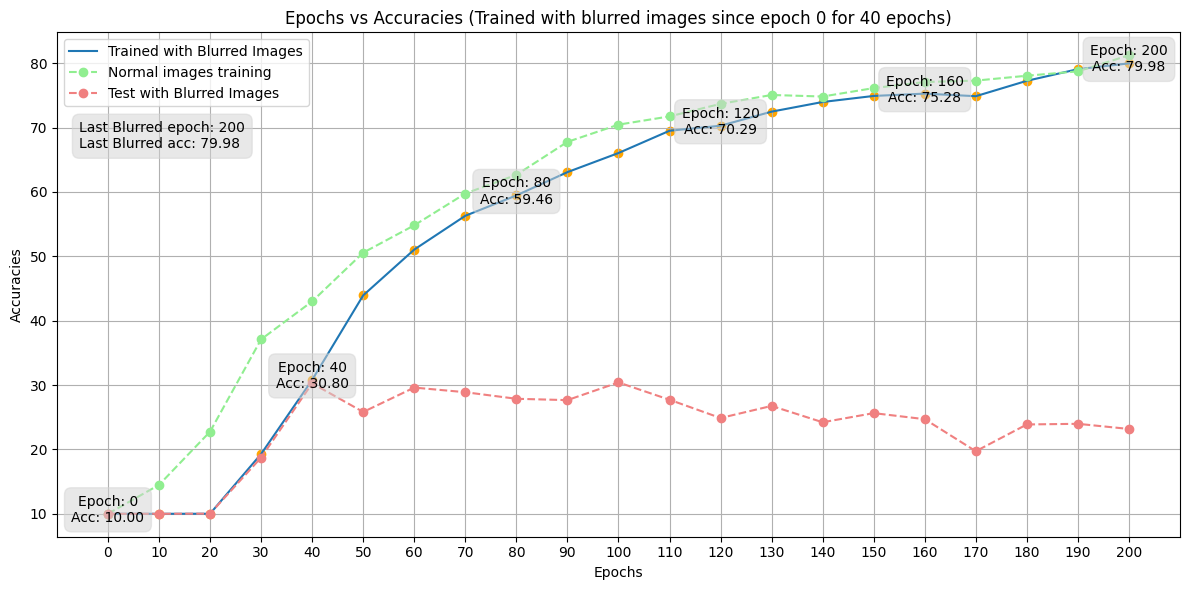

In [ ]:
# EJECUTAR PLOT despues de que tengamos modelo normal a 360 épocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40blurred_from_0.pt"

save_model(pretrained_epochs=pretrained_epochs,
           model_state_dict=model.state_dict(),
           optimizer_state_dict=optimizer.state_dict(),
           final_accuracy=round(final_accuracy, 2),
           training_data_dict=training_data_dict,
           test_data_dict=test_data_dict,
           checkpt_path=checkpoint_save_path)

data = load_pretrained_model(checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_0"
save_plot(path=plot_path, blur=True, training_data=training_data_dict,
          altered_test_data=model_data['test_data_dict'], altered_begin=0)

### 4.2 Modelo particular

In [ ]:
# desde 10 epocas

std_text = f'/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos'
mod_path = std_text + f'/allconv_noblur_checkpts/checkpoint_epoch_10.pt'

model_info  = begin_model_easy(normal_loader=train_loader,
                               altered_loader=train_loader_blur,
                               normal_test=test_loader,
                               altered_test=test_loader_blur,
                               model_path=mod_path)

model_data = model_info['model_data']

text = f"Training the model with Blur starting from {pretrained_epochs} non-blurred epochs"
pretty_print(text, '.')

checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_10.pt"
save_model(pretrained_epochs=model_data['pretrained_epochs'],
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           test_data_dict=model_info['test_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_10.png"
save_plot(plot_path, training_data=model_info['training_data_dict'],
          altered_test_data=model_info['test_data_dict'],
          altered_begin='10', blur=True)

#### En caso de que se guardó mal, editar y ejecutar este:

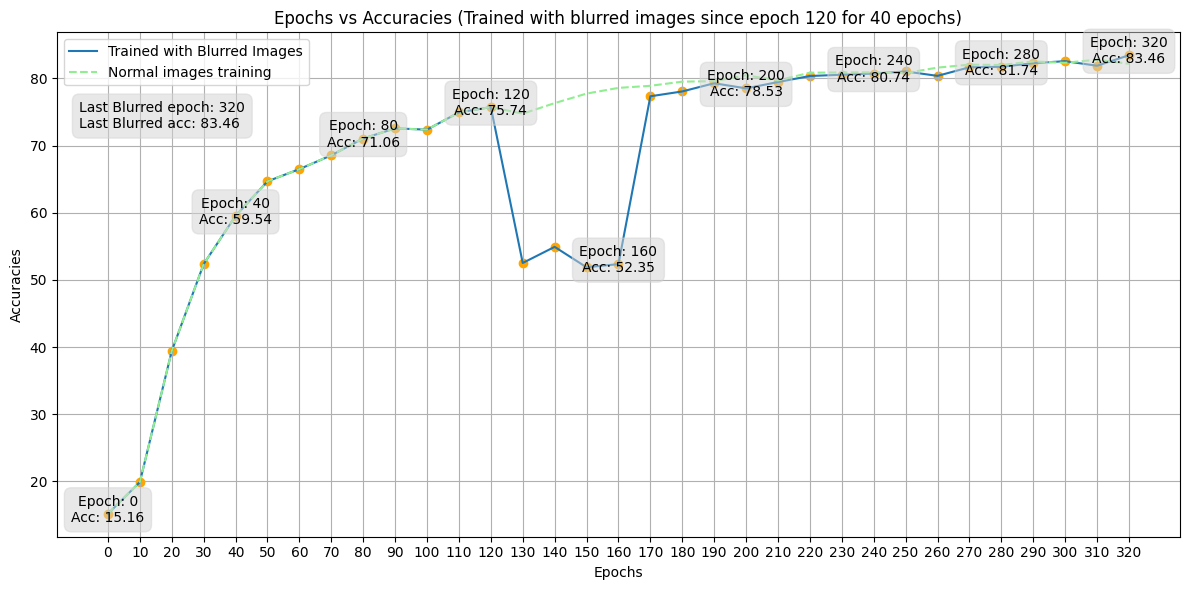

In [ ]:
pretrained_epochs = model_data['pretrained_epochs']
checkpoint_save_path = std_text + f"/40epochs_blur_checkpts/40Blurred_from_120.pt"
save_model(began_blur_epoch=pretrained_epochs,
           model_state_dict=model_info['model'].state_dict(),
           optimizer_state_dict=model_info['optimizer'].state_dict(),
           final_accuracy=round(model_info['final_accuracy'], 2),
           training_data_dict=model_info['training_data_dict'],
           checkpt_path=checkpoint_save_path)

plot_path = std_text + f"/Graficos/Blur training graphs/Blur_training_from_120.png"
save_plot(plot_path, model_info['training_data_dict'], '120', blur=True)

## 5.1. Generar gráfico de precisión vs época en donde se comenzó a entrenar con blur

In [ ]:
cant_archivos = 10 # cambiarlo a la cantidad de modelos que ya se encuentren en la carpeta 40epochs_blur_checkpoints

model_paths = [f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/40epochs_blur_checkpts/40Blurred_from_{10*i}.pt" for i in range(1,cant_archivos)]
accuracies = []
begin_epoch = [10*i for i in range(1,cant_archivos)]

for path in model_paths:
  model_data = torch.load(path)
  accuracies.append(model_data['final_accuracy'])

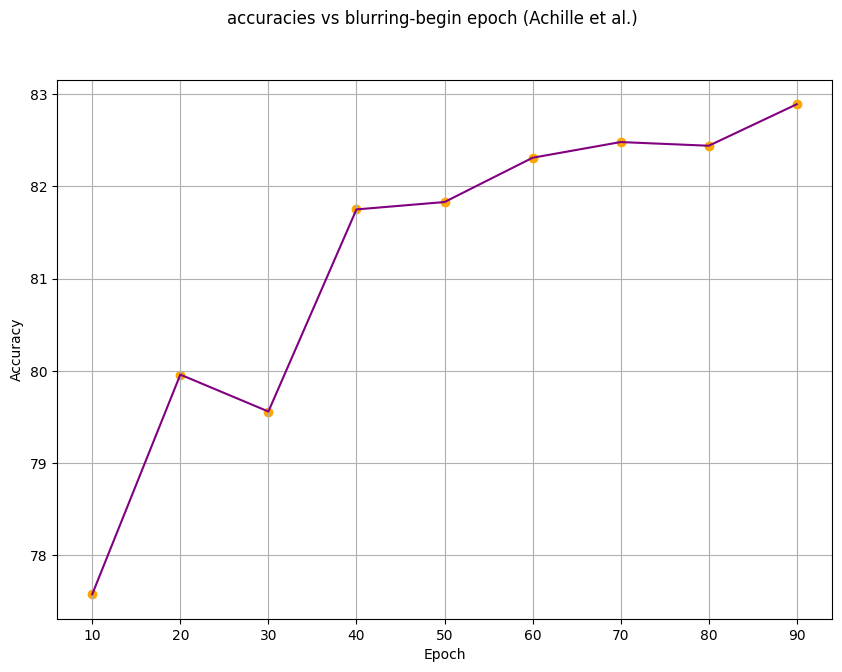

In [ ]:

fig, ax = plt.subplots(figsize=(10, 7))
ax.plot(begin_epoch, accuracies, color='purple')
ax.grid()
ax.scatter(begin_epoch, accuracies, color='orange')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.suptitle('accuracies vs blurring-begin epoch (Achille et al.)');

In [ ]:
save_path = f"/content/gdrive/MyDrive/Christ Diego Mircea/resultados experimentos/Graficos/Acc Vs Epoch  (Epoch when blurred training began).png"
plt.savefig(save_path, bbox_inches='tight', pad_inches=0.1)

<Figure size 640x480 with 0 Axes>